# Step1: Initializing the main and target CNN models

In [1]:
# imports
import cv2
import math
import numpy as np
import random
# reinforcement learning related
import re
import atari_py as ap
from collections import deque
from gym import make, ObservationWrapper, Wrapper
from gym.spaces import Box
# PyTorch imports
import torch
import torch.nn as nn
from torch import save
from torch.optim import Adam
import ale_py
import gym
import matplotlib.pyplot as plt
import PIL

### define the CNN model and functions such as forward passing and taking actions
It takes input size, total number of actions as input, output probability of taking each action;
the network has 3 convolutional layers with 32, 64, 64 filters with sizes 8* 8, 4* 4, 3*3

In [2]:
class CNN(nn.Module):
    def __init__(self, input_size, num_action):
        super(CNN,self).__init__()
        self._input_size = input_size
        self._num_action = num_action
        self.convLayer = nn.Sequential(
            nn.Conv2d(self._input_size[0],32,8,4),
            nn.ReLU(),
            nn.Conv2d(32,64,4,2),
            nn.ReLU(),
            nn.Conv2d(64,64,3,1),
            nn.ReLU()
        )
        self.linearLayer = nn.Sequential(
            nn.Linear(self.feature_size, 512),
            nn.ReLU(),
            nn.Linear(512,self._num_action)
        )
    def forward(self, x):
        # go through convolutional layers
        output = self.convLayer(x)
        # faltten the features
        output = output.view(x.size()[0],-1) # keep the batch dimension, and flatten the rest
        output = self.linearLayer(output)
        return output
    
    @property
    def feature_size(self):
        x = torch.zeros(1,*self._input_size)
        x = self.convLayer(x)
        return x.view(1,-1).size(1) # keep the first dimension as 1, and see what size the second
                                     #  dimension after flatten
    
    def take_action(self, state, eps, device):
        if random.random() > eps: # being greedy
            state = torch.from_numpy(np.double(state)).unsqueeze(0).to(device) # convert 
                #  state to float, increase a dimension, then sent to device where the model is
            state = state.float()
            # calculate Q values for each available action
            Q = self.forward(state)
            
            # choose an action accordingly
            #  torch.max(a,1) returns max values and their indices, we want the index
            #  representing the action with max Q value
            action = Q.max(1)[1].item()
        
        else: # select actions randomly
            action = random.randrange(self._num_action)
        return action
        
        

In [3]:
random.randrange(10)

9

### define the function that instantiates the main neural network and the target neural network

In [4]:
# Add the option to load trained weights!!!!!!!!!!!!
def model_initialize(env,device,path):
    main_model = CNN(env.observation_space.shape,env.action_space.n).to(device)
    target_model = CNN(env.observation_space.shape,env.action_space.n).to(device)
    if path is not None:
        main_model.load_state_dict(torch.load(path))
        target_model.load_state_dict(torch.load(path))
        print("Weights loaded")
    #print(main_model)
    return main_model, target_model

# Step2: define the experience replay buffer
store transitions (frames) of the game to train the CNN model with random sampling

In [5]:
class ReplayBuffer:
    def __init__(self, cap_max):
        # cap_max is the defined buffer size, the number of state trasitions that stored in the buffer
        self._buffer = deque(maxlen=cap_max) # use deque to speed up the append and pop operations
    
    # append (state, action, reward, next state, finish) tuple
    def push(self, state, action, reward, next_state, finish):
        self._buffer.append((state,action,reward,next_state,finish))
    
    
    def sample(self, batch_size):
        idxs = np.random.choice(len(self._buffer),batch_size,False) # chose random samples
        # e.g. idxs = (1,5,67,51,34,97,105,...)
        
        batch = zip(*[self._buffer[i] for i in idxs]) # put corresponding frames to a zipped list
        # e.g. batch = ((state_1,action_1.reward_1,next_state_1,finish_1),
        #                (state_5,action_5,reward_5,next_state_5,finish_5, ...)
        
        state, action, reward, next_state, finish = batch # create array for each category
        # e.g. state = (state_1,state_5,state_67,...)
        #      action = (action_1, action_5, action_67, ...)
        #      ...
        return (np.array(state),np.array(action),np.array(reward,dtype=float),
                 np.array(next_state),np.array(finish,dtype=np.uint8))
    
    def __len__(self):
        return len(self._buffer)

In [6]:
a = np.array([1,2,3,4,5,6,7])
np.random.choice(len(a),3,False)

array([6, 0, 2])

# Step 3: setting up environment

### define some initialization-related functions

In [7]:
# replace some string with _
def gym_to_atari_format(gym_env):
    return re.sub(r"(?<!^)(?=[A-Z])", "_", gym_env).lower()

# 
def check_atari_env(env):
    for f in ["Deterministic", "ramDeterministic", "ram", "NoFrameskip", "ramNoFrameSkip"]:
        env = env.replace(f, "")
    env = re.sub(r"-v\d+", "", env)
    env = gym_to_atari_format(env) 
    return True if env in ap.list_games() else False

### augment gym environment in a series of steps, 
include 1) downsampling the video game image frames, 2) pushing iamge frames to the experience replay buffer 3) converting images into PyTorch tnesors, ...  

In [8]:
# reseting environment for both atari or non-atari environment
class CCtrl(Wrapper):
    def __init__(self,env,is_atari):
        super(CCtrl,self).__init__(env)
        self._is_atari = is_atari
        
    def reset(self):
        if self._is_atari:
            return self.env.reset()
        else:
            self.env.reset()
            return self.env.render(mode="rgb_array")

# observations (frames) will be converted to grey-scale and reshape to (84,84)
class FrmDwSmpl(ObservationWrapper):
    def __init__(self, env):
        super(FrmDwSmpl,self).__init__(env)
        self.observation_space = Box(low=0,high=255,shape=(84,84,1),dtype=np.uint8)
        self._width=84
        self._height = 84
        
    def observation(self,observation):
        frame = cv2.cvtColor(observation,cv2.COLOR_RGB2GRAY) # turn the image to gray
        frame = cv2.resize(frame,(self._width,self._height), interpolation=cv2.INTER_AREA)
        return frame[:,:,None]
    
    
# use frame-skipping technique
class MaxNSkpEnv(Wrapper):
    def __init__(self, env, atari, skip=4):
        super(MaxNSkpEnv,self).__init__(env)
        self._obs_buffer = deque(maxlen=2)
        self._skip = skip
        self._atari = atari
    
    def step(self,action):
        total_reward = 0
        finish = None
        for _ in range(self._skip):
            # take a step
            obs, reward, finish, log = self.env.step(action)
            
            # clip reward
            #reward = np.array(reward) / 100
            #reward = math.tanh(reward)
            
            if not self._atari:
                obs = self.env.render(mode="rgb_array")
            # append the new stsate to the double ended queue buffer
            self._obs_buffer.append(obs)
            # accumulate the reward
            total_reward += reward
            if finish:
                break
        # buffer holds the last two frames, they are max-pooled, resulting in an observation
        #  that contains some temporal information
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, finish, log
    
    def reset(self):
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs
    
    

class FrRstEnv(Wrapper):
    def __init__(self,env):
        Wrapper.__init__(self,env)
        if len(env.unwrapped.get_action_meanings()) < 3:
            raise ValueError("min requred action space of 3!")
    
    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs,_,finish,_ = self.env.step(1)
        if finish:
            self.env.reset(**kwargs)
        obs,_,finish,_ = self.env.step(2)
        if finish:
            self.env.reset(**kwargs)
        return obs
    
    def step(self, action):
        return self.env.step(action)
    

class FrmBfr(ObservationWrapper):
    def __init__(self,env,num_steps,dtype=float):
        super(FrmBfr,self).__init__(env)
        obs_space = env.observation_space
        self._dtype = dtype
        self.observation_space = Box(obs_space.low.repeat(num_steps,axis=0),
                        obs_space.high.repeat(num_steps,axis=0), dtype=self._dtype)
    
    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low,dtype=self._dtype)
        return self.observation(self.env.reset())
    
    def observation(self,observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer
#
class Img2Trch(ObservationWrapper):
    def __init__(self,env):
        super(Img2Trch,self).__init__(env)
        obs_shape = self.observation_space.shape
        self.observation_space = Box(low=0,high=1,shape=(obs_shape[::-1]),dtype=float)
    
    def observation(self,observation):
        # move the last channel to the first place, experiment!!!!!!!
        return np.moveaxis(observation,2,0)

# normalizing pixel values
class NormFlts(ObservationWrapper):
    def observation(self,obs):
        return np.array(obs).astype(float) / 255




define a method that takes in the raw Pong video game environment as input and augments the environment, as follows:

In [9]:
def wrap_env(env_ip):
    env = gym.make(env_ip)
    is_atari = check_atari_env(env_ip) 
    env = CCtrl(env, is_atari) # preparing to reseting environment
    env = MaxNSkpEnv(env, is_atari) # initialize frame-skipping technique
    try:
        env_acts = env.unwrapped.get_action_meanings()
        if "FIRE" in env_acts:
            env = FrRstEnv(env)
    except AttributeError:
        pass
    env = FrmDwSmpl(env) # preprocessing pixels
    env = Img2Trch(env) # convert to tensor >
    env = FrmBfr(env,4) # initilize frame buffers
    env = NormFlts(env) # normalize pixel values
    return env
        

# Step 4: Defining the CNN optimization function

In [10]:
def convert(data,device):
    # data should be a numpy array
    return torch.from_numpy(data).to(device)

In [12]:
# loss function
def calc_temp_diff_loss(main_model,target_model,batch,gamma,device, ep):
    state, action, reward, next_state, finish = batch
    
    #reward = np.array(reward) / 100 # taking too much memory, directly change the reward as reward / 100
    
    # put tensors to cuda
    state = convert(state,device).float() 
    next_state = convert(next_state,device).float()
    action = convert(action,device)
    reward = convert(np.tanh(reward),device) # clipped reward
    finish = convert(finish,device)
    
    # use behavior policy to calculate current state action values
    Q_vals = main_model(state)
    
    # use target policy (greedy) to calculate state action values for next state
    next_Q_vals = target_model(next_state)
    
    action = action.long()
    
    # experiment!!!!!!!!!!!!!!!!!!
    Q_val = Q_vals.gather(1,action.unsqueeze(-1)).squeeze(-1)
    #print(Q_val)
    
    # index 0 because we wish to know the max q-value for next state, not which action that cause the max value
    next_Q_val = next_Q_vals.max(1)[0]
    
    # calculate the loss 
    expected_Q_val = reward + gamma * next_Q_val * (1-finish) 
    #print(expected_Q_val)
    #print(reward)
    #loss_fn = torch.nn.HuberLoss()
    loss_fn = torch.nn.MSELoss()
    Q_val, expected_Q_val = Q_val.float(), expected_Q_val.float()
    loss = loss_fn(Q_val,expected_Q_val) + 0.01 * Q_val.mean()
    

    
    return loss

In [13]:
a = [13,105,198,640]
b = torch.tensor(a) / 100
b

tensor([0.1300, 1.0500, 1.9800, 6.4000])

In [14]:
# updating function: samples a batch of data from the reperiemnce replay buffer,
#  computes the time difference loss on the batch, copies the weights of the main model
#  to the target model once every TGT_UPD_FRQ iterations
def update_graph(main_model,target_model,opt,buffer,device,log,ep):
    if len(buffer) >= INIT_LEARN:
        # let me know that the learning starts
        if len(buffer) == INIT_LEARN:
            print("\nLearning starts!\n")
        
        # let me know when buffer size is reached, (not letting this equal MEM_CAP is because I don't want print it everytime)
        if len(buffer) == MEM_CAP - 2:
            print("\nbuffer is full\n")
        
        # copy the wieghts main model to target model every 5000 iterations
        if ep < TGT_UPD_TH:
            k = TGT_UPD_FRQ1
        else:
            k = TGT_UPD_FRQ2
        
        
        if log.idx % k == 0: 
            target_model.load_state_dict(main_model.state_dict())
        
        # calculate predictions (action values) loss and update the weights in the model 
        opt.zero_grad() # clear cache
        batch = buffer.sample(B_S) # B_S is hyperparameter, sample B_S tuples of (state,...)
        loss = calc_temp_diff_loss(main_model,target_model,batch,G, device, ep)
        loss = loss.float()
        loss.backward()
        opt.step()
        

# Step5: managing and running episodes

In [15]:
# define the function to update the epsillon value after each episode
# the first 10 episodes will be more exploring
# the last 100 episodes will be pure greedy
def update_eps(epd,ep):
    #if ep <= 10:
        #return 0.5
    #elif ep >= N_EPDS - 100 - 1:
        #return 0
    
    last_eps = EPS_FINL
    first_eps = EPS_START
    # control rate of decay, the later phase, decay slower
    rate_decay = (epd+1) / EPS_DECAY
    if rate_decay < DECAY_TH:
        eps = last_eps + (first_eps - last_eps) * math.exp(-1*rate_decay)
    else:
        if rate_decay == DECAY_TH:
            print("\nForcing Slower Decay Start\n")
        eps = last_eps + (first_eps - last_eps) * math.exp(-1 * rate_decay) * (rate_decay+(1-DECAY_TH))
    return eps

In [16]:
# define the function to take action after end of an episode
#  if the overall reward that's scored in the current episode is the best we've achieved so far
#  we save the CNN model weights and print the reward value
def finish_episode(main_model,env,log,ep_reward,ep,eps,done):
    best_so_far = log.update_rewards(ep_reward)
    log.update_average_rewards()
    
    #if best_so_far and (ep <= N_EPDS - 100 - 1):
    if best_so_far:
        print(f"\nhighest running_average_reward of {round(log.best_average,3)} achieved!\n")
        save(main_model.state_dict(),f"Weights/{env}_run.pth")
    # save the weights if it is the last episode
    if done:
        save(main_model.state_dict(),f"Weights/{env}_last_run.pth")
    # display every 3 episodes
    #if ep % 3 == 0:
    print(f"EP {round(ep,1)}, curr_reward: {round(ep_reward,1)}, best_reward: {round(log.best_reward,1)}, running_avg_reward: {round(log.average, 3)}, curr_epsilon: {round(eps, 4)}")
    return eps

In [17]:
# define the DQN loop
def run_episodes(env,main_model,target_model,buffer,device,log,ep,done):
    # initializing
    episode_reward = 0.0
    state = env.reset()
    # first 50 episodes: lr = 1e-5, 50-300: 6e-6, >300: 2e-6, >1000: 1e-6
    if ep < EP_TH1:
        lr = LR1
    elif ep < EP_TH2:
        lr = LR2
    elif ep < EP_TH3:
        lr = LR3
    else:
        lr = LR4
    optimizer = Adam(main_model.parameters(),lr=lr)
    
    
    while True: 
        eps = update_eps(log.idx,ep) # update episolon based on current episode number
        #epss.append(eps)
        action = main_model.take_action(state,eps,device) # choose an action to take
        #if ep >= N_EPDS - 100 - 1: # display the game for the final 100 episodes
            #env.render() # display the environment
        env.render()
        next_state, reward, finish, _ = env.step(action)  # take the action
        buffer.push(state,action,reward,next_state,finish) # push current tuple to buffer
        
        # prepare for next iteration
        state = next_state 
        episode_reward += reward
        log.update_idx()
        

        
        update_graph(main_model,target_model,optimizer,buffer,device,log,ep) # perform learning - add ep parameter
        
        # break if reached end of the episode
        if finish:
            eps = finish_episode(main_model,ENV,log,episode_reward,ep,eps,done)
            return eps

# Step 6: define the matadata class

In [18]:
class TrMetadata:
    def __init__(self):
        self._average = 0.0
        self._best_reward = -float("inf")
        self._best_average = -float("inf")
        self._rewards = []
        self._average_rewards = [] # keep track of average rewards
        self._average_range = 100
        self._idx = 0
        self._best_rewards = [] # keep track of best rewards
    
    @property
    def best_reward(self):
        return self._best_reward
    
    @property
    def best_average(self):
        return self._best_average
    
    @property
    def average(self):
        average_range = self._average_range * -1
        average_reward = sum(self._rewards[average_range:]) / len(self._rewards[average_range:])
        return average_reward
    
    @property
    def idx(self):
        return self._idx
    
    def _update_best_reward(self,episode_reward):
        self._best_rewards.append(self._best_reward)
        if episode_reward > self.best_reward:
            self._best_reward = episode_reward
            
    
    def _update_best_average(self):
        if self.average > self.best_average:
            self._best_average = self.average
            return True
        return False
    
    def update_rewards(self,episode_reward):
        self._rewards.append(episode_reward)
        self._update_best_reward(episode_reward)
        return self._update_best_average()
    
    def update_average_rewards(self):
        self._average_rewards.append(self.average)
    
    def update_idx(self):
        self._idx += 1

# Step 7: training

In [19]:
from tqdm.auto import tqdm

def train(env,main_model,target_model,buffer,device):    
    log = TrMetadata()
    progress = tqdm(range(N_EPDS))
    epss = [] # keep track of epsilons
    
    
    for ep in np.arange(N_EPDS):
        done = (ep == N_EPDS-1)
        
        # record how many iterations per episode every 50 episode
        if ep % 25 == 0:
            start = log.idx
            eps = run_episodes(env,main_model,target_model,buffer,device,log,ep,done)
            print(f"\nThis episode takes {log.idx-start} iterations\n")
        else:
            eps = run_episodes(env,main_model,target_model,buffer,device,log,ep,done)
        epss.append(eps)
        
        # if the precentage difference between the current average and best average exceed diff, break
        threshold = max(DIFF_P * log._best_average, DIFF)
        if ((log._best_average - log.average) > threshold) and (ep>=BREAK_TH):
            return log._average_rewards, log._rewards, log._best_rewards, ep, epss
        
        progress.update(1)
    
    # return rewrads and average rewards
    return log._average_rewards, log._rewards, log._best_rewards, ep, epss

In [20]:
# hypterparameters 
B_S = 128 # batch size per SGD calculation
#ENV = "SpaceInvaders-v0"
ENV = "SpaceInvaders-v0"
EPS_START = 1.0
EPS_FINL = 0.01 # this could be changed because less actions are taken
EPS_DECAY = 100 * 1000 # around 500 episodes arive at threshold: 0.3, assuming 100 frames per episode
#EPS_DECAY = 75000
#EPS_DECAY2 = 400000 # decaying 4 time faster - 25000, 50000, made it unstable
G = 0.99 # gamma changed from 0.99
INIT_LEARN = 1000 # initial number of iterations that are reserved for pushing data
                   #  to the buffer
LR1 = 2e-4 # changed from 1e-5
LR2 = 1e-4 # changed from 6e-6
LR3 = 8e-5 # changed from 2e-6, 1e-6
LR4 = 1e-5 # changed from 1e-6
MEM_CAP = 40000 #size of experience replay buffer - can take more

TGT_UPD_FRQ1 = 1000 # changed from 8000, 10000, 15000
TGT_UPD_FRQ2 = 3000 # changed from 16000, 20000, 30000
TGT_UPD_TH = 2000 # threshold for updating target model weights

EP_TH1 = 1000 # threshold for updating learning rate
EP_TH2 = 2000
EP_TH3 = 5000

BREAK_TH = 200 # threshold for starting considering differeince in average learning
DIFF_P = 0.3 # if average reward is less than best average reward for more than 5, break, replace with percentage
DIFF = 4

DECAY_TH = 0.7

# Initialization - run every time

In [21]:
# start training
env = wrap_env(ENV)
device = "cuda"
path = "Weights/" + ENV + "_runC_2_2.pth"
#path = None
main_model, target_model = model_initialize(env,device,path)


Weights loaded


In [22]:
def plot_rewards(re,num_eps,reward_type,run):
    # plot and save the figure
    plt.figure(figsize=(12,8))
    x = np.arange(1,num_eps+1)
    filepath = "Figs_SI/runC2_"+str(run)+"_"+reward_type+"_"+str(num_eps)+"_episode.jpg"
    plt.plot(x,re)
    plt.xlabel("Episodes")
    plt.ylabel(f"{reward_type} Reward")
    plt.title(f"{reward_type} rewards for {num_eps} episodes")
    plt.savefig(filepath)
    plt.show()
    
    # save the array
    arraypath = "Rewards_SI/runC2_"+str(run)+"_"+reward_type+"_"+str(num_eps)+"_episode.npy"
    np.save(arraypath,re)
    

In [23]:
def pretty_plot(re,ave_re,best_re,run):
    plt.figure(figsize=(12,8))
    x = np.arange(1,len(re)+1)
    plt.plot(x,re,color=(0.999,0.8,0.9))
    plt.plot(x,ave_re,color=(0.9,0,0))
    plt.plot(x,best_re,color=(0,0,0.9))
    plt.legend(["Rewards", "Average Rewards", "Best Rewards"],loc="lower right")
    plt.title(f"Overview of rewards achieved in run {run}")
    plt.xlabel("Episodes")
    plt.ylabel("Rewards")
    filepath = "PrettyFig_SI/runC2_"+str(run)+".jpg"
    plt.savefig(filepath)
    plt.show()

In [24]:
def plot_eps(eps, run):
    plt.figure(figsize=(12,8))
    x = np.arange(1, len(eps)+1)
    plt.plot(x,eps,color=(0,0,0.9))
    plt.title(f"Epsilon Decaying Schedule in run {run}")
    plt.xlabel("Episodes")
    plt.ylabel("Episolon")
    filepath = "PrettyFig_SI/EPS_runC2_" + str(run) + ".jpg"
    plt.savefig(filepath)
    plt.show()
    

# test run

In [32]:
N_EPDS = 2000  # total number of episodes to train the agent for
EPS_START = 1
ave_re1, re1, best_re1,ep1 = train(env,main_model,target_model,buffer,device)
env.close()

  0%|          | 0/2000 [00:00<?, ?it/s]

W:\Tools\Anaconda3\envs\pytorch\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))



highest running_average_reward of 90.0 achieved!

EP 0, curr_reward: 90.0, best_reward: 90.0, running_avg_reward: 90.0, curr_epsilon: 0.9974

This episode takes 134 iterations


highest running_average_reward of 137.5 achieved!

EP 1, curr_reward: 185.0, best_reward: 185.0, running_avg_reward: 137.5, curr_epsilon: 0.9917
EP 2, curr_reward: 45.0, best_reward: 185.0, running_avg_reward: 106.667, curr_epsilon: 0.9893
EP 3, curr_reward: 20.0, best_reward: 185.0, running_avg_reward: 85.0, curr_epsilon: 0.9875
EP 4, curr_reward: 70.0, best_reward: 185.0, running_avg_reward: 82.0, curr_epsilon: 0.984

Learning starts!

EP 5, curr_reward: 110.0, best_reward: 185.0, running_avg_reward: 86.667, curr_epsilon: 0.9804
EP 6, curr_reward: 135.0, best_reward: 185.0, running_avg_reward: 93.571, curr_epsilon: 0.976
EP 7, curr_reward: 55.0, best_reward: 185.0, running_avg_reward: 88.75, curr_epsilon: 0.9743
EP 8, curr_reward: 85.0, best_reward: 185.0, running_avg_reward: 88.333, curr_epsilon: 0.9715
EP 

KeyboardInterrupt: 

In [33]:
env.close()

# Run 1 - incomplete - first attemp at modified decaying schedule

In [24]:
N_EPDS = 2000  # total number of episodes to train the agent for
EPS_START = 0.8
EPS_FINL = 0.01
DIFF_P = 0.3
BREAK_TH = 200
EPS_DECAY = 200 * 1000
ave_re, re, best_re,ep = train(env,main_model,target_model,buffer,device)
env.close()

  0%|          | 0/2000 [00:00<?, ?it/s]

W:\Tools\Anaconda3\envs\pytorch\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))



highest running_average_reward of 165.0 achieved!

EP 0, curr_reward: 165.0, best_reward: 165.0, running_avg_reward: 165.0, curr_epsilon: 0.7986

This episode takes 177 iterations


highest running_average_reward of 222.5 achieved!

EP 1, curr_reward: 280.0, best_reward: 280.0, running_avg_reward: 222.5, curr_epsilon: 0.7972
EP 2, curr_reward: 90.0, best_reward: 280.0, running_avg_reward: 178.333, curr_epsilon: 0.796
EP 3, curr_reward: 100.0, best_reward: 280.0, running_avg_reward: 158.75, curr_epsilon: 0.7942
EP 4, curr_reward: 35.0, best_reward: 280.0, running_avg_reward: 134.0, curr_epsilon: 0.7932

Learning starts!

EP 5, curr_reward: 545.0, best_reward: 545.0, running_avg_reward: 202.5, curr_epsilon: 0.7911
EP 6, curr_reward: 280.0, best_reward: 545.0, running_avg_reward: 213.571, curr_epsilon: 0.7889
EP 7, curr_reward: 20.0, best_reward: 545.0, running_avg_reward: 189.375, curr_epsilon: 0.7882
EP 8, curr_reward: 80.0, best_reward: 545.0, running_avg_reward: 177.222, curr_epsilon

EP 83, curr_reward: 445.0, best_reward: 715.0, running_avg_reward: 155.179, curr_epsilon: 0.6903
EP 84, curr_reward: 80.0, best_reward: 715.0, running_avg_reward: 154.294, curr_epsilon: 0.6892
EP 85, curr_reward: 45.0, best_reward: 715.0, running_avg_reward: 153.023, curr_epsilon: 0.6884
EP 86, curr_reward: 165.0, best_reward: 715.0, running_avg_reward: 153.161, curr_epsilon: 0.6871
EP 87, curr_reward: 80.0, best_reward: 715.0, running_avg_reward: 152.33, curr_epsilon: 0.686
EP 88, curr_reward: 125.0, best_reward: 715.0, running_avg_reward: 152.022, curr_epsilon: 0.6851
EP 89, curr_reward: 30.0, best_reward: 715.0, running_avg_reward: 150.667, curr_epsilon: 0.6844
EP 90, curr_reward: 110.0, best_reward: 715.0, running_avg_reward: 150.22, curr_epsilon: 0.6834
EP 91, curr_reward: 80.0, best_reward: 715.0, running_avg_reward: 149.457, curr_epsilon: 0.6825
EP 92, curr_reward: 260.0, best_reward: 715.0, running_avg_reward: 150.645, curr_epsilon: 0.6808
EP 93, curr_reward: 65.0, best_reward:

EP 168, curr_reward: 115.0, best_reward: 715.0, running_avg_reward: 160.1, curr_epsilon: 0.5983
EP 169, curr_reward: 100.0, best_reward: 715.0, running_avg_reward: 159.85, curr_epsilon: 0.5975
EP 170, curr_reward: 20.0, best_reward: 715.0, running_avg_reward: 157.5, curr_epsilon: 0.5969
EP 171, curr_reward: 120.0, best_reward: 715.0, running_avg_reward: 156.6, curr_epsilon: 0.596
EP 172, curr_reward: 65.0, best_reward: 715.0, running_avg_reward: 155.0, curr_epsilon: 0.5953
EP 173, curr_reward: 45.0, best_reward: 715.0, running_avg_reward: 155.35, curr_epsilon: 0.5945
EP 174, curr_reward: 205.0, best_reward: 715.0, running_avg_reward: 156.95, curr_epsilon: 0.5935
EP 175, curr_reward: 245.0, best_reward: 715.0, running_avg_reward: 156.55, curr_epsilon: 0.5914

This episode takes 358 iterations

EP 176, curr_reward: 80.0, best_reward: 715.0, running_avg_reward: 153.05, curr_epsilon: 0.5907
EP 177, curr_reward: 35.0, best_reward: 715.0, running_avg_reward: 151.6, curr_epsilon: 0.59
EP 178,

In [ ]:
env.close()

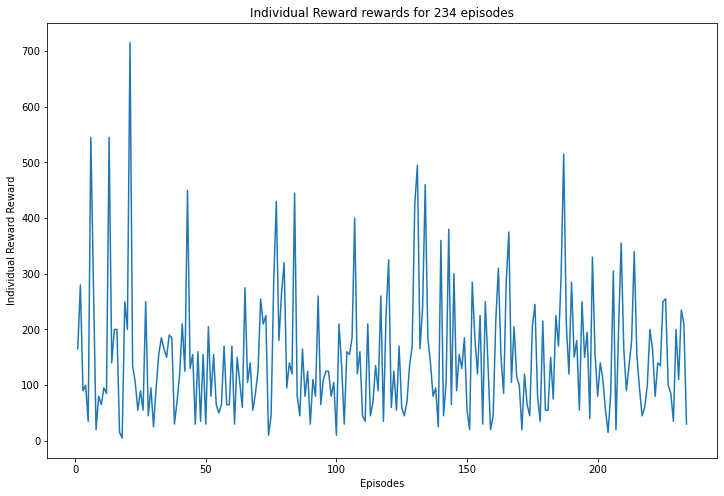

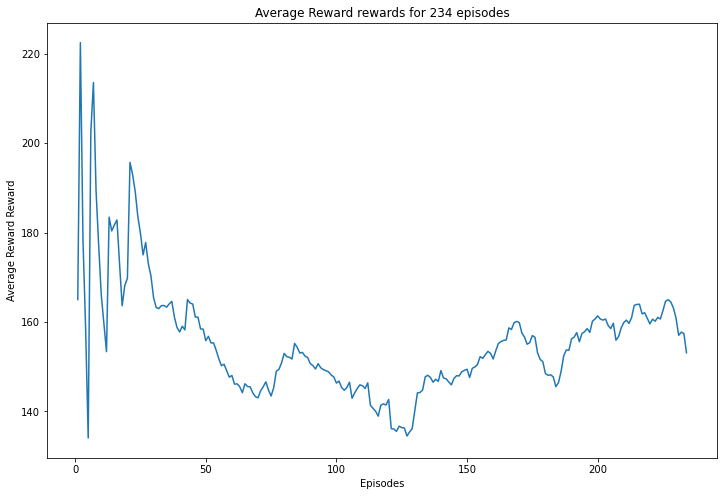

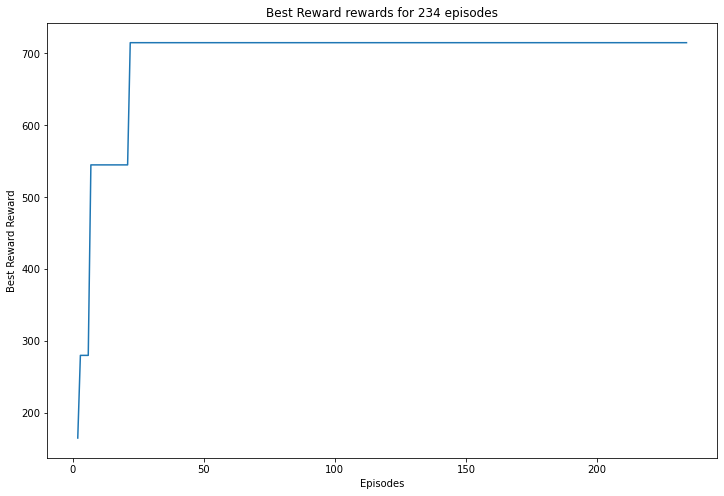

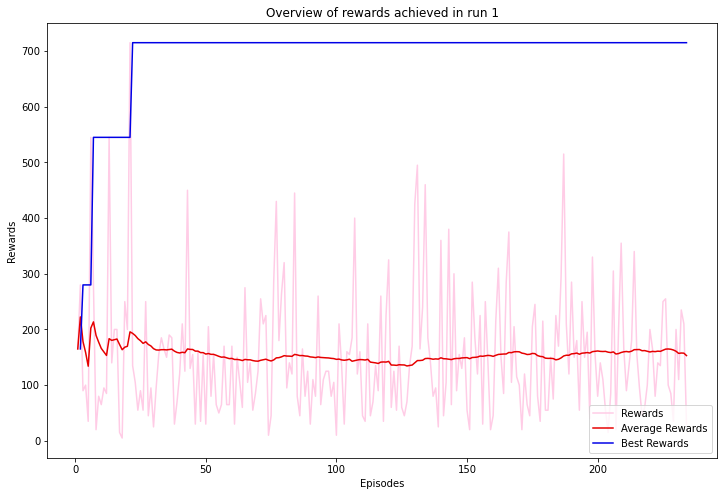

In [26]:
plot_rewards(re,ep+1,"Individual Reward",1)
plot_rewards(ave_re,ep+1,"Average Reward",1)
plot_rewards(best_re,ep+1,"Best Reward",1)
pretty_plot(re,ave_re,best_re,1)

# Run2 - complete

In [ ]:
N_EPDS = 2000  # total number of episodes to train the agent for

EPS_START = 1
EPS_FINL = 0.1

DIFF_P = 0.8
BREAK_TH = 1000

EPS_DECAY = 200 * 1000
DECAY_TH = 0.5

EP_TH1 = 1000 # threshold for updating learning rate
EP_TH2 = 2000
EP_TH3 = 5000
LR1 = 2e-4 # changed from 1e-5
LR2 = 1e-4 # changed from 6e-6
LR3 = 8e-5 # changed from 2e-6, 1e-6
LR4 = 1e-5 # changed from 1e-6

TGT_UPD_FRQ1 = 1000 # changed from 8000, 10000, 15000
TGT_UPD_FRQ2 = 3000 # changed from 16000, 20000, 30000
TGT_UPD_TH = 2000



In [27]:
ave_re, re, best_re,ep = train(env,main_model,target_model,buffer,device)
env.close()

  0%|          | 0/2000 [00:00<?, ?it/s]


highest running_average_reward of 110.0 achieved!

EP 0, curr_reward: 110.0, best_reward: 110.0, running_avg_reward: 110.0, curr_epsilon: 0.9994

This episode takes 139 iterations


highest running_average_reward of 115.0 achieved!

EP 1, curr_reward: 120.0, best_reward: 120.0, running_avg_reward: 115.0, curr_epsilon: 0.9986

highest running_average_reward of 138.333 achieved!

EP 2, curr_reward: 185.0, best_reward: 185.0, running_avg_reward: 138.333, curr_epsilon: 0.9977

highest running_average_reward of 160.0 achieved!

EP 3, curr_reward: 225.0, best_reward: 225.0, running_avg_reward: 160.0, curr_epsilon: 0.9968
EP 4, curr_reward: 135.0, best_reward: 225.0, running_avg_reward: 155.0, curr_epsilon: 0.996
EP 5, curr_reward: 105.0, best_reward: 225.0, running_avg_reward: 146.667, curr_epsilon: 0.9952

highest running_average_reward of 166.429 achieved!

EP 6, curr_reward: 285.0, best_reward: 285.0, running_avg_reward: 166.429, curr_epsilon: 0.9939
EP 7, curr_reward: 75.0, best_reward:

EP 79, curr_reward: 50.0, best_reward: 500.0, running_avg_reward: 155.875, curr_epsilon: 0.939
EP 80, curr_reward: 445.0, best_reward: 500.0, running_avg_reward: 159.444, curr_epsilon: 0.9378
EP 81, curr_reward: 35.0, best_reward: 500.0, running_avg_reward: 157.927, curr_epsilon: 0.9374
EP 82, curr_reward: 85.0, best_reward: 500.0, running_avg_reward: 157.048, curr_epsilon: 0.9366
EP 83, curr_reward: 180.0, best_reward: 500.0, running_avg_reward: 157.321, curr_epsilon: 0.9359
EP 84, curr_reward: 35.0, best_reward: 500.0, running_avg_reward: 155.882, curr_epsilon: 0.9354
EP 85, curr_reward: 240.0, best_reward: 500.0, running_avg_reward: 156.86, curr_epsilon: 0.9346
EP 86, curr_reward: 140.0, best_reward: 500.0, running_avg_reward: 156.667, curr_epsilon: 0.9341
EP 87, curr_reward: 10.0, best_reward: 500.0, running_avg_reward: 155.0, curr_epsilon: 0.9334
EP 88, curr_reward: 410.0, best_reward: 500.0, running_avg_reward: 157.865, curr_epsilon: 0.9322
EP 89, curr_reward: 40.0, best_reward: 

EP 164, curr_reward: 110.0, best_reward: 500.0, running_avg_reward: 140.55, curr_epsilon: 0.879
EP 165, curr_reward: 150.0, best_reward: 500.0, running_avg_reward: 141.25, curr_epsilon: 0.8781
EP 166, curr_reward: 30.0, best_reward: 500.0, running_avg_reward: 139.75, curr_epsilon: 0.8776
EP 167, curr_reward: 245.0, best_reward: 500.0, running_avg_reward: 139.85, curr_epsilon: 0.8765
EP 168, curr_reward: 115.0, best_reward: 500.0, running_avg_reward: 140.4, curr_epsilon: 0.8758
EP 169, curr_reward: 35.0, best_reward: 500.0, running_avg_reward: 139.15, curr_epsilon: 0.8754
EP 170, curr_reward: 60.0, best_reward: 500.0, running_avg_reward: 138.85, curr_epsilon: 0.8751
EP 171, curr_reward: 90.0, best_reward: 500.0, running_avg_reward: 139.15, curr_epsilon: 0.8744
EP 172, curr_reward: 105.0, best_reward: 500.0, running_avg_reward: 138.65, curr_epsilon: 0.8738
EP 173, curr_reward: 40.0, best_reward: 500.0, running_avg_reward: 138.2, curr_epsilon: 0.8735
EP 174, curr_reward: 140.0, best_rewar

EP 249, curr_reward: 120.0, best_reward: 500.0, running_avg_reward: 135.4, curr_epsilon: 0.8261
EP 250, curr_reward: 125.0, best_reward: 500.0, running_avg_reward: 135.45, curr_epsilon: 0.8253

This episode takes 232 iterations

EP 251, curr_reward: 135.0, best_reward: 500.0, running_avg_reward: 135.6, curr_epsilon: 0.8247
EP 252, curr_reward: 50.0, best_reward: 500.0, running_avg_reward: 135.0, curr_epsilon: 0.8244
EP 253, curr_reward: 190.0, best_reward: 500.0, running_avg_reward: 135.4, curr_epsilon: 0.8235
EP 254, curr_reward: 140.0, best_reward: 500.0, running_avg_reward: 135.6, curr_epsilon: 0.8229
EP 255, curr_reward: 120.0, best_reward: 500.0, running_avg_reward: 134.7, curr_epsilon: 0.8222
EP 256, curr_reward: 165.0, best_reward: 500.0, running_avg_reward: 134.85, curr_epsilon: 0.8215
EP 257, curr_reward: 190.0, best_reward: 500.0, running_avg_reward: 135.7, curr_epsilon: 0.8209
EP 258, curr_reward: 135.0, best_reward: 500.0, running_avg_reward: 135.75, curr_epsilon: 0.8204
EP

EP 333, curr_reward: 125.0, best_reward: 525.0, running_avg_reward: 151.3, curr_epsilon: 0.7717
EP 334, curr_reward: 165.0, best_reward: 525.0, running_avg_reward: 152.05, curr_epsilon: 0.7712
EP 335, curr_reward: 140.0, best_reward: 525.0, running_avg_reward: 152.05, curr_epsilon: 0.7705
EP 336, curr_reward: 75.0, best_reward: 525.0, running_avg_reward: 152.45, curr_epsilon: 0.7701
EP 337, curr_reward: 60.0, best_reward: 525.0, running_avg_reward: 152.7, curr_epsilon: 0.7696
EP 338, curr_reward: 540.0, best_reward: 540.0, running_avg_reward: 156.55, curr_epsilon: 0.7687
EP 339, curr_reward: 155.0, best_reward: 540.0, running_avg_reward: 157.4, curr_epsilon: 0.7682
EP 340, curr_reward: 85.0, best_reward: 540.0, running_avg_reward: 157.1, curr_epsilon: 0.7679
EP 341, curr_reward: 55.0, best_reward: 540.0, running_avg_reward: 157.05, curr_epsilon: 0.7674
EP 342, curr_reward: 110.0, best_reward: 540.0, running_avg_reward: 157.65, curr_epsilon: 0.7669
EP 343, curr_reward: 305.0, best_rewar

EP 418, curr_reward: 155.0, best_reward: 540.0, running_avg_reward: 154.2, curr_epsilon: 0.7231
EP 419, curr_reward: 170.0, best_reward: 540.0, running_avg_reward: 154.45, curr_epsilon: 0.7225
EP 420, curr_reward: 70.0, best_reward: 540.0, running_avg_reward: 154.25, curr_epsilon: 0.722
EP 421, curr_reward: 405.0, best_reward: 540.0, running_avg_reward: 155.6, curr_epsilon: 0.7213
EP 422, curr_reward: 340.0, best_reward: 540.0, running_avg_reward: 157.5, curr_epsilon: 0.7204
EP 423, curr_reward: 105.0, best_reward: 540.0, running_avg_reward: 157.5, curr_epsilon: 0.72
EP 424, curr_reward: 65.0, best_reward: 540.0, running_avg_reward: 154.55, curr_epsilon: 0.7195
EP 425, curr_reward: 370.0, best_reward: 540.0, running_avg_reward: 157.3, curr_epsilon: 0.719

This episode takes 192 iterations

EP 426, curr_reward: 215.0, best_reward: 540.0, running_avg_reward: 158.9, curr_epsilon: 0.7182
EP 427, curr_reward: 85.0, best_reward: 540.0, running_avg_reward: 158.7, curr_epsilon: 0.7176
EP 428, 

EP 502, curr_reward: 130.0, best_reward: 575.0, running_avg_reward: 188.05, curr_epsilon: 0.6732
EP 503, curr_reward: 110.0, best_reward: 575.0, running_avg_reward: 188.5, curr_epsilon: 0.6727
EP 504, curr_reward: 145.0, best_reward: 575.0, running_avg_reward: 187.85, curr_epsilon: 0.6723
EP 505, curr_reward: 30.0, best_reward: 575.0, running_avg_reward: 186.7, curr_epsilon: 0.6718
EP 506, curr_reward: 360.0, best_reward: 575.0, running_avg_reward: 189.15, curr_epsilon: 0.671

highest running_average_reward of 192.85 achieved!

EP 507, curr_reward: 470.0, best_reward: 575.0, running_avg_reward: 192.85, curr_epsilon: 0.6702
EP 508, curr_reward: 65.0, best_reward: 575.0, running_avg_reward: 191.35, curr_epsilon: 0.6699
EP 509, curr_reward: 135.0, best_reward: 575.0, running_avg_reward: 190.6, curr_epsilon: 0.6693
EP 510, curr_reward: 210.0, best_reward: 575.0, running_avg_reward: 191.25, curr_epsilon: 0.6687
EP 511, curr_reward: 95.0, best_reward: 575.0, running_avg_reward: 189.4, curr_e

EP 578, curr_reward: 340.0, best_reward: 670.0, running_avg_reward: 203.8, curr_epsilon: 0.6456
EP 579, curr_reward: 160.0, best_reward: 670.0, running_avg_reward: 203.1, curr_epsilon: 0.6456
EP 580, curr_reward: 140.0, best_reward: 670.0, running_avg_reward: 202.25, curr_epsilon: 0.6456
EP 581, curr_reward: 80.0, best_reward: 670.0, running_avg_reward: 201.95, curr_epsilon: 0.6456
EP 582, curr_reward: 105.0, best_reward: 670.0, running_avg_reward: 201.5, curr_epsilon: 0.6456
EP 583, curr_reward: 570.0, best_reward: 670.0, running_avg_reward: 202.8, curr_epsilon: 0.6455
EP 584, curr_reward: 355.0, best_reward: 670.0, running_avg_reward: 203.35, curr_epsilon: 0.6455
EP 585, curr_reward: 115.0, best_reward: 670.0, running_avg_reward: 202.7, curr_epsilon: 0.6455
EP 586, curr_reward: 75.0, best_reward: 670.0, running_avg_reward: 203.0, curr_epsilon: 0.6455
EP 587, curr_reward: 370.0, best_reward: 670.0, running_avg_reward: 204.7, curr_epsilon: 0.6455
EP 588, curr_reward: 25.0, best_reward:

EP 658, curr_reward: 85.0, best_reward: 670.0, running_avg_reward: 205.6, curr_epsilon: 0.6428
EP 659, curr_reward: 105.0, best_reward: 670.0, running_avg_reward: 205.65, curr_epsilon: 0.6428
EP 660, curr_reward: 150.0, best_reward: 670.0, running_avg_reward: 203.7, curr_epsilon: 0.6427
EP 661, curr_reward: 90.0, best_reward: 670.0, running_avg_reward: 202.1, curr_epsilon: 0.6427
EP 662, curr_reward: 185.0, best_reward: 670.0, running_avg_reward: 202.0, curr_epsilon: 0.6426
EP 663, curr_reward: 110.0, best_reward: 670.0, running_avg_reward: 201.9, curr_epsilon: 0.6426
EP 664, curr_reward: 55.0, best_reward: 670.0, running_avg_reward: 200.95, curr_epsilon: 0.6426
EP 665, curr_reward: 125.0, best_reward: 670.0, running_avg_reward: 200.85, curr_epsilon: 0.6425
EP 666, curr_reward: 120.0, best_reward: 670.0, running_avg_reward: 200.45, curr_epsilon: 0.6424
EP 667, curr_reward: 280.0, best_reward: 670.0, running_avg_reward: 196.7, curr_epsilon: 0.6424
EP 668, curr_reward: 55.0, best_reward:

EP 743, curr_reward: 110.0, best_reward: 670.0, running_avg_reward: 177.1, curr_epsilon: 0.6372
EP 744, curr_reward: 105.0, best_reward: 670.0, running_avg_reward: 173.65, curr_epsilon: 0.6372
EP 745, curr_reward: 110.0, best_reward: 670.0, running_avg_reward: 174.15, curr_epsilon: 0.6371
EP 746, curr_reward: 375.0, best_reward: 670.0, running_avg_reward: 176.55, curr_epsilon: 0.637
EP 747, curr_reward: 130.0, best_reward: 670.0, running_avg_reward: 174.7, curr_epsilon: 0.6369
EP 748, curr_reward: 130.0, best_reward: 670.0, running_avg_reward: 174.05, curr_epsilon: 0.6368
EP 749, curr_reward: 440.0, best_reward: 670.0, running_avg_reward: 176.45, curr_epsilon: 0.6367
EP 750, curr_reward: 115.0, best_reward: 670.0, running_avg_reward: 177.0, curr_epsilon: 0.6366

This episode takes 185 iterations

EP 751, curr_reward: 50.0, best_reward: 670.0, running_avg_reward: 172.35, curr_epsilon: 0.6366
EP 752, curr_reward: 235.0, best_reward: 670.0, running_avg_reward: 173.35, curr_epsilon: 0.6365

EP 827, curr_reward: 185.0, best_reward: 670.0, running_avg_reward: 201.05, curr_epsilon: 0.6292
EP 828, curr_reward: 200.0, best_reward: 670.0, running_avg_reward: 199.05, curr_epsilon: 0.6291
EP 829, curr_reward: 440.0, best_reward: 670.0, running_avg_reward: 201.15, curr_epsilon: 0.6289
EP 830, curr_reward: 215.0, best_reward: 670.0, running_avg_reward: 202.75, curr_epsilon: 0.6288
EP 831, curr_reward: 380.0, best_reward: 670.0, running_avg_reward: 205.2, curr_epsilon: 0.6287
EP 832, curr_reward: 610.0, best_reward: 670.0, running_avg_reward: 210.05, curr_epsilon: 0.6285
EP 833, curr_reward: 100.0, best_reward: 670.0, running_avg_reward: 206.5, curr_epsilon: 0.6284
EP 834, curr_reward: 185.0, best_reward: 670.0, running_avg_reward: 207.85, curr_epsilon: 0.6283
EP 835, curr_reward: 245.0, best_reward: 670.0, running_avg_reward: 209.0, curr_epsilon: 0.6281
EP 836, curr_reward: 55.0, best_reward: 670.0, running_avg_reward: 207.2, curr_epsilon: 0.6281
EP 837, curr_reward: 150.0, best_re

EP 907, curr_reward: 130.0, best_reward: 700.0, running_avg_reward: 223.75, curr_epsilon: 0.6188
EP 908, curr_reward: 45.0, best_reward: 700.0, running_avg_reward: 222.5, curr_epsilon: 0.6188
EP 909, curr_reward: 315.0, best_reward: 700.0, running_avg_reward: 224.5, curr_epsilon: 0.6186
EP 910, curr_reward: 60.0, best_reward: 700.0, running_avg_reward: 221.9, curr_epsilon: 0.6186
EP 911, curr_reward: 235.0, best_reward: 700.0, running_avg_reward: 223.7, curr_epsilon: 0.6184
EP 912, curr_reward: 120.0, best_reward: 700.0, running_avg_reward: 223.2, curr_epsilon: 0.6183
EP 913, curr_reward: 80.0, best_reward: 700.0, running_avg_reward: 222.3, curr_epsilon: 0.6182
EP 914, curr_reward: 30.0, best_reward: 700.0, running_avg_reward: 221.15, curr_epsilon: 0.6181
EP 915, curr_reward: 95.0, best_reward: 700.0, running_avg_reward: 220.2, curr_epsilon: 0.618
EP 916, curr_reward: 320.0, best_reward: 700.0, running_avg_reward: 220.45, curr_epsilon: 0.6179
EP 917, curr_reward: 195.0, best_reward: 70

EP 992, curr_reward: 145.0, best_reward: 700.0, running_avg_reward: 189.1, curr_epsilon: 0.6077
EP 993, curr_reward: 240.0, best_reward: 700.0, running_avg_reward: 187.85, curr_epsilon: 0.6075
EP 994, curr_reward: 95.0, best_reward: 700.0, running_avg_reward: 188.0, curr_epsilon: 0.6074
EP 995, curr_reward: 140.0, best_reward: 700.0, running_avg_reward: 188.6, curr_epsilon: 0.6073
EP 996, curr_reward: 60.0, best_reward: 700.0, running_avg_reward: 184.6, curr_epsilon: 0.6072
EP 997, curr_reward: 125.0, best_reward: 700.0, running_avg_reward: 183.25, curr_epsilon: 0.6071
EP 998, curr_reward: 110.0, best_reward: 700.0, running_avg_reward: 182.15, curr_epsilon: 0.607
EP 999, curr_reward: 135.0, best_reward: 700.0, running_avg_reward: 180.6, curr_epsilon: 0.6069
EP 1000, curr_reward: 185.0, best_reward: 700.0, running_avg_reward: 181.3, curr_epsilon: 0.6067

This episode takes 238 iterations

EP 1001, curr_reward: 300.0, best_reward: 700.0, running_avg_reward: 181.65, curr_epsilon: 0.6065
E

EP 1076, curr_reward: 170.0, best_reward: 700.0, running_avg_reward: 185.95, curr_epsilon: 0.5951
EP 1077, curr_reward: 65.0, best_reward: 700.0, running_avg_reward: 184.75, curr_epsilon: 0.5949
EP 1078, curr_reward: 30.0, best_reward: 700.0, running_avg_reward: 182.65, curr_epsilon: 0.5949
EP 1079, curr_reward: 315.0, best_reward: 700.0, running_avg_reward: 180.9, curr_epsilon: 0.5946
EP 1080, curr_reward: 390.0, best_reward: 700.0, running_avg_reward: 184.7, curr_epsilon: 0.5944
EP 1081, curr_reward: 165.0, best_reward: 700.0, running_avg_reward: 184.7, curr_epsilon: 0.5943
EP 1082, curr_reward: 155.0, best_reward: 700.0, running_avg_reward: 184.95, curr_epsilon: 0.5941
EP 1083, curr_reward: 30.0, best_reward: 700.0, running_avg_reward: 183.4, curr_epsilon: 0.594
EP 1084, curr_reward: 190.0, best_reward: 700.0, running_avg_reward: 182.05, curr_epsilon: 0.5939
EP 1085, curr_reward: 220.0, best_reward: 700.0, running_avg_reward: 182.5, curr_epsilon: 0.5937
EP 1086, curr_reward: 180.0, 

EP 1160, curr_reward: 145.0, best_reward: 700.0, running_avg_reward: 173.5, curr_epsilon: 0.5816
EP 1161, curr_reward: 380.0, best_reward: 700.0, running_avg_reward: 176.4, curr_epsilon: 0.5813
EP 1162, curr_reward: 170.0, best_reward: 700.0, running_avg_reward: 173.9, curr_epsilon: 0.5811
EP 1163, curr_reward: 165.0, best_reward: 700.0, running_avg_reward: 174.75, curr_epsilon: 0.581
EP 1164, curr_reward: 355.0, best_reward: 700.0, running_avg_reward: 177.6, curr_epsilon: 0.5808
EP 1165, curr_reward: 155.0, best_reward: 700.0, running_avg_reward: 178.4, curr_epsilon: 0.5806
EP 1166, curr_reward: 570.0, best_reward: 700.0, running_avg_reward: 182.0, curr_epsilon: 0.5803
EP 1167, curr_reward: 230.0, best_reward: 700.0, running_avg_reward: 182.4, curr_epsilon: 0.5801
EP 1168, curr_reward: 240.0, best_reward: 700.0, running_avg_reward: 184.4, curr_epsilon: 0.5798
EP 1169, curr_reward: 390.0, best_reward: 700.0, running_avg_reward: 187.05, curr_epsilon: 0.5796
EP 1170, curr_reward: 110.0, 

EP 1244, curr_reward: 130.0, best_reward: 700.0, running_avg_reward: 212.2, curr_epsilon: 0.5656
EP 1245, curr_reward: 190.0, best_reward: 700.0, running_avg_reward: 212.85, curr_epsilon: 0.5654
EP 1246, curr_reward: 335.0, best_reward: 700.0, running_avg_reward: 215.05, curr_epsilon: 0.5652
EP 1247, curr_reward: 200.0, best_reward: 700.0, running_avg_reward: 213.15, curr_epsilon: 0.565
EP 1248, curr_reward: 215.0, best_reward: 700.0, running_avg_reward: 211.65, curr_epsilon: 0.5648
EP 1249, curr_reward: 335.0, best_reward: 700.0, running_avg_reward: 213.75, curr_epsilon: 0.5645
EP 1250, curr_reward: 245.0, best_reward: 700.0, running_avg_reward: 213.9, curr_epsilon: 0.5643

This episode takes 244 iterations

EP 1251, curr_reward: 180.0, best_reward: 700.0, running_avg_reward: 213.8, curr_epsilon: 0.5641
EP 1252, curr_reward: 90.0, best_reward: 700.0, running_avg_reward: 211.6, curr_epsilon: 0.564
EP 1253, curr_reward: 110.0, best_reward: 700.0, running_avg_reward: 210.6, curr_epsilon:

EP 1327, curr_reward: 295.0, best_reward: 700.0, running_avg_reward: 198.9, curr_epsilon: 0.5494
EP 1328, curr_reward: 140.0, best_reward: 700.0, running_avg_reward: 199.1, curr_epsilon: 0.5492
EP 1329, curr_reward: 110.0, best_reward: 700.0, running_avg_reward: 198.95, curr_epsilon: 0.5491
EP 1330, curr_reward: 145.0, best_reward: 700.0, running_avg_reward: 197.4, curr_epsilon: 0.5489
EP 1331, curr_reward: 335.0, best_reward: 700.0, running_avg_reward: 198.75, curr_epsilon: 0.5487
EP 1332, curr_reward: 185.0, best_reward: 700.0, running_avg_reward: 196.55, curr_epsilon: 0.5485
EP 1333, curr_reward: 245.0, best_reward: 700.0, running_avg_reward: 197.85, curr_epsilon: 0.5483
EP 1334, curr_reward: 410.0, best_reward: 700.0, running_avg_reward: 199.55, curr_epsilon: 0.548
EP 1335, curr_reward: 315.0, best_reward: 700.0, running_avg_reward: 200.7, curr_epsilon: 0.5477
EP 1336, curr_reward: 180.0, best_reward: 700.0, running_avg_reward: 200.55, curr_epsilon: 0.5475
EP 1337, curr_reward: 390


highest running_average_reward of 249.35 achieved!

EP 1404, curr_reward: 580.0, best_reward: 980.0, running_avg_reward: 249.35, curr_epsilon: 0.5325

highest running_average_reward of 251.95 achieved!

EP 1405, curr_reward: 370.0, best_reward: 980.0, running_avg_reward: 251.95, curr_epsilon: 0.5323
EP 1406, curr_reward: 70.0, best_reward: 980.0, running_avg_reward: 250.95, curr_epsilon: 0.5321
EP 1407, curr_reward: 105.0, best_reward: 980.0, running_avg_reward: 248.0, curr_epsilon: 0.532
EP 1408, curr_reward: 145.0, best_reward: 980.0, running_avg_reward: 247.25, curr_epsilon: 0.5318
EP 1409, curr_reward: 105.0, best_reward: 980.0, running_avg_reward: 246.55, curr_epsilon: 0.5316
EP 1410, curr_reward: 210.0, best_reward: 980.0, running_avg_reward: 244.25, curr_epsilon: 0.5314
EP 1411, curr_reward: 290.0, best_reward: 980.0, running_avg_reward: 242.8, curr_epsilon: 0.5312
EP 1412, curr_reward: 105.0, best_reward: 980.0, running_avg_reward: 241.15, curr_epsilon: 0.5311
EP 1413, curr_re

EP 1486, curr_reward: 355.0, best_reward: 980.0, running_avg_reward: 195.25, curr_epsilon: 0.5173
EP 1487, curr_reward: 365.0, best_reward: 980.0, running_avg_reward: 197.3, curr_epsilon: 0.517
EP 1488, curr_reward: 160.0, best_reward: 980.0, running_avg_reward: 197.5, curr_epsilon: 0.5169
EP 1489, curr_reward: 125.0, best_reward: 980.0, running_avg_reward: 195.95, curr_epsilon: 0.5167
EP 1490, curr_reward: 465.0, best_reward: 980.0, running_avg_reward: 198.15, curr_epsilon: 0.5164
EP 1491, curr_reward: 335.0, best_reward: 980.0, running_avg_reward: 198.85, curr_epsilon: 0.5162
EP 1492, curr_reward: 265.0, best_reward: 980.0, running_avg_reward: 200.5, curr_epsilon: 0.5159
EP 1493, curr_reward: 185.0, best_reward: 980.0, running_avg_reward: 200.6, curr_epsilon: 0.5157
EP 1494, curr_reward: 50.0, best_reward: 980.0, running_avg_reward: 199.6, curr_epsilon: 0.5156
EP 1495, curr_reward: 105.0, best_reward: 980.0, running_avg_reward: 197.65, curr_epsilon: 0.5155
EP 1496, curr_reward: 275.0

EP 1570, curr_reward: 115.0, best_reward: 980.0, running_avg_reward: 250.25, curr_epsilon: 0.499
EP 1571, curr_reward: 205.0, best_reward: 980.0, running_avg_reward: 250.65, curr_epsilon: 0.4987

highest running_average_reward of 252.95 achieved!

EP 1572, curr_reward: 460.0, best_reward: 980.0, running_avg_reward: 252.95, curr_epsilon: 0.4985
EP 1573, curr_reward: 120.0, best_reward: 980.0, running_avg_reward: 252.85, curr_epsilon: 0.4983

highest running_average_reward of 253.8 achieved!

EP 1574, curr_reward: 310.0, best_reward: 980.0, running_avg_reward: 253.8, curr_epsilon: 0.4981
EP 1575, curr_reward: 80.0, best_reward: 980.0, running_avg_reward: 253.25, curr_epsilon: 0.498

This episode takes 135 iterations


highest running_average_reward of 253.95 achieved!

EP 1576, curr_reward: 150.0, best_reward: 980.0, running_avg_reward: 253.95, curr_epsilon: 0.4978

highest running_average_reward of 254.2 achieved!

EP 1577, curr_reward: 185.0, best_reward: 980.0, running_avg_reward: 254

EP 1647, curr_reward: 295.0, best_reward: 980.0, running_avg_reward: 248.1, curr_epsilon: 0.4828
EP 1648, curr_reward: 140.0, best_reward: 980.0, running_avg_reward: 248.15, curr_epsilon: 0.4826
EP 1649, curr_reward: 310.0, best_reward: 980.0, running_avg_reward: 250.1, curr_epsilon: 0.4824
EP 1650, curr_reward: 175.0, best_reward: 980.0, running_avg_reward: 249.45, curr_epsilon: 0.4822

This episode takes 196 iterations

EP 1651, curr_reward: 80.0, best_reward: 980.0, running_avg_reward: 249.7, curr_epsilon: 0.4821
EP 1652, curr_reward: 425.0, best_reward: 980.0, running_avg_reward: 252.0, curr_epsilon: 0.4817
EP 1653, curr_reward: 230.0, best_reward: 980.0, running_avg_reward: 253.45, curr_epsilon: 0.4816
EP 1654, curr_reward: 110.0, best_reward: 980.0, running_avg_reward: 252.35, curr_epsilon: 0.4814
EP 1655, curr_reward: 360.0, best_reward: 980.0, running_avg_reward: 251.05, curr_epsilon: 0.4812
EP 1656, curr_reward: 265.0, best_reward: 980.0, running_avg_reward: 251.95, curr_epsil

EP 1730, curr_reward: 80.0, best_reward: 980.0, running_avg_reward: 251.3, curr_epsilon: 0.4653
EP 1731, curr_reward: 180.0, best_reward: 980.0, running_avg_reward: 250.0, curr_epsilon: 0.465
EP 1732, curr_reward: 210.0, best_reward: 980.0, running_avg_reward: 250.6, curr_epsilon: 0.4648
EP 1733, curr_reward: 255.0, best_reward: 980.0, running_avg_reward: 249.7, curr_epsilon: 0.4646
EP 1734, curr_reward: 90.0, best_reward: 980.0, running_avg_reward: 244.6, curr_epsilon: 0.4645
EP 1735, curr_reward: 340.0, best_reward: 980.0, running_avg_reward: 246.6, curr_epsilon: 0.4643
EP 1736, curr_reward: 250.0, best_reward: 980.0, running_avg_reward: 246.65, curr_epsilon: 0.464
EP 1737, curr_reward: 105.0, best_reward: 980.0, running_avg_reward: 247.2, curr_epsilon: 0.4638
EP 1738, curr_reward: 170.0, best_reward: 980.0, running_avg_reward: 247.25, curr_epsilon: 0.4637
EP 1739, curr_reward: 110.0, best_reward: 980.0, running_avg_reward: 244.35, curr_epsilon: 0.4635
EP 1740, curr_reward: 170.0, be

EP 1814, curr_reward: 255.0, best_reward: 980.0, running_avg_reward: 215.8, curr_epsilon: 0.4483
EP 1815, curr_reward: 55.0, best_reward: 980.0, running_avg_reward: 215.2, curr_epsilon: 0.4481
EP 1816, curr_reward: 185.0, best_reward: 980.0, running_avg_reward: 215.45, curr_epsilon: 0.4479
EP 1817, curr_reward: 110.0, best_reward: 980.0, running_avg_reward: 213.8, curr_epsilon: 0.4477
EP 1818, curr_reward: 145.0, best_reward: 980.0, running_avg_reward: 213.3, curr_epsilon: 0.4476
EP 1819, curr_reward: 195.0, best_reward: 980.0, running_avg_reward: 213.45, curr_epsilon: 0.4474
EP 1820, curr_reward: 485.0, best_reward: 980.0, running_avg_reward: 216.9, curr_epsilon: 0.4472
EP 1821, curr_reward: 300.0, best_reward: 980.0, running_avg_reward: 214.5, curr_epsilon: 0.447
EP 1822, curr_reward: 40.0, best_reward: 980.0, running_avg_reward: 211.2, curr_epsilon: 0.4468
EP 1823, curr_reward: 305.0, best_reward: 980.0, running_avg_reward: 211.5, curr_epsilon: 0.4466
EP 1824, curr_reward: 40.0, bes

EP 1898, curr_reward: 260.0, best_reward: 980.0, running_avg_reward: 226.5, curr_epsilon: 0.4309
EP 1899, curr_reward: 410.0, best_reward: 980.0, running_avg_reward: 228.95, curr_epsilon: 0.4308
EP 1900, curr_reward: 160.0, best_reward: 980.0, running_avg_reward: 229.7, curr_epsilon: 0.4306

This episode takes 194 iterations

EP 1901, curr_reward: 220.0, best_reward: 980.0, running_avg_reward: 230.8, curr_epsilon: 0.4303
EP 1902, curr_reward: 90.0, best_reward: 980.0, running_avg_reward: 228.85, curr_epsilon: 0.4302
EP 1903, curr_reward: 340.0, best_reward: 980.0, running_avg_reward: 227.2, curr_epsilon: 0.4299
EP 1904, curr_reward: 125.0, best_reward: 980.0, running_avg_reward: 227.05, curr_epsilon: 0.4298
EP 1905, curr_reward: 120.0, best_reward: 980.0, running_avg_reward: 225.95, curr_epsilon: 0.4297
EP 1906, curr_reward: 80.0, best_reward: 980.0, running_avg_reward: 225.95, curr_epsilon: 0.4295
EP 1907, curr_reward: 130.0, best_reward: 980.0, running_avg_reward: 224.85, curr_epsilo

EP 1981, curr_reward: 445.0, best_reward: 980.0, running_avg_reward: 221.65, curr_epsilon: 0.4151
EP 1982, curr_reward: 110.0, best_reward: 980.0, running_avg_reward: 221.95, curr_epsilon: 0.415
EP 1983, curr_reward: 270.0, best_reward: 980.0, running_avg_reward: 222.9, curr_epsilon: 0.4148
EP 1984, curr_reward: 185.0, best_reward: 980.0, running_avg_reward: 221.2, curr_epsilon: 0.4146
EP 1985, curr_reward: 260.0, best_reward: 980.0, running_avg_reward: 221.4, curr_epsilon: 0.4143
EP 1986, curr_reward: 90.0, best_reward: 980.0, running_avg_reward: 218.7, curr_epsilon: 0.4142
EP 1987, curr_reward: 470.0, best_reward: 980.0, running_avg_reward: 222.35, curr_epsilon: 0.4139
EP 1988, curr_reward: 165.0, best_reward: 980.0, running_avg_reward: 222.65, curr_epsilon: 0.4138
EP 1989, curr_reward: 330.0, best_reward: 980.0, running_avg_reward: 224.7, curr_epsilon: 0.4136
EP 1990, curr_reward: 185.0, best_reward: 980.0, running_avg_reward: 224.55, curr_epsilon: 0.4134
EP 1991, curr_reward: 365.0

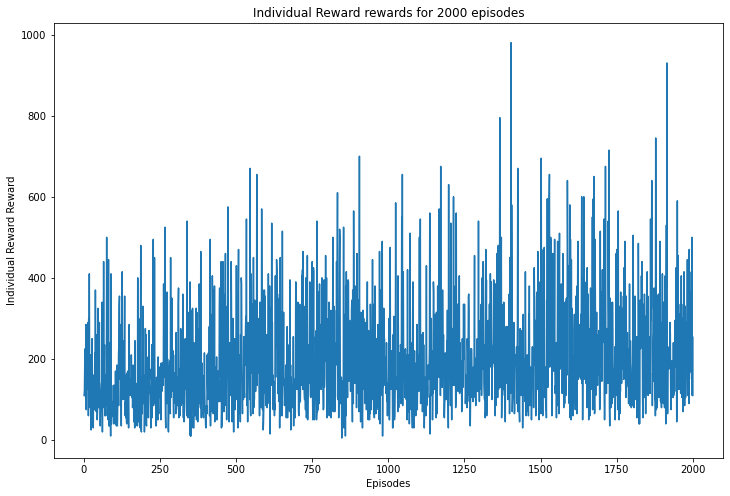

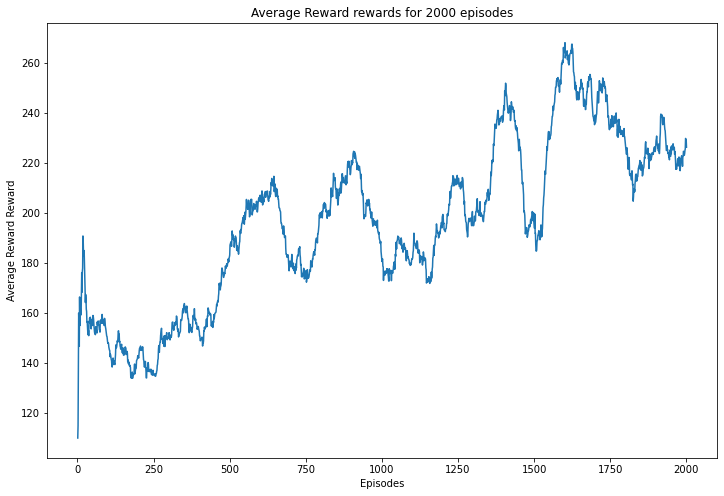

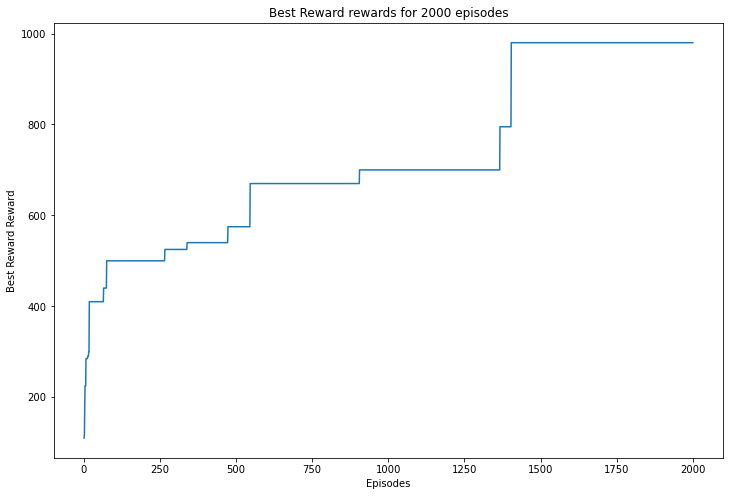

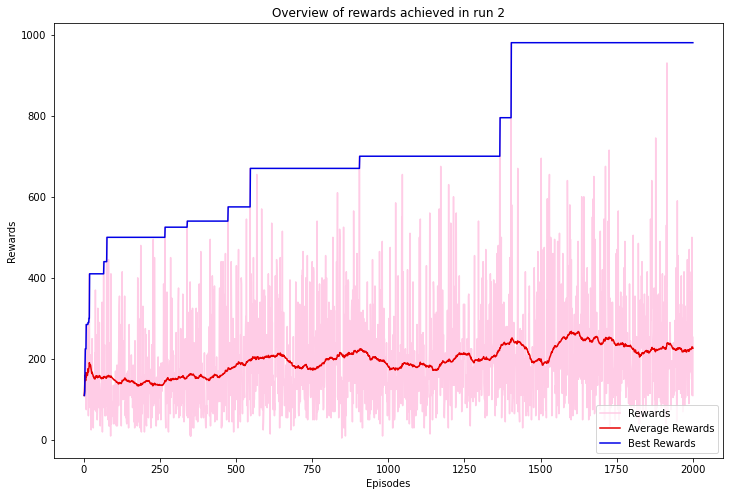

In [28]:
plot_rewards(re,ep+1,"Individual Reward",2)
plot_rewards(ave_re,ep+1,"Average Reward",2)
plot_rewards(best_re,ep+1,"Best Reward",2)
pretty_plot(re,ave_re,best_re,2)

# Run 3 - it needs to see what winning looks like

In [37]:
N_EPDS = 2000  # total number of episodes to train the agent for

EPS_START = 0.2
EPS_FINL = 0.005
DECAY_TH = 1 # starting to slower decrease at ep = 0.077, at frames/DECAY = 1
EPS_DECAY = 300 * 800 # at around 800 episodes given frames per episode is 300

DIFF_P = 0.3
BREAK_TH = 400


EP_TH1 = 500 # threshold for updating learning rate
EP_TH2 = 1000
EP_TH3 = 5000
LR1 = 8e-5 
LR2 = 4e-5 
LR3 = 1e-5 
LR4 = 1e-5 

TGT_UPD_FRQ1 = 1500 
TGT_UPD_FRQ2 = 4000 
TGT_UPD_TH = 400

In [40]:

ave_re, re, best_re,ep, epss = train(env,main_model,target_model,buffer,device)
env.close()

  0%|          | 0/2000 [00:00<?, ?it/s]


highest running_average_reward of 135.0 achieved!

EP 0, curr_reward: 135.0, best_reward: 135.0, running_avg_reward: 135.0, curr_epsilon: 0.1999

This episode takes 168 iterations


highest running_average_reward of 210.0 achieved!

EP 1, curr_reward: 285.0, best_reward: 285.0, running_avg_reward: 210.0, curr_epsilon: 0.1997
EP 2, curr_reward: 80.0, best_reward: 285.0, running_avg_reward: 166.667, curr_epsilon: 0.1996
EP 3, curr_reward: 205.0, best_reward: 285.0, running_avg_reward: 176.25, curr_epsilon: 0.1994
EP 4, curr_reward: 135.0, best_reward: 285.0, running_avg_reward: 168.0, curr_epsilon: 0.1992
EP 5, curr_reward: 175.0, best_reward: 285.0, running_avg_reward: 169.167, curr_epsilon: 0.1991
EP 6, curr_reward: 75.0, best_reward: 285.0, running_avg_reward: 155.714, curr_epsilon: 0.199
EP 7, curr_reward: 510.0, best_reward: 510.0, running_avg_reward: 200.0, curr_epsilon: 0.1987
EP 8, curr_reward: 120.0, best_reward: 510.0, running_avg_reward: 191.111, curr_epsilon: 0.1986
EP 9, cu

KeyboardInterrupt: 

# Let's train from scratch - RunS1 - lost graph

In [26]:
N_EPDS = 2000  # total number of episodes to train the agent for

EPS_START = 1
EPS_FINL = 0.1

DIFF_P = 0.8
BREAK_TH = 1000

EPS_DECAY = 100 * 500 # epd equals EPS_DECAY approximately 500 episodes, assuming 100 frames per episode, slowing start are 1000 episodes
DECAY_TH = 2 # start slowing decay at rate = 2, eps = 0.2218

EP_TH1 = 1000 # threshold for updating learning rate
EP_TH2 = 2000
EP_TH3 = 5000
LR1 = 2e-4 # changed from 1e-5
LR2 = 1e-4 # changed from 6e-6
LR3 = 8e-5 # changed from 2e-6, 1e-6
LR4 = 1e-5 # changed from 1e-6

TGT_UPD_FRQ1 = 400 # update approximately 4 episodes
TGT_UPD_FRQ2 = 1000 # change to maybe 10 episodes after 800 episodes
TGT_UPD_TH = 400



In [27]:
ave_re, re, best_re,ep, epss = train(env,main_model,target_model,buffer,device)
env.close()

  0%|          | 0/2000 [00:00<?, ?it/s]


highest running_average_reward of 50.0 achieved!

EP 0, curr_reward: 50.0, best_reward: 50.0, running_avg_reward: 50.0, curr_epsilon: 0.9978

This episode takes 122 iterations


highest running_average_reward of 87.5 achieved!

EP 1, curr_reward: 125.0, best_reward: 125.0, running_avg_reward: 87.5, curr_epsilon: 0.9942
EP 2, curr_reward: 45.0, best_reward: 125.0, running_avg_reward: 73.333, curr_epsilon: 0.9915
EP 3, curr_reward: 5.0, best_reward: 125.0, running_avg_reward: 56.25, curr_epsilon: 0.99
EP 4, curr_reward: 35.0, best_reward: 125.0, running_avg_reward: 52.0, curr_epsilon: 0.9884
EP 5, curr_reward: 85.0, best_reward: 125.0, running_avg_reward: 57.5, curr_epsilon: 0.9861

Learning starts!


highest running_average_reward of 90.0 achieved!

EP 6, curr_reward: 285.0, best_reward: 285.0, running_avg_reward: 90.0, curr_epsilon: 0.9819

highest running_average_reward of 110.625 achieved!

EP 7, curr_reward: 255.0, best_reward: 285.0, running_avg_reward: 110.625, curr_epsilon: 0.97

EP 80, curr_reward: 455.0, best_reward: 605.0, running_avg_reward: 140.0, curr_epsilon: 0.7844
EP 81, curr_reward: 345.0, best_reward: 605.0, running_avg_reward: 142.5, curr_epsilon: 0.781
EP 82, curr_reward: 355.0, best_reward: 605.0, running_avg_reward: 145.06, curr_epsilon: 0.7781
EP 83, curr_reward: 515.0, best_reward: 605.0, running_avg_reward: 149.464, curr_epsilon: 0.7754
EP 84, curr_reward: 140.0, best_reward: 605.0, running_avg_reward: 149.353, curr_epsilon: 0.7724
EP 85, curr_reward: 135.0, best_reward: 605.0, running_avg_reward: 149.186, curr_epsilon: 0.77
EP 86, curr_reward: 55.0, best_reward: 605.0, running_avg_reward: 148.103, curr_epsilon: 0.7685
EP 87, curr_reward: 35.0, best_reward: 605.0, running_avg_reward: 146.818, curr_epsilon: 0.7671
EP 88, curr_reward: 315.0, best_reward: 605.0, running_avg_reward: 148.708, curr_epsilon: 0.7624
EP 89, curr_reward: 105.0, best_reward: 605.0, running_avg_reward: 148.222, curr_epsilon: 0.7608
EP 90, curr_reward: 180.0, best_reward: 

EP 160, curr_reward: 85.0, best_reward: 605.0, running_avg_reward: 149.1, curr_epsilon: 0.6185
EP 161, curr_reward: 60.0, best_reward: 605.0, running_avg_reward: 148.55, curr_epsilon: 0.6173
EP 162, curr_reward: 155.0, best_reward: 605.0, running_avg_reward: 148.05, curr_epsilon: 0.6149
EP 163, curr_reward: 55.0, best_reward: 605.0, running_avg_reward: 146.95, curr_epsilon: 0.614
EP 164, curr_reward: 35.0, best_reward: 605.0, running_avg_reward: 144.0, curr_epsilon: 0.613
EP 165, curr_reward: 400.0, best_reward: 605.0, running_avg_reward: 146.4, curr_epsilon: 0.6104
EP 166, curr_reward: 145.0, best_reward: 605.0, running_avg_reward: 146.95, curr_epsilon: 0.6087
EP 167, curr_reward: 150.0, best_reward: 605.0, running_avg_reward: 148.1, curr_epsilon: 0.6068
EP 168, curr_reward: 135.0, best_reward: 605.0, running_avg_reward: 146.5, curr_epsilon: 0.605
EP 169, curr_reward: 155.0, best_reward: 605.0, running_avg_reward: 146.8, curr_epsilon: 0.6034
EP 170, curr_reward: 110.0, best_reward: 60

EP 245, curr_reward: 225.0, best_reward: 605.0, running_avg_reward: 138.9, curr_epsilon: 0.4858
EP 246, curr_reward: 5.0, best_reward: 605.0, running_avg_reward: 138.9, curr_epsilon: 0.4851
EP 247, curr_reward: 210.0, best_reward: 605.0, running_avg_reward: 140.65, curr_epsilon: 0.4836
EP 248, curr_reward: 185.0, best_reward: 605.0, running_avg_reward: 142.3, curr_epsilon: 0.4821
EP 249, curr_reward: 135.0, best_reward: 605.0, running_avg_reward: 142.0, curr_epsilon: 0.4808
EP 250, curr_reward: 95.0, best_reward: 605.0, running_avg_reward: 141.65, curr_epsilon: 0.4796

This episode takes 167 iterations

EP 251, curr_reward: 385.0, best_reward: 605.0, running_avg_reward: 145.45, curr_epsilon: 0.4777
EP 252, curr_reward: 115.0, best_reward: 605.0, running_avg_reward: 145.55, curr_epsilon: 0.4763
EP 253, curr_reward: 175.0, best_reward: 605.0, running_avg_reward: 147.1, curr_epsilon: 0.4748
EP 254, curr_reward: 50.0, best_reward: 605.0, running_avg_reward: 145.5, curr_epsilon: 0.4739
EP 2

EP 320, curr_reward: 85.0, best_reward: 605.0, running_avg_reward: 176.35, curr_epsilon: 0.3892

highest running_average_reward of 179.3 achieved!

EP 321, curr_reward: 415.0, best_reward: 605.0, running_avg_reward: 179.3, curr_epsilon: 0.3877
EP 322, curr_reward: 185.0, best_reward: 605.0, running_avg_reward: 179.25, curr_epsilon: 0.3863

highest running_average_reward of 180.45 achieved!

EP 323, curr_reward: 160.0, best_reward: 605.0, running_avg_reward: 180.45, curr_epsilon: 0.3853

highest running_average_reward of 183.5 achieved!

EP 324, curr_reward: 350.0, best_reward: 605.0, running_avg_reward: 183.5, curr_epsilon: 0.384

highest running_average_reward of 183.65 achieved!

EP 325, curr_reward: 125.0, best_reward: 605.0, running_avg_reward: 183.65, curr_epsilon: 0.3829

This episode takes 197 iterations


highest running_average_reward of 183.75 achieved!

EP 326, curr_reward: 250.0, best_reward: 605.0, running_avg_reward: 183.75, curr_epsilon: 0.3812

highest running_average_r

EP 398, curr_reward: 280.0, best_reward: 655.0, running_avg_reward: 191.5, curr_epsilon: 0.3107
EP 399, curr_reward: 90.0, best_reward: 655.0, running_avg_reward: 191.55, curr_epsilon: 0.3102
EP 400, curr_reward: 125.0, best_reward: 655.0, running_avg_reward: 191.05, curr_epsilon: 0.3095

This episode takes 162 iterations

EP 401, curr_reward: 370.0, best_reward: 655.0, running_avg_reward: 192.65, curr_epsilon: 0.3088
EP 402, curr_reward: 290.0, best_reward: 655.0, running_avg_reward: 194.5, curr_epsilon: 0.3077
EP 403, curr_reward: 510.0, best_reward: 655.0, running_avg_reward: 198.95, curr_epsilon: 0.3059
EP 404, curr_reward: 50.0, best_reward: 655.0, running_avg_reward: 197.15, curr_epsilon: 0.3054
EP 405, curr_reward: 160.0, best_reward: 655.0, running_avg_reward: 195.9, curr_epsilon: 0.3047
EP 406, curr_reward: 240.0, best_reward: 655.0, running_avg_reward: 196.6, curr_epsilon: 0.3039
EP 407, curr_reward: 205.0, best_reward: 655.0, running_avg_reward: 195.4, curr_epsilon: 0.3029
E

EP 482, curr_reward: 60.0, best_reward: 655.0, running_avg_reward: 192.75, curr_epsilon: 0.2496
EP 483, curr_reward: 200.0, best_reward: 655.0, running_avg_reward: 194.1, curr_epsilon: 0.2489
EP 484, curr_reward: 220.0, best_reward: 655.0, running_avg_reward: 196.15, curr_epsilon: 0.2484
EP 485, curr_reward: 20.0, best_reward: 655.0, running_avg_reward: 193.4, curr_epsilon: 0.2481
EP 486, curr_reward: 155.0, best_reward: 655.0, running_avg_reward: 194.25, curr_epsilon: 0.2476
EP 487, curr_reward: 455.0, best_reward: 655.0, running_avg_reward: 197.5, curr_epsilon: 0.2466
EP 488, curr_reward: 125.0, best_reward: 655.0, running_avg_reward: 197.5, curr_epsilon: 0.2461
EP 489, curr_reward: 225.0, best_reward: 655.0, running_avg_reward: 198.0, curr_epsilon: 0.2452
EP 490, curr_reward: 55.0, best_reward: 655.0, running_avg_reward: 197.65, curr_epsilon: 0.2449
EP 491, curr_reward: 95.0, best_reward: 655.0, running_avg_reward: 195.2, curr_epsilon: 0.2444
EP 492, curr_reward: 120.0, best_reward:

EP 566, curr_reward: 170.0, best_reward: 655.0, running_avg_reward: 191.25, curr_epsilon: 0.2206
EP 567, curr_reward: 215.0, best_reward: 655.0, running_avg_reward: 191.4, curr_epsilon: 0.2205
EP 568, curr_reward: 155.0, best_reward: 655.0, running_avg_reward: 192.05, curr_epsilon: 0.2205
EP 569, curr_reward: 190.0, best_reward: 655.0, running_avg_reward: 193.1, curr_epsilon: 0.2204
EP 570, curr_reward: 100.0, best_reward: 655.0, running_avg_reward: 191.7, curr_epsilon: 0.2204
EP 571, curr_reward: 400.0, best_reward: 655.0, running_avg_reward: 194.55, curr_epsilon: 0.2203
EP 572, curr_reward: 205.0, best_reward: 655.0, running_avg_reward: 193.8, curr_epsilon: 0.2202
EP 573, curr_reward: 440.0, best_reward: 655.0, running_avg_reward: 197.35, curr_epsilon: 0.2201
EP 574, curr_reward: 240.0, best_reward: 655.0, running_avg_reward: 194.8, curr_epsilon: 0.22
EP 575, curr_reward: 275.0, best_reward: 655.0, running_avg_reward: 195.85, curr_epsilon: 0.22

This episode takes 227 iterations

EP 

EP 644, curr_reward: 160.0, best_reward: 655.0, running_avg_reward: 220.4, curr_epsilon: 0.2119
EP 645, curr_reward: 35.0, best_reward: 655.0, running_avg_reward: 220.55, curr_epsilon: 0.2118
EP 646, curr_reward: 260.0, best_reward: 655.0, running_avg_reward: 220.25, curr_epsilon: 0.2116
EP 647, curr_reward: 245.0, best_reward: 655.0, running_avg_reward: 218.6, curr_epsilon: 0.2114
EP 648, curr_reward: 280.0, best_reward: 655.0, running_avg_reward: 218.6, curr_epsilon: 0.2112
EP 649, curr_reward: 410.0, best_reward: 655.0, running_avg_reward: 221.4, curr_epsilon: 0.211
EP 650, curr_reward: 60.0, best_reward: 655.0, running_avg_reward: 220.7, curr_epsilon: 0.2109

This episode takes 144 iterations

EP 651, curr_reward: 160.0, best_reward: 655.0, running_avg_reward: 219.3, curr_epsilon: 0.2108
EP 652, curr_reward: 305.0, best_reward: 655.0, running_avg_reward: 220.2, curr_epsilon: 0.2106
EP 653, curr_reward: 455.0, best_reward: 655.0, running_avg_reward: 221.8, curr_epsilon: 0.2104
EP 65

EP 728, curr_reward: 85.0, best_reward: 725.0, running_avg_reward: 223.7, curr_epsilon: 0.1972

highest running_average_reward of 227.95 achieved!

EP 729, curr_reward: 555.0, best_reward: 725.0, running_avg_reward: 227.95, curr_epsilon: 0.197
EP 730, curr_reward: 160.0, best_reward: 725.0, running_avg_reward: 227.9, curr_epsilon: 0.1968

highest running_average_reward of 229.85 achieved!

EP 731, curr_reward: 350.0, best_reward: 725.0, running_avg_reward: 229.85, curr_epsilon: 0.1966

highest running_average_reward of 231.25 achieved!

EP 732, curr_reward: 235.0, best_reward: 725.0, running_avg_reward: 231.25, curr_epsilon: 0.1965

highest running_average_reward of 233.8 achieved!

EP 733, curr_reward: 375.0, best_reward: 725.0, running_avg_reward: 233.8, curr_epsilon: 0.1963
EP 734, curr_reward: 210.0, best_reward: 725.0, running_avg_reward: 233.05, curr_epsilon: 0.1961
EP 735, curr_reward: 105.0, best_reward: 725.0, running_avg_reward: 233.65, curr_epsilon: 0.196
EP 736, curr_reward

EP 802, curr_reward: 225.0, best_reward: 725.0, running_avg_reward: 249.5, curr_epsilon: 0.1823
EP 803, curr_reward: 220.0, best_reward: 725.0, running_avg_reward: 250.5, curr_epsilon: 0.1821
EP 804, curr_reward: 635.0, best_reward: 725.0, running_avg_reward: 254.1, curr_epsilon: 0.1819
EP 805, curr_reward: 100.0, best_reward: 725.0, running_avg_reward: 254.65, curr_epsilon: 0.1818

highest running_average_reward of 259.9 achieved!

EP 806, curr_reward: 610.0, best_reward: 725.0, running_avg_reward: 259.9, curr_epsilon: 0.1815

highest running_average_reward of 261.45 achieved!

EP 807, curr_reward: 460.0, best_reward: 725.0, running_avg_reward: 261.45, curr_epsilon: 0.1813

highest running_average_reward of 262.45 achieved!

EP 808, curr_reward: 185.0, best_reward: 725.0, running_avg_reward: 262.45, curr_epsilon: 0.1812
EP 809, curr_reward: 170.0, best_reward: 725.0, running_avg_reward: 260.75, curr_epsilon: 0.181

highest running_average_reward of 262.6 achieved!

EP 810, curr_reward

EP 878, curr_reward: 195.0, best_reward: 955.0, running_avg_reward: 274.45, curr_epsilon: 0.1682
EP 879, curr_reward: 210.0, best_reward: 955.0, running_avg_reward: 273.7, curr_epsilon: 0.168
EP 880, curr_reward: 485.0, best_reward: 955.0, running_avg_reward: 275.6, curr_epsilon: 0.1678
EP 881, curr_reward: 250.0, best_reward: 955.0, running_avg_reward: 275.75, curr_epsilon: 0.1676
EP 882, curr_reward: 165.0, best_reward: 955.0, running_avg_reward: 274.55, curr_epsilon: 0.1675
EP 883, curr_reward: 490.0, best_reward: 955.0, running_avg_reward: 276.3, curr_epsilon: 0.1673
EP 884, curr_reward: 215.0, best_reward: 955.0, running_avg_reward: 277.65, curr_epsilon: 0.1671
EP 885, curr_reward: 105.0, best_reward: 955.0, running_avg_reward: 275.1, curr_epsilon: 0.167
EP 886, curr_reward: 345.0, best_reward: 955.0, running_avg_reward: 276.75, curr_epsilon: 0.1667
EP 887, curr_reward: 560.0, best_reward: 955.0, running_avg_reward: 277.3, curr_epsilon: 0.1665
EP 888, curr_reward: 260.0, best_rewa

EP 961, curr_reward: 530.0, best_reward: 955.0, running_avg_reward: 265.15, curr_epsilon: 0.154
EP 962, curr_reward: 65.0, best_reward: 955.0, running_avg_reward: 260.95, curr_epsilon: 0.1539
EP 963, curr_reward: 320.0, best_reward: 955.0, running_avg_reward: 261.5, curr_epsilon: 0.1537
EP 964, curr_reward: 320.0, best_reward: 955.0, running_avg_reward: 262.8, curr_epsilon: 0.1535
EP 965, curr_reward: 395.0, best_reward: 955.0, running_avg_reward: 263.45, curr_epsilon: 0.1533
EP 966, curr_reward: 80.0, best_reward: 955.0, running_avg_reward: 263.3, curr_epsilon: 0.1532
EP 967, curr_reward: 170.0, best_reward: 955.0, running_avg_reward: 262.8, curr_epsilon: 0.1531
EP 968, curr_reward: 120.0, best_reward: 955.0, running_avg_reward: 263.45, curr_epsilon: 0.1529
EP 969, curr_reward: 105.0, best_reward: 955.0, running_avg_reward: 262.3, curr_epsilon: 0.1529
EP 970, curr_reward: 170.0, best_reward: 955.0, running_avg_reward: 259.55, curr_epsilon: 0.1527
EP 971, curr_reward: 365.0, best_rewar


highest running_average_reward of 288.85 achieved!

EP 1043, curr_reward: 320.0, best_reward: 955.0, running_avg_reward: 288.85, curr_epsilon: 0.1418

highest running_average_reward of 292.65 achieved!

EP 1044, curr_reward: 490.0, best_reward: 955.0, running_avg_reward: 292.65, curr_epsilon: 0.1417

highest running_average_reward of 295.9 achieved!

EP 1045, curr_reward: 440.0, best_reward: 955.0, running_avg_reward: 295.9, curr_epsilon: 0.1415

highest running_average_reward of 296.3 achieved!

EP 1046, curr_reward: 165.0, best_reward: 955.0, running_avg_reward: 296.3, curr_epsilon: 0.1414

highest running_average_reward of 300.55 achieved!

EP 1047, curr_reward: 750.0, best_reward: 955.0, running_avg_reward: 300.55, curr_epsilon: 0.1412
EP 1048, curr_reward: 260.0, best_reward: 955.0, running_avg_reward: 299.2, curr_epsilon: 0.141
EP 1049, curr_reward: 150.0, best_reward: 955.0, running_avg_reward: 298.65, curr_epsilon: 0.1409
EP 1050, curr_reward: 280.0, best_reward: 955.0, runnin

EP 1123, curr_reward: 260.0, best_reward: 955.0, running_avg_reward: 275.25, curr_epsilon: 0.1326
EP 1124, curr_reward: 380.0, best_reward: 955.0, running_avg_reward: 276.1, curr_epsilon: 0.1325
EP 1125, curr_reward: 55.0, best_reward: 955.0, running_avg_reward: 273.95, curr_epsilon: 0.1325

This episode takes 98 iterations

EP 1126, curr_reward: 175.0, best_reward: 955.0, running_avg_reward: 273.95, curr_epsilon: 0.1324
EP 1127, curr_reward: 290.0, best_reward: 955.0, running_avg_reward: 272.3, curr_epsilon: 0.1323
EP 1128, curr_reward: 460.0, best_reward: 955.0, running_avg_reward: 274.05, curr_epsilon: 0.1321
EP 1129, curr_reward: 270.0, best_reward: 955.0, running_avg_reward: 273.95, curr_epsilon: 0.132
EP 1130, curr_reward: 185.0, best_reward: 955.0, running_avg_reward: 274.9, curr_epsilon: 0.1319
EP 1131, curr_reward: 445.0, best_reward: 955.0, running_avg_reward: 277.45, curr_epsilon: 0.1318
EP 1132, curr_reward: 305.0, best_reward: 955.0, running_avg_reward: 275.35, curr_epsilo

EP 1206, curr_reward: 240.0, best_reward: 955.0, running_avg_reward: 277.65, curr_epsilon: 0.1248
EP 1207, curr_reward: 135.0, best_reward: 955.0, running_avg_reward: 277.45, curr_epsilon: 0.1248
EP 1208, curr_reward: 245.0, best_reward: 955.0, running_avg_reward: 277.4, curr_epsilon: 0.1247
EP 1209, curr_reward: 305.0, best_reward: 955.0, running_avg_reward: 277.2, curr_epsilon: 0.1246
EP 1210, curr_reward: 460.0, best_reward: 955.0, running_avg_reward: 279.05, curr_epsilon: 0.1245
EP 1211, curr_reward: 165.0, best_reward: 955.0, running_avg_reward: 279.45, curr_epsilon: 0.1244
EP 1212, curr_reward: 75.0, best_reward: 955.0, running_avg_reward: 278.4, curr_epsilon: 0.1244
EP 1213, curr_reward: 145.0, best_reward: 955.0, running_avg_reward: 279.0, curr_epsilon: 0.1243
EP 1214, curr_reward: 70.0, best_reward: 955.0, running_avg_reward: 276.0, curr_epsilon: 0.1243
EP 1215, curr_reward: 415.0, best_reward: 955.0, running_avg_reward: 279.1, curr_epsilon: 0.1242
EP 1216, curr_reward: 270.0,

EP 1289, curr_reward: 245.0, best_reward: 955.0, running_avg_reward: 277.1, curr_epsilon: 0.1186
EP 1290, curr_reward: 220.0, best_reward: 955.0, running_avg_reward: 275.9, curr_epsilon: 0.1186
EP 1291, curr_reward: 405.0, best_reward: 955.0, running_avg_reward: 274.9, curr_epsilon: 0.1185
EP 1292, curr_reward: 480.0, best_reward: 955.0, running_avg_reward: 276.65, curr_epsilon: 0.1185
EP 1293, curr_reward: 400.0, best_reward: 955.0, running_avg_reward: 276.35, curr_epsilon: 0.1184
EP 1294, curr_reward: 245.0, best_reward: 955.0, running_avg_reward: 274.25, curr_epsilon: 0.1183
EP 1295, curr_reward: 110.0, best_reward: 955.0, running_avg_reward: 273.4, curr_epsilon: 0.1183
EP 1296, curr_reward: 215.0, best_reward: 955.0, running_avg_reward: 272.75, curr_epsilon: 0.1182
EP 1297, curr_reward: 480.0, best_reward: 955.0, running_avg_reward: 276.05, curr_epsilon: 0.1181
EP 1298, curr_reward: 220.0, best_reward: 955.0, running_avg_reward: 275.2, curr_epsilon: 0.1181
EP 1299, curr_reward: 615

EP 1372, curr_reward: 295.0, best_reward: 955.0, running_avg_reward: 279.9, curr_epsilon: 0.114
EP 1373, curr_reward: 210.0, best_reward: 955.0, running_avg_reward: 279.25, curr_epsilon: 0.1139
EP 1374, curr_reward: 220.0, best_reward: 955.0, running_avg_reward: 277.4, curr_epsilon: 0.1139
EP 1375, curr_reward: 515.0, best_reward: 955.0, running_avg_reward: 281.3, curr_epsilon: 0.1138

This episode takes 276 iterations

EP 1376, curr_reward: 120.0, best_reward: 955.0, running_avg_reward: 280.05, curr_epsilon: 0.1138
EP 1377, curr_reward: 280.0, best_reward: 955.0, running_avg_reward: 280.2, curr_epsilon: 0.1138
EP 1378, curr_reward: 145.0, best_reward: 955.0, running_avg_reward: 277.75, curr_epsilon: 0.1137
EP 1379, curr_reward: 415.0, best_reward: 955.0, running_avg_reward: 280.75, curr_epsilon: 0.1137
EP 1380, curr_reward: 150.0, best_reward: 955.0, running_avg_reward: 279.1, curr_epsilon: 0.1136
EP 1381, curr_reward: 195.0, best_reward: 955.0, running_avg_reward: 279.35, curr_epsilo

EP 1455, curr_reward: 245.0, best_reward: 955.0, running_avg_reward: 289.85, curr_epsilon: 0.1103
EP 1456, curr_reward: 260.0, best_reward: 955.0, running_avg_reward: 290.45, curr_epsilon: 0.1102
EP 1457, curr_reward: 325.0, best_reward: 955.0, running_avg_reward: 292.5, curr_epsilon: 0.1102
EP 1458, curr_reward: 125.0, best_reward: 955.0, running_avg_reward: 291.95, curr_epsilon: 0.1102
EP 1459, curr_reward: 390.0, best_reward: 955.0, running_avg_reward: 293.65, curr_epsilon: 0.1101
EP 1460, curr_reward: 360.0, best_reward: 955.0, running_avg_reward: 291.6, curr_epsilon: 0.1101
EP 1461, curr_reward: 265.0, best_reward: 955.0, running_avg_reward: 292.6, curr_epsilon: 0.11
EP 1462, curr_reward: 215.0, best_reward: 955.0, running_avg_reward: 293.75, curr_epsilon: 0.11
EP 1463, curr_reward: 250.0, best_reward: 955.0, running_avg_reward: 291.4, curr_epsilon: 0.11
EP 1464, curr_reward: 130.0, best_reward: 955.0, running_avg_reward: 290.5, curr_epsilon: 0.11
EP 1465, curr_reward: 280.0, best


highest running_average_reward of 308.25 achieved!

EP 1538, curr_reward: 200.0, best_reward: 955.0, running_avg_reward: 308.25, curr_epsilon: 0.1075
EP 1539, curr_reward: 180.0, best_reward: 955.0, running_avg_reward: 305.65, curr_epsilon: 0.1075
EP 1540, curr_reward: 285.0, best_reward: 955.0, running_avg_reward: 302.65, curr_epsilon: 0.1075
EP 1541, curr_reward: 430.0, best_reward: 955.0, running_avg_reward: 303.2, curr_epsilon: 0.1075
EP 1542, curr_reward: 310.0, best_reward: 955.0, running_avg_reward: 301.75, curr_epsilon: 0.1074
EP 1543, curr_reward: 505.0, best_reward: 955.0, running_avg_reward: 303.9, curr_epsilon: 0.1074
EP 1544, curr_reward: 555.0, best_reward: 955.0, running_avg_reward: 307.35, curr_epsilon: 0.1074

highest running_average_reward of 308.65 achieved!

EP 1545, curr_reward: 420.0, best_reward: 955.0, running_avg_reward: 308.65, curr_epsilon: 0.1073
EP 1546, curr_reward: 155.0, best_reward: 955.0, running_avg_reward: 305.95, curr_epsilon: 0.1073
EP 1547, curr_

EP 1618, curr_reward: 480.0, best_reward: 955.0, running_avg_reward: 315.0, curr_epsilon: 0.1055
EP 1619, curr_reward: 475.0, best_reward: 955.0, running_avg_reward: 316.8, curr_epsilon: 0.1055
EP 1620, curr_reward: 155.0, best_reward: 955.0, running_avg_reward: 315.25, curr_epsilon: 0.1055
EP 1621, curr_reward: 205.0, best_reward: 955.0, running_avg_reward: 311.05, curr_epsilon: 0.1055
EP 1622, curr_reward: 155.0, best_reward: 955.0, running_avg_reward: 309.6, curr_epsilon: 0.1054
EP 1623, curr_reward: 345.0, best_reward: 955.0, running_avg_reward: 311.7, curr_epsilon: 0.1054
EP 1624, curr_reward: 230.0, best_reward: 955.0, running_avg_reward: 312.1, curr_epsilon: 0.1054
EP 1625, curr_reward: 335.0, best_reward: 955.0, running_avg_reward: 313.9, curr_epsilon: 0.1054

This episode takes 193 iterations

EP 1626, curr_reward: 310.0, best_reward: 955.0, running_avg_reward: 316.4, curr_epsilon: 0.1054

highest running_average_reward of 319.35 achieved!

EP 1627, curr_reward: 490.0, best_re

KeyboardInterrupt: 

# Run 2

In [24]:
N_EPDS = 2000  # total number of episodes to train the agent for

EPS_START = 0.5
EPS_FINL = 0.05

DIFF_P = 0.3
BREAK_TH = 500

EPS_DECAY = 250 * 500 # epd equals EPS_DECAY approximately 500 episodes, assuming 250 frames per episode, slowing start are 1000 episodes
DECAY_TH = 2.1 # start slowing decay at rate = 2.1, eps = 0.105.

EP_TH1 = 1000 # threshold for updating learning rate
EP_TH2 = 2000
EP_TH3 = 5000
LR1 = 1e-4 # changed from 1e-5
LR2 = 5e-5 # changed from 6e-6
LR3 = 2e-5 # changed from 2e-6, 1e-6
LR4 = 1e-5 # changed from 1e-6

TGT_UPD_FRQ1 = 2000 # update approximately 10 episodes
TGT_UPD_FRQ2 = 3000 # change to maybe 15 episodes after 800 episodes
TGT_UPD_TH = 800


In [25]:
ave_re, re, best_re,ep, epss = train(env,main_model,target_model,buffer,device)
env.close()

  0%|          | 0/2000 [00:00<?, ?it/s]


highest running_average_reward of 135.0 achieved!

EP 0, curr_reward: 135.0, best_reward: 135.0, running_avg_reward: 135.0, curr_epsilon: 0.4996

This episode takes 101 iterations


highest running_average_reward of 180.0 achieved!

EP 1, curr_reward: 225.0, best_reward: 225.0, running_avg_reward: 180.0, curr_epsilon: 0.4986
EP 2, curr_reward: 80.0, best_reward: 225.0, running_avg_reward: 146.667, curr_epsilon: 0.4982
EP 3, curr_reward: 185.0, best_reward: 225.0, running_avg_reward: 156.25, curr_epsilon: 0.4976
EP 4, curr_reward: 140.0, best_reward: 225.0, running_avg_reward: 153.0, curr_epsilon: 0.4968

Learning starts!

EP 5, curr_reward: 195.0, best_reward: 225.0, running_avg_reward: 160.0, curr_epsilon: 0.496
EP 6, curr_reward: 285.0, best_reward: 285.0, running_avg_reward: 177.857, curr_epsilon: 0.495
EP 7, curr_reward: 190.0, best_reward: 285.0, running_avg_reward: 179.375, curr_epsilon: 0.4943
EP 8, curr_reward: 135.0, best_reward: 285.0, running_avg_reward: 174.444, curr_epsil

EP 79, curr_reward: 265.0, best_reward: 775.0, running_avg_reward: 187.938, curr_epsilon: 0.4489
EP 80, curr_reward: 170.0, best_reward: 775.0, running_avg_reward: 187.716, curr_epsilon: 0.4484
EP 81, curr_reward: 105.0, best_reward: 775.0, running_avg_reward: 186.707, curr_epsilon: 0.4478
EP 82, curr_reward: 210.0, best_reward: 775.0, running_avg_reward: 186.988, curr_epsilon: 0.4473
EP 83, curr_reward: 30.0, best_reward: 775.0, running_avg_reward: 185.119, curr_epsilon: 0.4469
EP 84, curr_reward: 60.0, best_reward: 775.0, running_avg_reward: 183.647, curr_epsilon: 0.4464
EP 85, curr_reward: 85.0, best_reward: 775.0, running_avg_reward: 182.5, curr_epsilon: 0.4459
EP 86, curr_reward: 105.0, best_reward: 775.0, running_avg_reward: 181.609, curr_epsilon: 0.4454
EP 87, curr_reward: 370.0, best_reward: 775.0, running_avg_reward: 183.75, curr_epsilon: 0.4445
EP 88, curr_reward: 320.0, best_reward: 775.0, running_avg_reward: 185.281, curr_epsilon: 0.4436
EP 89, curr_reward: 55.0, best_rewar

EP 158, curr_reward: 315.0, best_reward: 775.0, running_avg_reward: 202.4, curr_epsilon: 0.4034
EP 159, curr_reward: 35.0, best_reward: 775.0, running_avg_reward: 202.0, curr_epsilon: 0.4032
EP 160, curr_reward: 495.0, best_reward: 775.0, running_avg_reward: 199.2, curr_epsilon: 0.4025
EP 161, curr_reward: 215.0, best_reward: 775.0, running_avg_reward: 199.5, curr_epsilon: 0.4021
EP 162, curr_reward: 460.0, best_reward: 775.0, running_avg_reward: 203.8, curr_epsilon: 0.4013
EP 163, curr_reward: 230.0, best_reward: 775.0, running_avg_reward: 202.15, curr_epsilon: 0.4007
EP 164, curr_reward: 350.0, best_reward: 775.0, running_avg_reward: 202.35, curr_epsilon: 0.3999
EP 165, curr_reward: 65.0, best_reward: 775.0, running_avg_reward: 202.05, curr_epsilon: 0.3995
EP 166, curr_reward: 110.0, best_reward: 775.0, running_avg_reward: 202.2, curr_epsilon: 0.3991
EP 167, curr_reward: 455.0, best_reward: 775.0, running_avg_reward: 205.2, curr_epsilon: 0.3982

highest running_average_reward of 207.


highest running_average_reward of 238.85 achieved!

EP 230, curr_reward: 200.0, best_reward: 775.0, running_avg_reward: 238.85, curr_epsilon: 0.3643
EP 231, curr_reward: 185.0, best_reward: 775.0, running_avg_reward: 238.1, curr_epsilon: 0.3637

highest running_average_reward of 239.4 achieved!

EP 232, curr_reward: 350.0, best_reward: 775.0, running_avg_reward: 239.4, curr_epsilon: 0.3631
EP 233, curr_reward: 325.0, best_reward: 775.0, running_avg_reward: 238.65, curr_epsilon: 0.3624
EP 234, curr_reward: 155.0, best_reward: 775.0, running_avg_reward: 234.85, curr_epsilon: 0.3622
EP 235, curr_reward: 270.0, best_reward: 775.0, running_avg_reward: 235.7, curr_epsilon: 0.3614
EP 236, curr_reward: 80.0, best_reward: 775.0, running_avg_reward: 232.9, curr_epsilon: 0.3612
EP 237, curr_reward: 385.0, best_reward: 775.0, running_avg_reward: 234.95, curr_epsilon: 0.3607
EP 238, curr_reward: 445.0, best_reward: 775.0, running_avg_reward: 236.95, curr_epsilon: 0.3599
EP 239, curr_reward: 435.0,

EP 308, curr_reward: 210.0, best_reward: 785.0, running_avg_reward: 252.8, curr_epsilon: 0.3251
EP 309, curr_reward: 265.0, best_reward: 785.0, running_avg_reward: 251.35, curr_epsilon: 0.3245
EP 310, curr_reward: 80.0, best_reward: 785.0, running_avg_reward: 251.3, curr_epsilon: 0.3243
EP 311, curr_reward: 255.0, best_reward: 785.0, running_avg_reward: 252.1, curr_epsilon: 0.3238
EP 312, curr_reward: 135.0, best_reward: 785.0, running_avg_reward: 249.95, curr_epsilon: 0.3234
EP 313, curr_reward: 200.0, best_reward: 785.0, running_avg_reward: 248.7, curr_epsilon: 0.323
EP 314, curr_reward: 95.0, best_reward: 785.0, running_avg_reward: 248.2, curr_epsilon: 0.3228
EP 315, curr_reward: 235.0, best_reward: 785.0, running_avg_reward: 249.0, curr_epsilon: 0.3223
EP 316, curr_reward: 370.0, best_reward: 785.0, running_avg_reward: 251.4, curr_epsilon: 0.3218
EP 317, curr_reward: 305.0, best_reward: 785.0, running_avg_reward: 250.05, curr_epsilon: 0.3213
EP 318, curr_reward: 280.0, best_reward:

EP 391, curr_reward: 190.0, best_reward: 785.0, running_avg_reward: 238.8, curr_epsilon: 0.2899
EP 392, curr_reward: 225.0, best_reward: 785.0, running_avg_reward: 239.65, curr_epsilon: 0.2896
EP 393, curr_reward: 590.0, best_reward: 785.0, running_avg_reward: 244.0, curr_epsilon: 0.2891
EP 394, curr_reward: 215.0, best_reward: 785.0, running_avg_reward: 242.9, curr_epsilon: 0.2887
EP 395, curr_reward: 115.0, best_reward: 785.0, running_avg_reward: 242.25, curr_epsilon: 0.2884
EP 396, curr_reward: 310.0, best_reward: 785.0, running_avg_reward: 242.25, curr_epsilon: 0.288
EP 397, curr_reward: 150.0, best_reward: 785.0, running_avg_reward: 243.0, curr_epsilon: 0.2876
EP 398, curr_reward: 125.0, best_reward: 785.0, running_avg_reward: 241.95, curr_epsilon: 0.2873
EP 399, curr_reward: 145.0, best_reward: 785.0, running_avg_reward: 239.3, curr_epsilon: 0.287
EP 400, curr_reward: 225.0, best_reward: 785.0, running_avg_reward: 236.1, curr_epsilon: 0.2866

This episode takes 232 iterations

EP

EP 475, curr_reward: 235.0, best_reward: 785.0, running_avg_reward: 233.3, curr_epsilon: 0.2585

This episode takes 187 iterations

EP 476, curr_reward: 475.0, best_reward: 785.0, running_avg_reward: 235.65, curr_epsilon: 0.2581
EP 477, curr_reward: 335.0, best_reward: 785.0, running_avg_reward: 238.05, curr_epsilon: 0.2577
EP 478, curr_reward: 135.0, best_reward: 785.0, running_avg_reward: 238.05, curr_epsilon: 0.2575
EP 479, curr_reward: 275.0, best_reward: 785.0, running_avg_reward: 239.95, curr_epsilon: 0.2571
EP 480, curr_reward: 125.0, best_reward: 785.0, running_avg_reward: 236.85, curr_epsilon: 0.2568
EP 481, curr_reward: 250.0, best_reward: 785.0, running_avg_reward: 236.6, curr_epsilon: 0.2564
EP 482, curr_reward: 290.0, best_reward: 785.0, running_avg_reward: 236.75, curr_epsilon: 0.256
EP 483, curr_reward: 190.0, best_reward: 785.0, running_avg_reward: 234.1, curr_epsilon: 0.2557
EP 484, curr_reward: 365.0, best_reward: 785.0, running_avg_reward: 235.6, curr_epsilon: 0.2552

EP 559, curr_reward: 210.0, best_reward: 785.0, running_avg_reward: 225.0, curr_epsilon: 0.232
EP 560, curr_reward: 90.0, best_reward: 785.0, running_avg_reward: 224.5, curr_epsilon: 0.2319
EP 561, curr_reward: 105.0, best_reward: 785.0, running_avg_reward: 223.95, curr_epsilon: 0.2316
EP 562, curr_reward: 230.0, best_reward: 785.0, running_avg_reward: 224.1, curr_epsilon: 0.2313
EP 563, curr_reward: 70.0, best_reward: 785.0, running_avg_reward: 222.5, curr_epsilon: 0.2311
EP 564, curr_reward: 305.0, best_reward: 785.0, running_avg_reward: 223.15, curr_epsilon: 0.2308
EP 565, curr_reward: 95.0, best_reward: 785.0, running_avg_reward: 222.2, curr_epsilon: 0.2306
EP 566, curr_reward: 590.0, best_reward: 785.0, running_avg_reward: 226.45, curr_epsilon: 0.2302
EP 567, curr_reward: 275.0, best_reward: 785.0, running_avg_reward: 223.75, curr_epsilon: 0.2299
EP 568, curr_reward: 165.0, best_reward: 785.0, running_avg_reward: 223.3, curr_epsilon: 0.2297
EP 569, curr_reward: 180.0, best_reward:

EP 643, curr_reward: 300.0, best_reward: 785.0, running_avg_reward: 233.15, curr_epsilon: 0.2097
EP 644, curr_reward: 300.0, best_reward: 785.0, running_avg_reward: 234.4, curr_epsilon: 0.2094
EP 645, curr_reward: 455.0, best_reward: 785.0, running_avg_reward: 236.45, curr_epsilon: 0.209
EP 646, curr_reward: 255.0, best_reward: 785.0, running_avg_reward: 237.25, curr_epsilon: 0.2087
EP 647, curr_reward: 310.0, best_reward: 785.0, running_avg_reward: 237.3, curr_epsilon: 0.2084
EP 648, curr_reward: 115.0, best_reward: 785.0, running_avg_reward: 235.55, curr_epsilon: 0.2082
EP 649, curr_reward: 390.0, best_reward: 785.0, running_avg_reward: 238.4, curr_epsilon: 0.2079
EP 650, curr_reward: 370.0, best_reward: 785.0, running_avg_reward: 241.15, curr_epsilon: 0.2077

This episode takes 198 iterations

EP 651, curr_reward: 505.0, best_reward: 785.0, running_avg_reward: 243.2, curr_epsilon: 0.2073
EP 652, curr_reward: 640.0, best_reward: 785.0, running_avg_reward: 248.0, curr_epsilon: 0.207
E

EP 718, curr_reward: 195.0, best_reward: 785.0, running_avg_reward: 277.45, curr_epsilon: 0.1901
EP 719, curr_reward: 545.0, best_reward: 785.0, running_avg_reward: 277.45, curr_epsilon: 0.1898
EP 720, curr_reward: 140.0, best_reward: 785.0, running_avg_reward: 275.35, curr_epsilon: 0.1896
EP 721, curr_reward: 125.0, best_reward: 785.0, running_avg_reward: 273.9, curr_epsilon: 0.1894
EP 722, curr_reward: 235.0, best_reward: 785.0, running_avg_reward: 272.65, curr_epsilon: 0.1892
EP 723, curr_reward: 240.0, best_reward: 785.0, running_avg_reward: 272.9, curr_epsilon: 0.189
EP 724, curr_reward: 345.0, best_reward: 785.0, running_avg_reward: 271.95, curr_epsilon: 0.1887
EP 725, curr_reward: 330.0, best_reward: 785.0, running_avg_reward: 272.95, curr_epsilon: 0.1884

This episode takes 245 iterations

EP 726, curr_reward: 275.0, best_reward: 785.0, running_avg_reward: 273.65, curr_epsilon: 0.1881
EP 727, curr_reward: 225.0, best_reward: 785.0, running_avg_reward: 275.0, curr_epsilon: 0.187

EP 798, curr_reward: 235.0, best_reward: 785.0, running_avg_reward: 284.2, curr_epsilon: 0.1719
EP 799, curr_reward: 265.0, best_reward: 785.0, running_avg_reward: 283.5, curr_epsilon: 0.1717
EP 800, curr_reward: 235.0, best_reward: 785.0, running_avg_reward: 283.15, curr_epsilon: 0.1715

This episode takes 253 iterations

EP 801, curr_reward: 105.0, best_reward: 785.0, running_avg_reward: 280.85, curr_epsilon: 0.1714
EP 802, curr_reward: 295.0, best_reward: 785.0, running_avg_reward: 281.3, curr_epsilon: 0.1711
EP 803, curr_reward: 330.0, best_reward: 785.0, running_avg_reward: 281.3, curr_epsilon: 0.1709
EP 804, curr_reward: 440.0, best_reward: 785.0, running_avg_reward: 283.35, curr_epsilon: 0.1706
EP 805, curr_reward: 240.0, best_reward: 785.0, running_avg_reward: 282.75, curr_epsilon: 0.1704
EP 806, curr_reward: 245.0, best_reward: 785.0, running_avg_reward: 280.0, curr_epsilon: 0.1702
EP 807, curr_reward: 220.0, best_reward: 785.0, running_avg_reward: 280.2, curr_epsilon: 0.17
EP

EP 881, curr_reward: 130.0, best_reward: 785.0, running_avg_reward: 247.6, curr_epsilon: 0.1561
EP 882, curr_reward: 155.0, best_reward: 785.0, running_avg_reward: 245.5, curr_epsilon: 0.156
EP 883, curr_reward: 270.0, best_reward: 785.0, running_avg_reward: 247.55, curr_epsilon: 0.1558
EP 884, curr_reward: 170.0, best_reward: 785.0, running_avg_reward: 247.6, curr_epsilon: 0.1556
EP 885, curr_reward: 395.0, best_reward: 785.0, running_avg_reward: 249.8, curr_epsilon: 0.1554
EP 886, curr_reward: 415.0, best_reward: 785.0, running_avg_reward: 253.05, curr_epsilon: 0.1551
EP 887, curr_reward: 80.0, best_reward: 785.0, running_avg_reward: 253.2, curr_epsilon: 0.155
EP 888, curr_reward: 545.0, best_reward: 785.0, running_avg_reward: 256.65, curr_epsilon: 0.1547
EP 889, curr_reward: 235.0, best_reward: 785.0, running_avg_reward: 253.75, curr_epsilon: 0.1546
EP 890, curr_reward: 180.0, best_reward: 785.0, running_avg_reward: 253.45, curr_epsilon: 0.1544
EP 891, curr_reward: 145.0, best_rewar

EP 966, curr_reward: 265.0, best_reward: 785.0, running_avg_reward: 258.55, curr_epsilon: 0.142
EP 967, curr_reward: 190.0, best_reward: 785.0, running_avg_reward: 258.45, curr_epsilon: 0.1418
EP 968, curr_reward: 30.0, best_reward: 785.0, running_avg_reward: 256.15, curr_epsilon: 0.1418
EP 969, curr_reward: 290.0, best_reward: 785.0, running_avg_reward: 255.2, curr_epsilon: 0.1416
EP 970, curr_reward: 670.0, best_reward: 785.0, running_avg_reward: 258.6, curr_epsilon: 0.1414
EP 971, curr_reward: 420.0, best_reward: 785.0, running_avg_reward: 260.8, curr_epsilon: 0.1412
EP 972, curr_reward: 165.0, best_reward: 785.0, running_avg_reward: 257.1, curr_epsilon: 0.1411
EP 973, curr_reward: 250.0, best_reward: 785.0, running_avg_reward: 257.4, curr_epsilon: 0.1409
EP 974, curr_reward: 255.0, best_reward: 785.0, running_avg_reward: 258.8, curr_epsilon: 0.1408
EP 975, curr_reward: 90.0, best_reward: 785.0, running_avg_reward: 258.65, curr_epsilon: 0.1407

This episode takes 135 iterations

EP 

EP 1046, curr_reward: 230.0, best_reward: 785.0, running_avg_reward: 309.05, curr_epsilon: 0.1293

highest running_average_reward of 311.6 achieved!

EP 1047, curr_reward: 410.0, best_reward: 785.0, running_avg_reward: 311.6, curr_epsilon: 0.1291

highest running_average_reward of 312.05 achieved!

EP 1048, curr_reward: 250.0, best_reward: 785.0, running_avg_reward: 312.05, curr_epsilon: 0.129
EP 1049, curr_reward: 435.0, best_reward: 785.0, running_avg_reward: 309.15, curr_epsilon: 0.1289
EP 1050, curr_reward: 510.0, best_reward: 785.0, running_avg_reward: 311.25, curr_epsilon: 0.1287

This episode takes 302 iterations

EP 1051, curr_reward: 45.0, best_reward: 785.0, running_avg_reward: 304.75, curr_epsilon: 0.1286
EP 1052, curr_reward: 190.0, best_reward: 785.0, running_avg_reward: 304.4, curr_epsilon: 0.1285
EP 1053, curr_reward: 290.0, best_reward: 785.0, running_avg_reward: 301.55, curr_epsilon: 0.1283
EP 1054, curr_reward: 260.0, best_reward: 785.0, running_avg_reward: 301.4, cur

EP 1125, curr_reward: 675.0, best_reward: 785.0, running_avg_reward: 311.4, curr_epsilon: 0.119

This episode takes 217 iterations

EP 1126, curr_reward: 370.0, best_reward: 785.0, running_avg_reward: 313.65, curr_epsilon: 0.1189
EP 1127, curr_reward: 255.0, best_reward: 785.0, running_avg_reward: 313.4, curr_epsilon: 0.1188
EP 1128, curr_reward: 555.0, best_reward: 785.0, running_avg_reward: 316.0, curr_epsilon: 0.1186
EP 1129, curr_reward: 240.0, best_reward: 785.0, running_avg_reward: 314.25, curr_epsilon: 0.1185
EP 1130, curr_reward: 550.0, best_reward: 785.0, running_avg_reward: 315.6, curr_epsilon: 0.1183
EP 1131, curr_reward: 275.0, best_reward: 785.0, running_avg_reward: 314.9, curr_epsilon: 0.1182
EP 1132, curr_reward: 185.0, best_reward: 785.0, running_avg_reward: 313.2, curr_epsilon: 0.1181
EP 1133, curr_reward: 210.0, best_reward: 785.0, running_avg_reward: 310.35, curr_epsilon: 0.118
EP 1134, curr_reward: 215.0, best_reward: 785.0, running_avg_reward: 308.05, curr_epsilon:

EP 1208, curr_reward: 500.0, best_reward: 785.0, running_avg_reward: 306.35, curr_epsilon: 0.1096
EP 1209, curr_reward: 280.0, best_reward: 785.0, running_avg_reward: 305.25, curr_epsilon: 0.1095
EP 1210, curr_reward: 50.0, best_reward: 785.0, running_avg_reward: 304.2, curr_epsilon: 0.1094
EP 1211, curr_reward: 315.0, best_reward: 785.0, running_avg_reward: 304.05, curr_epsilon: 0.1093
EP 1212, curr_reward: 170.0, best_reward: 785.0, running_avg_reward: 303.6, curr_epsilon: 0.1092
EP 1213, curr_reward: 515.0, best_reward: 785.0, running_avg_reward: 305.35, curr_epsilon: 0.1091
EP 1214, curr_reward: 410.0, best_reward: 785.0, running_avg_reward: 301.95, curr_epsilon: 0.109
EP 1215, curr_reward: 575.0, best_reward: 785.0, running_avg_reward: 304.15, curr_epsilon: 0.1088
EP 1216, curr_reward: 435.0, best_reward: 785.0, running_avg_reward: 305.65, curr_epsilon: 0.1087
EP 1217, curr_reward: 585.0, best_reward: 785.0, running_avg_reward: 305.6, curr_epsilon: 0.1086
EP 1218, curr_reward: 355

EP 1291, curr_reward: 500.0, best_reward: 785.0, running_avg_reward: 295.05, curr_epsilon: 0.105
EP 1292, curr_reward: 180.0, best_reward: 785.0, running_avg_reward: 293.8, curr_epsilon: 0.105
EP 1293, curr_reward: 490.0, best_reward: 785.0, running_avg_reward: 294.8, curr_epsilon: 0.105
EP 1294, curr_reward: 540.0, best_reward: 785.0, running_avg_reward: 297.45, curr_epsilon: 0.105
EP 1295, curr_reward: 205.0, best_reward: 785.0, running_avg_reward: 297.2, curr_epsilon: 0.1049
EP 1296, curr_reward: 190.0, best_reward: 785.0, running_avg_reward: 296.5, curr_epsilon: 0.1049
EP 1297, curr_reward: 195.0, best_reward: 785.0, running_avg_reward: 296.95, curr_epsilon: 0.1049
EP 1298, curr_reward: 390.0, best_reward: 785.0, running_avg_reward: 299.7, curr_epsilon: 0.1049
EP 1299, curr_reward: 200.0, best_reward: 785.0, running_avg_reward: 300.1, curr_epsilon: 0.1049
EP 1300, curr_reward: 80.0, best_reward: 785.0, running_avg_reward: 296.2, curr_epsilon: 0.1049

This episode takes 97 iteration

EP 1375, curr_reward: 380.0, best_reward: 785.0, running_avg_reward: 289.75, curr_epsilon: 0.104

This episode takes 259 iterations

EP 1376, curr_reward: 100.0, best_reward: 785.0, running_avg_reward: 289.0, curr_epsilon: 0.104
EP 1377, curr_reward: 405.0, best_reward: 785.0, running_avg_reward: 290.95, curr_epsilon: 0.1039
EP 1378, curr_reward: 445.0, best_reward: 785.0, running_avg_reward: 292.95, curr_epsilon: 0.1039
EP 1379, curr_reward: 270.0, best_reward: 785.0, running_avg_reward: 290.85, curr_epsilon: 0.1039
EP 1380, curr_reward: 160.0, best_reward: 785.0, running_avg_reward: 290.3, curr_epsilon: 0.1039
EP 1381, curr_reward: 105.0, best_reward: 785.0, running_avg_reward: 289.45, curr_epsilon: 0.1039
EP 1382, curr_reward: 335.0, best_reward: 785.0, running_avg_reward: 290.45, curr_epsilon: 0.1039
EP 1383, curr_reward: 670.0, best_reward: 785.0, running_avg_reward: 295.55, curr_epsilon: 0.1038
EP 1384, curr_reward: 320.0, best_reward: 785.0, running_avg_reward: 296.65, curr_epsi

EP 1457, curr_reward: 510.0, best_reward: 785.0, running_avg_reward: 317.9, curr_epsilon: 0.1022
EP 1458, curr_reward: 335.0, best_reward: 785.0, running_avg_reward: 319.35, curr_epsilon: 0.1021
EP 1459, curr_reward: 290.0, best_reward: 785.0, running_avg_reward: 317.6, curr_epsilon: 0.1021
EP 1460, curr_reward: 345.0, best_reward: 785.0, running_avg_reward: 318.65, curr_epsilon: 0.1021
EP 1461, curr_reward: 315.0, best_reward: 785.0, running_avg_reward: 318.1, curr_epsilon: 0.1021

highest running_average_reward of 323.05 achieved!

EP 1462, curr_reward: 610.0, best_reward: 785.0, running_avg_reward: 323.05, curr_epsilon: 0.102

highest running_average_reward of 325.2 achieved!

EP 1463, curr_reward: 425.0, best_reward: 785.0, running_avg_reward: 325.2, curr_epsilon: 0.102

highest running_average_reward of 325.75 achieved!

EP 1464, curr_reward: 380.0, best_reward: 785.0, running_avg_reward: 325.75, curr_epsilon: 0.102
EP 1465, curr_reward: 300.0, best_reward: 785.0, running_avg_rewa

EP 1536, curr_reward: 185.0, best_reward: 785.0, running_avg_reward: 311.4, curr_epsilon: 0.0999
EP 1537, curr_reward: 265.0, best_reward: 785.0, running_avg_reward: 313.0, curr_epsilon: 0.0998
EP 1538, curr_reward: 245.0, best_reward: 785.0, running_avg_reward: 314.35, curr_epsilon: 0.0998
EP 1539, curr_reward: 190.0, best_reward: 785.0, running_avg_reward: 315.55, curr_epsilon: 0.0998
EP 1540, curr_reward: 210.0, best_reward: 785.0, running_avg_reward: 315.0, curr_epsilon: 0.0998
EP 1541, curr_reward: 200.0, best_reward: 785.0, running_avg_reward: 314.7, curr_epsilon: 0.0997
EP 1542, curr_reward: 460.0, best_reward: 785.0, running_avg_reward: 316.3, curr_epsilon: 0.0997
EP 1543, curr_reward: 255.0, best_reward: 785.0, running_avg_reward: 316.05, curr_epsilon: 0.0997
EP 1544, curr_reward: 470.0, best_reward: 785.0, running_avg_reward: 316.55, curr_epsilon: 0.0996
EP 1545, curr_reward: 330.0, best_reward: 785.0, running_avg_reward: 317.4, curr_epsilon: 0.0996
EP 1546, curr_reward: 335.

EP 1620, curr_reward: 145.0, best_reward: 785.0, running_avg_reward: 309.2, curr_epsilon: 0.0972
EP 1621, curr_reward: 265.0, best_reward: 785.0, running_avg_reward: 309.3, curr_epsilon: 0.0972
EP 1622, curr_reward: 155.0, best_reward: 785.0, running_avg_reward: 308.85, curr_epsilon: 0.0971
EP 1623, curr_reward: 380.0, best_reward: 785.0, running_avg_reward: 310.45, curr_epsilon: 0.0971
EP 1624, curr_reward: 480.0, best_reward: 785.0, running_avg_reward: 312.6, curr_epsilon: 0.0971
EP 1625, curr_reward: 540.0, best_reward: 785.0, running_avg_reward: 312.6, curr_epsilon: 0.097

This episode takes 259 iterations

EP 1626, curr_reward: 405.0, best_reward: 785.0, running_avg_reward: 315.55, curr_epsilon: 0.097
EP 1627, curr_reward: 320.0, best_reward: 785.0, running_avg_reward: 315.0, curr_epsilon: 0.0969
EP 1628, curr_reward: 100.0, best_reward: 785.0, running_avg_reward: 313.3, curr_epsilon: 0.0969
EP 1629, curr_reward: 335.0, best_reward: 785.0, running_avg_reward: 311.4, curr_epsilon: 

EP 1703, curr_reward: 305.0, best_reward: 785.0, running_avg_reward: 299.3, curr_epsilon: 0.0943
EP 1704, curr_reward: 290.0, best_reward: 785.0, running_avg_reward: 299.85, curr_epsilon: 0.0943
EP 1705, curr_reward: 160.0, best_reward: 785.0, running_avg_reward: 300.1, curr_epsilon: 0.0943
EP 1706, curr_reward: 565.0, best_reward: 785.0, running_avg_reward: 302.3, curr_epsilon: 0.0942
EP 1707, curr_reward: 310.0, best_reward: 785.0, running_avg_reward: 303.6, curr_epsilon: 0.0942
EP 1708, curr_reward: 260.0, best_reward: 785.0, running_avg_reward: 304.85, curr_epsilon: 0.0942
EP 1709, curr_reward: 75.0, best_reward: 785.0, running_avg_reward: 303.3, curr_epsilon: 0.0942
EP 1710, curr_reward: 150.0, best_reward: 785.0, running_avg_reward: 302.75, curr_epsilon: 0.0941
EP 1711, curr_reward: 465.0, best_reward: 785.0, running_avg_reward: 304.05, curr_epsilon: 0.0941
EP 1712, curr_reward: 745.0, best_reward: 785.0, running_avg_reward: 307.9, curr_epsilon: 0.094
EP 1713, curr_reward: 540.0,

EP 1787, curr_reward: 425.0, best_reward: 785.0, running_avg_reward: 308.9, curr_epsilon: 0.0915
EP 1788, curr_reward: 595.0, best_reward: 785.0, running_avg_reward: 311.95, curr_epsilon: 0.0915
EP 1789, curr_reward: 475.0, best_reward: 785.0, running_avg_reward: 310.45, curr_epsilon: 0.0914
EP 1790, curr_reward: 335.0, best_reward: 785.0, running_avg_reward: 312.35, curr_epsilon: 0.0914
EP 1791, curr_reward: 200.0, best_reward: 785.0, running_avg_reward: 310.95, curr_epsilon: 0.0913
EP 1792, curr_reward: 515.0, best_reward: 785.0, running_avg_reward: 314.25, curr_epsilon: 0.0913
EP 1793, curr_reward: 440.0, best_reward: 785.0, running_avg_reward: 315.1, curr_epsilon: 0.0912
EP 1794, curr_reward: 135.0, best_reward: 785.0, running_avg_reward: 314.2, curr_epsilon: 0.0912
EP 1795, curr_reward: 305.0, best_reward: 785.0, running_avg_reward: 314.4, curr_epsilon: 0.0912
EP 1796, curr_reward: 205.0, best_reward: 785.0, running_avg_reward: 311.3, curr_epsilon: 0.0911
EP 1797, curr_reward: 215

EP 1871, curr_reward: 230.0, best_reward: 805.0, running_avg_reward: 326.0, curr_epsilon: 0.0883
EP 1872, curr_reward: 575.0, best_reward: 805.0, running_avg_reward: 328.75, curr_epsilon: 0.0883
EP 1873, curr_reward: 150.0, best_reward: 805.0, running_avg_reward: 326.05, curr_epsilon: 0.0882
EP 1874, curr_reward: 310.0, best_reward: 805.0, running_avg_reward: 325.1, curr_epsilon: 0.0882
EP 1875, curr_reward: 230.0, best_reward: 805.0, running_avg_reward: 325.1, curr_epsilon: 0.0882

This episode takes 168 iterations

EP 1876, curr_reward: 385.0, best_reward: 805.0, running_avg_reward: 325.2, curr_epsilon: 0.0881
EP 1877, curr_reward: 285.0, best_reward: 805.0, running_avg_reward: 323.75, curr_epsilon: 0.0881
EP 1878, curr_reward: 245.0, best_reward: 805.0, running_avg_reward: 323.35, curr_epsilon: 0.0881
EP 1879, curr_reward: 495.0, best_reward: 805.0, running_avg_reward: 325.95, curr_epsilon: 0.088
EP 1880, curr_reward: 410.0, best_reward: 805.0, running_avg_reward: 327.4, curr_epsilo

W:\Tools\Anaconda3\envs\pytorch\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


EP 1899, curr_reward: 215.0, best_reward: 805.0, running_avg_reward: 340.55, curr_epsilon: 0.0873

highest running_average_reward of 343.05 achieved!

EP 1900, curr_reward: 560.0, best_reward: 805.0, running_avg_reward: 343.05, curr_epsilon: 0.0872

This episode takes 274 iterations

EP 1901, curr_reward: 145.0, best_reward: 805.0, running_avg_reward: 339.0, curr_epsilon: 0.0872
EP 1902, curr_reward: 325.0, best_reward: 805.0, running_avg_reward: 339.7, curr_epsilon: 0.0871
EP 1903, curr_reward: 485.0, best_reward: 805.0, running_avg_reward: 341.85, curr_epsilon: 0.0871

highest running_average_reward of 343.85 achieved!

EP 1904, curr_reward: 360.0, best_reward: 805.0, running_avg_reward: 343.85, curr_epsilon: 0.0871

highest running_average_reward of 346.8 achieved!

EP 1905, curr_reward: 570.0, best_reward: 805.0, running_avg_reward: 346.8, curr_epsilon: 0.087

highest running_average_reward of 348.65 achieved!

EP 1906, curr_reward: 640.0, best_reward: 805.0, running_avg_reward: 34

EP 1979, curr_reward: 360.0, best_reward: 805.0, running_avg_reward: 339.15, curr_epsilon: 0.0843
EP 1980, curr_reward: 475.0, best_reward: 805.0, running_avg_reward: 339.8, curr_epsilon: 0.0843
EP 1981, curr_reward: 225.0, best_reward: 805.0, running_avg_reward: 338.0, curr_epsilon: 0.0843
EP 1982, curr_reward: 230.0, best_reward: 805.0, running_avg_reward: 332.85, curr_epsilon: 0.0842
EP 1983, curr_reward: 130.0, best_reward: 805.0, running_avg_reward: 331.0, curr_epsilon: 0.0842
EP 1984, curr_reward: 315.0, best_reward: 805.0, running_avg_reward: 330.55, curr_epsilon: 0.0842
EP 1985, curr_reward: 450.0, best_reward: 805.0, running_avg_reward: 331.65, curr_epsilon: 0.0841
EP 1986, curr_reward: 285.0, best_reward: 805.0, running_avg_reward: 330.85, curr_epsilon: 0.0841
EP 1987, curr_reward: 100.0, best_reward: 805.0, running_avg_reward: 324.4, curr_epsilon: 0.084
EP 1988, curr_reward: 320.0, best_reward: 805.0, running_avg_reward: 323.45, curr_epsilon: 0.084
EP 1989, curr_reward: 410.

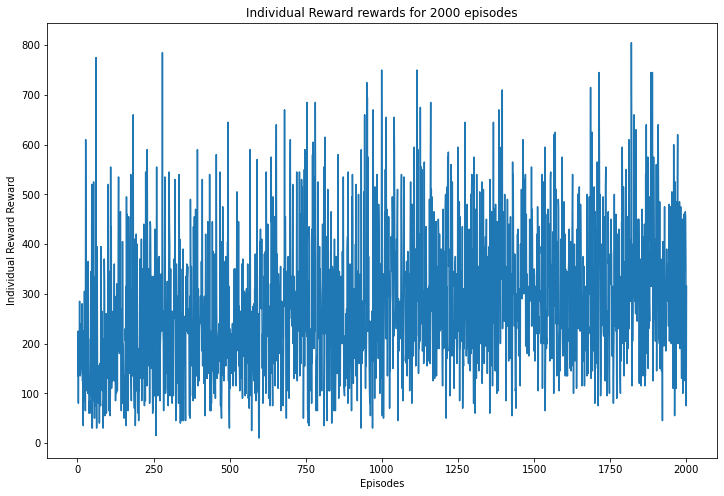

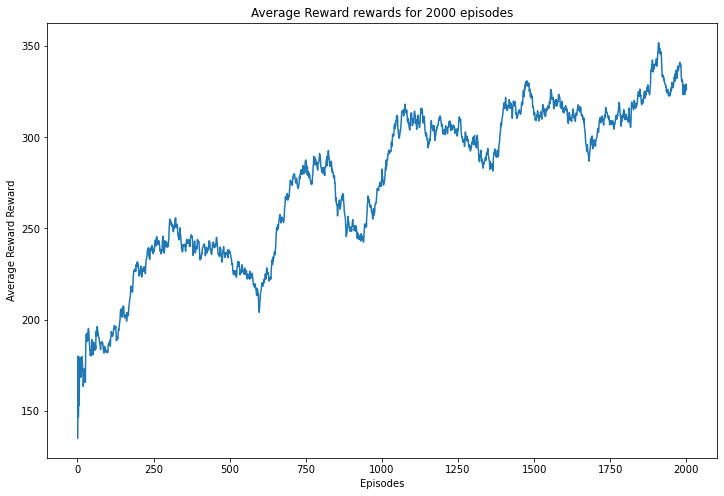

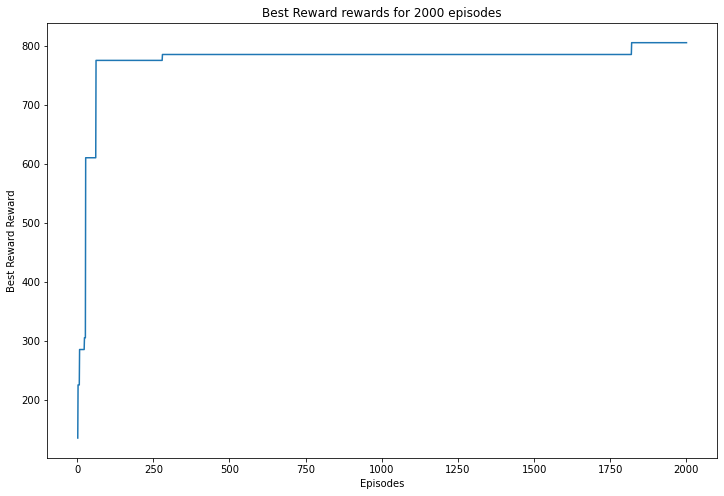

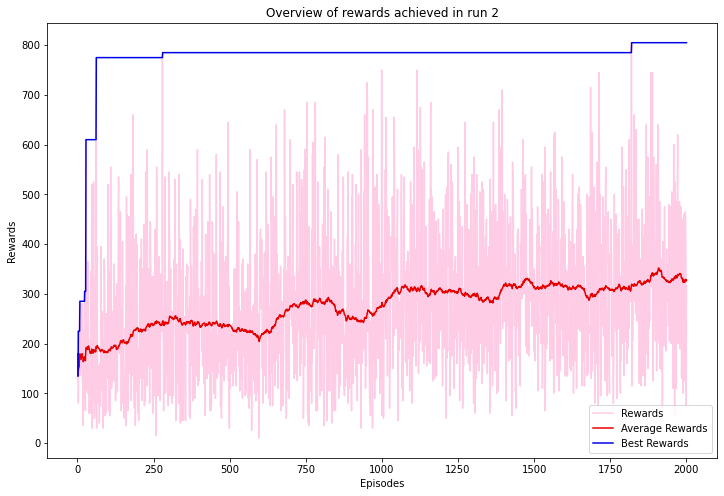

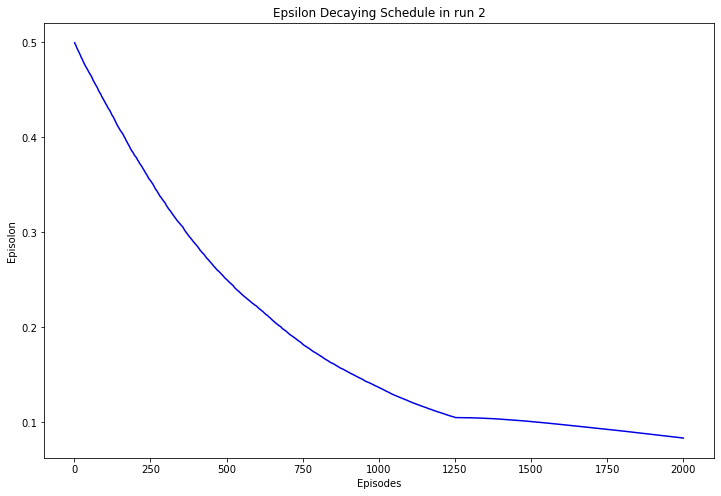

In [27]:
plot_rewards(re,ep+1,"Individual Reward",2)
plot_rewards(ave_re,ep+1,"Average Reward",2)
plot_rewards(best_re,ep+1,"Best Reward",2)
pretty_plot(re,ave_re,best_re,2)
plot_eps(epss,2)

# Run 3

In [25]:
N_EPDS = 2000  # total number of episodes to train the agent for

EPS_START = 0.3
EPS_FINL = 0.01

DIFF_P = 0.1
BREAK_TH = 100

EPS_DECAY = 180 * 500 # epd equals EPS_DECAY approximately 500 episodes, assuming 180 frames per episode, slowing start are 1000 episodes
DECAY_TH = 2 # start slowing decay at rate = 2, eps = 0.049.

EP_TH1 = 500 # threshold for updating learning rate
EP_TH2 = 1000
EP_TH3 = 1900
LR1 = 4e-5 # changed from 1e-5
LR2 = 1e-5 # changed from 6e-6
LR3 = 5e-6 # changed from 2e-6, 1e-6
LR4 = 1e-6 # changed from 1e-6

TGT_UPD_FRQ1 = 4000 # update approximately 10 episodes
TGT_UPD_FRQ2 = 8000 # change to maybe 15 episodes after 800 episodes
TGT_UPD_TH = 800


In [26]:
ave_re, re, best_re,ep, epss = train(env,main_model,target_model,buffer,device)
env.close()

  0%|          | 0/2000 [00:00<?, ?it/s]


highest running_average_reward of 50.0 achieved!

EP 0, curr_reward: 50.0, best_reward: 50.0, running_avg_reward: 50.0, curr_epsilon: 0.5

This episode takes 121 iterations


highest running_average_reward of 290.0 achieved!

EP 1, curr_reward: 530.0, best_reward: 530.0, running_avg_reward: 290.0, curr_epsilon: 0.5
EP 2, curr_reward: 185.0, best_reward: 530.0, running_avg_reward: 255.0, curr_epsilon: 0.5
EP 3, curr_reward: 130.0, best_reward: 530.0, running_avg_reward: 223.75, curr_epsilon: 0.5
EP 4, curr_reward: 210.0, best_reward: 530.0, running_avg_reward: 221.0, curr_epsilon: 0.5

Learning starts!

EP 5, curr_reward: 40.0, best_reward: 530.0, running_avg_reward: 190.833, curr_epsilon: 0.5
EP 6, curr_reward: 220.0, best_reward: 530.0, running_avg_reward: 195.0, curr_epsilon: 0.5
EP 7, curr_reward: 185.0, best_reward: 530.0, running_avg_reward: 193.75, curr_epsilon: 0.5
EP 8, curr_reward: 305.0, best_reward: 530.0, running_avg_reward: 206.111, curr_epsilon: 0.5
EP 9, curr_reward: 52

EP 83, curr_reward: 175.0, best_reward: 660.0, running_avg_reward: 268.214, curr_epsilon: 0.248
EP 84, curr_reward: 265.0, best_reward: 660.0, running_avg_reward: 268.176, curr_epsilon: 0.2473
EP 85, curr_reward: 135.0, best_reward: 660.0, running_avg_reward: 266.628, curr_epsilon: 0.2469
EP 86, curr_reward: 215.0, best_reward: 660.0, running_avg_reward: 266.034, curr_epsilon: 0.2464
EP 87, curr_reward: 530.0, best_reward: 660.0, running_avg_reward: 269.034, curr_epsilon: 0.2458
EP 88, curr_reward: 115.0, best_reward: 660.0, running_avg_reward: 267.303, curr_epsilon: 0.2455
EP 89, curr_reward: 340.0, best_reward: 660.0, running_avg_reward: 268.111, curr_epsilon: 0.2449
EP 90, curr_reward: 550.0, best_reward: 660.0, running_avg_reward: 271.209, curr_epsilon: 0.2438
EP 91, curr_reward: 310.0, best_reward: 660.0, running_avg_reward: 271.63, curr_epsilon: 0.2432
EP 92, curr_reward: 195.0, best_reward: 660.0, running_avg_reward: 270.806, curr_epsilon: 0.2426
EP 93, curr_reward: 330.0, best_

In [ ]:
plot_rewards(re,ep+1,"Individual Reward",3)
plot_rewards(ave_re,ep+1,"Average Reward",3)
plot_rewards(best_re,ep+1,"Best Reward",3)
pretty_plot(re,ave_re,best_re,3)
plot_eps(epss,3)

# Run 1 - clip the reward by dividing it by 100

In [25]:
N_EPDS = 2000  # total number of episodes to train the agent for

EPS_START = 1
EPS_FINL = 0.005

DIFF_P = 0.8
BREAK_TH = 1000

EPS_DECAY = 200 * 500 # epd equals EPS_DECAY approximately 500 episodes, assuming 200 frames per episode, slowing start are 1000 episodes
DECAY_TH = 2 # start slowing decay at rate = 2, eps = 0.14

EP_TH1 = 1000 # threshold for updating learning rate
EP_TH2 = 2000
EP_TH3 = 5000
LR1 = 2e-4 # changed from 1e-5
LR2 = 1e-4 # changed from 6e-6
LR3 = 8e-5 # changed from 2e-6, 1e-6
LR4 = 1e-5 # changed from 1e-6

TGT_UPD_FRQ1 = 400 # update approximately 4 episodes
TGT_UPD_FRQ2 = 1000 # change to maybe 10 episodes after 800 episodes
TGT_UPD_TH = 600



In [26]:
ave_re, re, best_re,ep, epss = train(env,main_model,target_model,buffer,device)
env.close()

  0%|          | 0/2000 [00:00<?, ?it/s]


highest running_average_reward of 0.45 achieved!

EP 0, curr_reward: 0.4, best_reward: 0.4, running_avg_reward: 0.45, curr_epsilon: 0.999

This episode takes 99 iterations

EP 1, curr_reward: 0.0, best_reward: 0.4, running_avg_reward: 0.25, curr_epsilon: 0.998
EP 2, curr_reward: 0.6, best_reward: 0.6, running_avg_reward: 0.367, curr_epsilon: 0.9964

highest running_average_reward of 0.662 achieved!

EP 3, curr_reward: 1.6, best_reward: 1.6, running_avg_reward: 0.662, curr_epsilon: 0.9948
EP 4, curr_reward: 0.6, best_reward: 1.6, running_avg_reward: 0.65, curr_epsilon: 0.9934
EP 5, curr_reward: 0.4, best_reward: 1.6, running_avg_reward: 0.608, curr_epsilon: 0.9925
EP 6, curr_reward: 0.2, best_reward: 1.6, running_avg_reward: 0.557, curr_epsilon: 0.9916
EP 7, curr_reward: 1.4, best_reward: 1.6, running_avg_reward: 0.656, curr_epsilon: 0.9901

Learning starts!

EP 8, curr_reward: 0.4, best_reward: 1.6, running_avg_reward: 0.628, curr_epsilon: 0.9892

highest running_average_reward of 0.6

EP 79, curr_reward: 0.7, best_reward: 5.0, running_avg_reward: 1.124, curr_epsilon: 0.8859
EP 80, curr_reward: 1.6, best_reward: 5.0, running_avg_reward: 1.131, curr_epsilon: 0.8842
EP 81, curr_reward: 1.4, best_reward: 5.0, running_avg_reward: 1.134, curr_epsilon: 0.8828
EP 82, curr_reward: 0.8, best_reward: 5.0, running_avg_reward: 1.13, curr_epsilon: 0.8814
EP 83, curr_reward: 0.1, best_reward: 5.0, running_avg_reward: 1.118, curr_epsilon: 0.8803
EP 84, curr_reward: 0.6, best_reward: 5.0, running_avg_reward: 1.112, curr_epsilon: 0.8788
EP 85, curr_reward: 0.8, best_reward: 5.0, running_avg_reward: 1.108, curr_epsilon: 0.8774
EP 86, curr_reward: 1.2, best_reward: 5.0, running_avg_reward: 1.11, curr_epsilon: 0.8763
EP 87, curr_reward: 0.5, best_reward: 5.0, running_avg_reward: 1.103, curr_epsilon: 0.8755
EP 88, curr_reward: 0.6, best_reward: 5.0, running_avg_reward: 1.097, curr_epsilon: 0.8744
EP 89, curr_reward: 4.2, best_reward: 5.0, running_avg_reward: 1.131, curr_epsilon: 0.8719
E

EP 154, curr_reward: 1.0, best_reward: 5.1, running_avg_reward: 1.411, curr_epsilon: 0.7802
EP 155, curr_reward: 1.5, best_reward: 5.1, running_avg_reward: 1.421, curr_epsilon: 0.7783

highest running_average_reward of 1.433 achieved!

EP 156, curr_reward: 1.8, best_reward: 5.1, running_avg_reward: 1.433, curr_epsilon: 0.7766

highest running_average_reward of 1.437 achieved!

EP 157, curr_reward: 0.6, best_reward: 5.1, running_avg_reward: 1.437, curr_epsilon: 0.7754
EP 158, curr_reward: 0.2, best_reward: 5.1, running_avg_reward: 1.427, curr_epsilon: 0.7746
EP 159, curr_reward: 1.4, best_reward: 5.1, running_avg_reward: 1.434, curr_epsilon: 0.7735

highest running_average_reward of 1.454 achieved!

EP 160, curr_reward: 3.2, best_reward: 5.1, running_avg_reward: 1.454, curr_epsilon: 0.7714

highest running_average_reward of 1.464 achieved!

EP 161, curr_reward: 1.4, best_reward: 5.1, running_avg_reward: 1.464, curr_epsilon: 0.7699

highest running_average_reward of 1.479 achieved!

EP 1

EP 231, curr_reward: 0.5, best_reward: 5.1, running_avg_reward: 1.616, curr_epsilon: 0.6767
EP 232, curr_reward: 2.9, best_reward: 5.1, running_avg_reward: 1.64, curr_epsilon: 0.6746
EP 233, curr_reward: 2.2, best_reward: 5.1, running_avg_reward: 1.641, curr_epsilon: 0.6728
EP 234, curr_reward: 1.0, best_reward: 5.1, running_avg_reward: 1.636, curr_epsilon: 0.672
EP 235, curr_reward: 0.4, best_reward: 5.1, running_avg_reward: 1.632, curr_epsilon: 0.671
EP 236, curr_reward: 0.5, best_reward: 5.1, running_avg_reward: 1.606, curr_epsilon: 0.6703
EP 237, curr_reward: 1.0, best_reward: 5.1, running_avg_reward: 1.603, curr_epsilon: 0.6697
EP 238, curr_reward: 1.2, best_reward: 5.1, running_avg_reward: 1.609, curr_epsilon: 0.6681
EP 239, curr_reward: 1.8, best_reward: 5.1, running_avg_reward: 1.576, curr_epsilon: 0.6666
EP 240, curr_reward: 0.4, best_reward: 5.1, running_avg_reward: 1.568, curr_epsilon: 0.6658
EP 241, curr_reward: 0.8, best_reward: 5.1, running_avg_reward: 1.575, curr_epsilon

EP 320, curr_reward: 0.5, best_reward: 5.4, running_avg_reward: 1.547, curr_epsilon: 0.5725
EP 321, curr_reward: 0.7, best_reward: 5.4, running_avg_reward: 1.547, curr_epsilon: 0.5716
EP 322, curr_reward: 5.4, best_reward: 5.4, running_avg_reward: 1.574, curr_epsilon: 0.5701
EP 323, curr_reward: 0.5, best_reward: 5.4, running_avg_reward: 1.551, curr_epsilon: 0.5696
EP 324, curr_reward: 1.3, best_reward: 5.4, running_avg_reward: 1.561, curr_epsilon: 0.5687
EP 325, curr_reward: 0.4, best_reward: 5.4, running_avg_reward: 1.554, curr_epsilon: 0.5681

This episode takes 100 iterations

EP 326, curr_reward: 3.0, best_reward: 5.4, running_avg_reward: 1.579, curr_epsilon: 0.5668
EP 327, curr_reward: 1.1, best_reward: 5.4, running_avg_reward: 1.576, curr_epsilon: 0.5659
EP 328, curr_reward: 3.9, best_reward: 5.4, running_avg_reward: 1.612, curr_epsilon: 0.5641
EP 329, curr_reward: 0.6, best_reward: 5.4, running_avg_reward: 1.588, curr_epsilon: 0.5635
EP 330, curr_reward: 4.5, best_reward: 5.4, 

EP 397, curr_reward: 2.4, best_reward: 7.1, running_avg_reward: 1.799, curr_epsilon: 0.4935
EP 398, curr_reward: 1.2, best_reward: 7.1, running_avg_reward: 1.795, curr_epsilon: 0.4927
EP 399, curr_reward: 0.7, best_reward: 7.1, running_avg_reward: 1.79, curr_epsilon: 0.492
EP 400, curr_reward: 0.9, best_reward: 7.1, running_avg_reward: 1.787, curr_epsilon: 0.4914

This episode takes 138 iterations

EP 401, curr_reward: 1.2, best_reward: 7.1, running_avg_reward: 1.789, curr_epsilon: 0.4906
EP 402, curr_reward: 1.1, best_reward: 7.1, running_avg_reward: 1.79, curr_epsilon: 0.4896
EP 403, curr_reward: 0.8, best_reward: 7.1, running_avg_reward: 1.768, curr_epsilon: 0.4888
EP 404, curr_reward: 1.8, best_reward: 7.1, running_avg_reward: 1.773, curr_epsilon: 0.4877
EP 405, curr_reward: 2.4, best_reward: 7.1, running_avg_reward: 1.789, curr_epsilon: 0.4864
EP 406, curr_reward: 2.0, best_reward: 7.1, running_avg_reward: 1.798, curr_epsilon: 0.4853
EP 407, curr_reward: 3.7, best_reward: 7.1, run

EP 485, curr_reward: 1.7, best_reward: 7.1, running_avg_reward: 1.516, curr_epsilon: 0.4209
EP 486, curr_reward: 0.5, best_reward: 7.1, running_avg_reward: 1.51, curr_epsilon: 0.4203
EP 487, curr_reward: 3.4, best_reward: 7.1, running_avg_reward: 1.515, curr_epsilon: 0.419
EP 488, curr_reward: 0.5, best_reward: 7.1, running_avg_reward: 1.496, curr_epsilon: 0.4183
EP 489, curr_reward: 0.7, best_reward: 7.1, running_avg_reward: 1.493, curr_epsilon: 0.4179
EP 490, curr_reward: 1.0, best_reward: 7.1, running_avg_reward: 1.477, curr_epsilon: 0.4176
EP 491, curr_reward: 1.3, best_reward: 7.1, running_avg_reward: 1.488, curr_epsilon: 0.4168
EP 492, curr_reward: 1.2, best_reward: 7.1, running_avg_reward: 1.498, curr_epsilon: 0.416
EP 493, curr_reward: 3.4, best_reward: 7.1, running_avg_reward: 1.53, curr_epsilon: 0.4151
EP 494, curr_reward: 1.3, best_reward: 7.1, running_avg_reward: 1.525, curr_epsilon: 0.4144
EP 495, curr_reward: 0.8, best_reward: 7.1, running_avg_reward: 1.528, curr_epsilon:

EP 574, curr_reward: 2.9, best_reward: 7.7, running_avg_reward: 1.681, curr_epsilon: 0.3552
EP 575, curr_reward: 1.0, best_reward: 7.7, running_avg_reward: 1.676, curr_epsilon: 0.3546

This episode takes 196 iterations

EP 576, curr_reward: 2.4, best_reward: 7.7, running_avg_reward: 1.67, curr_epsilon: 0.3538
EP 577, curr_reward: 2.8, best_reward: 7.7, running_avg_reward: 1.692, curr_epsilon: 0.3531
EP 578, curr_reward: 2.9, best_reward: 7.7, running_avg_reward: 1.716, curr_epsilon: 0.3523
EP 579, curr_reward: 0.5, best_reward: 7.7, running_avg_reward: 1.704, curr_epsilon: 0.3518
EP 580, curr_reward: 4.9, best_reward: 7.7, running_avg_reward: 1.731, curr_epsilon: 0.351
EP 581, curr_reward: 2.1, best_reward: 7.7, running_avg_reward: 1.738, curr_epsilon: 0.3501
EP 582, curr_reward: 1.2, best_reward: 7.7, running_avg_reward: 1.741, curr_epsilon: 0.3495
EP 583, curr_reward: 1.7, best_reward: 7.7, running_avg_reward: 1.725, curr_epsilon: 0.349
EP 584, curr_reward: 1.2, best_reward: 7.7, run

EP 657, curr_reward: 2.2, best_reward: 7.7, running_avg_reward: 1.915, curr_epsilon: 0.2984
EP 658, curr_reward: 1.5, best_reward: 7.7, running_avg_reward: 1.925, curr_epsilon: 0.2979

highest running_average_reward of 1.987 achieved!

EP 659, curr_reward: 7.4, best_reward: 7.7, running_avg_reward: 1.987, curr_epsilon: 0.2969

highest running_average_reward of 2.002 achieved!

EP 660, curr_reward: 2.5, best_reward: 7.7, running_avg_reward: 2.002, curr_epsilon: 0.2963

highest running_average_reward of 2.022 achieved!

EP 661, curr_reward: 3.6, best_reward: 7.7, running_avg_reward: 2.022, curr_epsilon: 0.2955

highest running_average_reward of 2.028 achieved!

EP 662, curr_reward: 1.7, best_reward: 7.7, running_avg_reward: 2.028, curr_epsilon: 0.2948
EP 663, curr_reward: 1.2, best_reward: 7.7, running_avg_reward: 2.007, curr_epsilon: 0.2941

highest running_average_reward of 2.033 achieved!

EP 664, curr_reward: 4.4, best_reward: 7.7, running_avg_reward: 2.033, curr_epsilon: 0.2933
EP 6

EP 738, curr_reward: 0.7, best_reward: 7.7, running_avg_reward: 2.162, curr_epsilon: 0.2532
EP 739, curr_reward: 1.6, best_reward: 7.7, running_avg_reward: 2.137, curr_epsilon: 0.2527
EP 740, curr_reward: 1.8, best_reward: 7.7, running_avg_reward: 2.137, curr_epsilon: 0.2521
EP 741, curr_reward: 2.2, best_reward: 7.7, running_avg_reward: 2.141, curr_epsilon: 0.2514
EP 742, curr_reward: 0.8, best_reward: 7.7, running_avg_reward: 2.141, curr_epsilon: 0.2511
EP 743, curr_reward: 2.1, best_reward: 7.7, running_avg_reward: 2.137, curr_epsilon: 0.2505
EP 744, curr_reward: 0.7, best_reward: 7.7, running_avg_reward: 2.122, curr_epsilon: 0.2502
EP 745, curr_reward: 1.6, best_reward: 7.7, running_avg_reward: 2.085, curr_epsilon: 0.2497
EP 746, curr_reward: 5.0, best_reward: 7.7, running_avg_reward: 2.12, curr_epsilon: 0.2489
EP 747, curr_reward: 1.5, best_reward: 7.7, running_avg_reward: 2.107, curr_epsilon: 0.2483
EP 748, curr_reward: 1.8, best_reward: 7.7, running_avg_reward: 2.125, curr_epsil

EP 826, curr_reward: 1.0, best_reward: 7.7, running_avg_reward: 1.676, curr_epsilon: 0.2149
EP 827, curr_reward: 1.0, best_reward: 7.7, running_avg_reward: 1.675, curr_epsilon: 0.2146
EP 828, curr_reward: 1.8, best_reward: 7.7, running_avg_reward: 1.622, curr_epsilon: 0.2139
EP 829, curr_reward: 0.2, best_reward: 7.7, running_avg_reward: 1.614, curr_epsilon: 0.2138
EP 830, curr_reward: 1.8, best_reward: 7.7, running_avg_reward: 1.624, curr_epsilon: 0.2133
EP 831, curr_reward: 2.0, best_reward: 7.7, running_avg_reward: 1.632, curr_epsilon: 0.2128
EP 832, curr_reward: 0.8, best_reward: 7.7, running_avg_reward: 1.638, curr_epsilon: 0.2124
EP 833, curr_reward: 1.4, best_reward: 7.7, running_avg_reward: 1.639, curr_epsilon: 0.2121
EP 834, curr_reward: 0.2, best_reward: 7.7, running_avg_reward: 1.615, curr_epsilon: 0.2119
EP 835, curr_reward: 1.0, best_reward: 7.7, running_avg_reward: 1.603, curr_epsilon: 0.2116
EP 836, curr_reward: 0.4, best_reward: 7.7, running_avg_reward: 1.587, curr_epsi

EP 915, curr_reward: 2.0, best_reward: 7.7, running_avg_reward: 1.543, curr_epsilon: 0.1808
EP 916, curr_reward: 2.0, best_reward: 7.7, running_avg_reward: 1.555, curr_epsilon: 0.1803
EP 917, curr_reward: 0.5, best_reward: 7.7, running_avg_reward: 1.557, curr_epsilon: 0.1801
EP 918, curr_reward: 3.3, best_reward: 7.7, running_avg_reward: 1.576, curr_epsilon: 0.1796
EP 919, curr_reward: 0.2, best_reward: 7.7, running_avg_reward: 1.573, curr_epsilon: 0.1794
EP 920, curr_reward: 1.3, best_reward: 7.7, running_avg_reward: 1.569, curr_epsilon: 0.179
EP 921, curr_reward: 0.3, best_reward: 7.7, running_avg_reward: 1.549, curr_epsilon: 0.1789
EP 922, curr_reward: 3.4, best_reward: 7.7, running_avg_reward: 1.581, curr_epsilon: 0.1785
EP 923, curr_reward: 6.0, best_reward: 7.7, running_avg_reward: 1.637, curr_epsilon: 0.178
EP 924, curr_reward: 2.9, best_reward: 7.7, running_avg_reward: 1.648, curr_epsilon: 0.1773
EP 925, curr_reward: 1.0, best_reward: 7.7, running_avg_reward: 1.626, curr_epsilo

KeyboardInterrupt: 

# Run 2

In [27]:
N_EPDS = 2000  # total number of episodes to train the agent for

DIFF = 0
EPS_START = 0.5
EPS_FINL = 0.005

EPS_DECAY = 200 * 500 # epd equals EPS_DECAY approximately 500 episodes, assuming 200 frames per episode, slowing start are 1000 episodes
DECAY_TH = 2 # start slowing decay at rate = 2, eps = 0.072.

DIFF_P = 0.3
BREAK_TH = 500

EP_TH1 = 800 # threshold for updating learning rate
EP_TH2 = 1600
EP_TH3 = 5000
LR1 = 2e-5 # changed from 1e-5
LR2 = 8e-6 # changed from 6e-6
LR3 = 4e-6 # changed from 2e-6, 1e-6
LR4 = 1e-5 # changed from 1e-6

TGT_UPD_FRQ1 = 2000 # update approximately 10 episodes
TGT_UPD_FRQ2 = 4000 # change to maybe 18 episodes after 800 episodes
TGT_UPD_TH = 800
#buffer = ReplayBuffer(MEM_CAP)

## with huber loss

In [25]:
ave_re, re, best_re,ep, epss = train(env,main_model,target_model,buffer,device)
env.close()

  0%|          | 0/2000 [00:00<?, ?it/s]


highest running_average_reward of 1.1 achieved!

EP 0, curr_reward: 1.1, best_reward: 1.1, running_avg_reward: 1.1, curr_epsilon: 0.4991

This episode takes 174 iterations


highest running_average_reward of 1.55 achieved!

EP 1, curr_reward: 2.0, best_reward: 2.0, running_avg_reward: 1.55, curr_epsilon: 0.498
EP 2, curr_reward: 1.0, best_reward: 2.0, running_avg_reward: 1.383, curr_epsilon: 0.497
EP 3, curr_reward: 1.9, best_reward: 2.0, running_avg_reward: 1.5, curr_epsilon: 0.4959

Learning starts!

EP 4, curr_reward: 1.7, best_reward: 2.0, running_avg_reward: 1.54, curr_epsilon: 0.4946
EP 5, curr_reward: 1.2, best_reward: 2.0, running_avg_reward: 1.483, curr_epsilon: 0.4941
EP 6, curr_reward: 0.4, best_reward: 2.0, running_avg_reward: 1.321, curr_epsilon: 0.4935
EP 7, curr_reward: 0.3, best_reward: 2.0, running_avg_reward: 1.194, curr_epsilon: 0.4931
EP 8, curr_reward: 0.7, best_reward: 2.0, running_avg_reward: 1.133, curr_epsilon: 0.4923
EP 9, curr_reward: 0.4, best_reward: 2.0, 

EP 88, curr_reward: 2.1, best_reward: 5.5, running_avg_reward: 1.229, curr_epsilon: 0.4317
EP 89, curr_reward: 1.4, best_reward: 5.5, running_avg_reward: 1.231, curr_epsilon: 0.431
EP 90, curr_reward: 1.8, best_reward: 5.5, running_avg_reward: 1.237, curr_epsilon: 0.4301
EP 91, curr_reward: 1.2, best_reward: 5.5, running_avg_reward: 1.237, curr_epsilon: 0.4297
EP 92, curr_reward: 2.4, best_reward: 5.5, running_avg_reward: 1.249, curr_epsilon: 0.4287
EP 93, curr_reward: 0.8, best_reward: 5.5, running_avg_reward: 1.244, curr_epsilon: 0.428
EP 94, curr_reward: 0.8, best_reward: 5.5, running_avg_reward: 1.239, curr_epsilon: 0.4273
EP 95, curr_reward: 2.2, best_reward: 5.5, running_avg_reward: 1.249, curr_epsilon: 0.4261
EP 96, curr_reward: 1.8, best_reward: 5.5, running_avg_reward: 1.255, curr_epsilon: 0.4254
EP 97, curr_reward: 3.6, best_reward: 5.5, running_avg_reward: 1.279, curr_epsilon: 0.4243
EP 98, curr_reward: 1.0, best_reward: 5.5, running_avg_reward: 1.275, curr_epsilon: 0.4237
E


highest running_average_reward of 1.599 achieved!

EP 176, curr_reward: 4.1, best_reward: 5.6, running_avg_reward: 1.599, curr_epsilon: 0.3665
EP 177, curr_reward: 1.0, best_reward: 5.6, running_avg_reward: 1.592, curr_epsilon: 0.366
EP 178, curr_reward: 1.0, best_reward: 5.6, running_avg_reward: 1.592, curr_epsilon: 0.3655
EP 179, curr_reward: 0.5, best_reward: 5.6, running_avg_reward: 1.581, curr_epsilon: 0.3651
EP 180, curr_reward: 1.6, best_reward: 5.6, running_avg_reward: 1.59, curr_epsilon: 0.3643
EP 181, curr_reward: 2.4, best_reward: 5.6, running_avg_reward: 1.588, curr_epsilon: 0.3635

highest running_average_reward of 1.605 achieved!

EP 182, curr_reward: 2.8, best_reward: 5.6, running_avg_reward: 1.605, curr_epsilon: 0.3627
EP 183, curr_reward: 0.6, best_reward: 5.6, running_avg_reward: 1.596, curr_epsilon: 0.3622

highest running_average_reward of 1.608 achieved!

EP 184, curr_reward: 1.8, best_reward: 5.6, running_avg_reward: 1.608, curr_epsilon: 0.3616

highest running_a

EP 252, curr_reward: 0.6, best_reward: 6.9, running_avg_reward: 1.848, curr_epsilon: 0.3171
EP 253, curr_reward: 3.5, best_reward: 6.9, running_avg_reward: 1.87, curr_epsilon: 0.3161
EP 254, curr_reward: 2.2, best_reward: 6.9, running_avg_reward: 1.869, curr_epsilon: 0.3154

highest running_average_reward of 1.916 achieved!

EP 255, curr_reward: 5.2, best_reward: 6.9, running_avg_reward: 1.916, curr_epsilon: 0.3146

highest running_average_reward of 1.922 achieved!

EP 256, curr_reward: 2.4, best_reward: 6.9, running_avg_reward: 1.922, curr_epsilon: 0.3139
EP 257, curr_reward: 3.9, best_reward: 6.9, running_avg_reward: 1.922, curr_epsilon: 0.3131
EP 258, curr_reward: 0.2, best_reward: 6.9, running_avg_reward: 1.914, curr_epsilon: 0.3128
EP 259, curr_reward: 0.5, best_reward: 6.9, running_avg_reward: 1.9, curr_epsilon: 0.3123
EP 260, curr_reward: 2.4, best_reward: 6.9, running_avg_reward: 1.908, curr_epsilon: 0.3115
EP 261, curr_reward: 1.2, best_reward: 6.9, running_avg_reward: 1.899, 

EP 337, curr_reward: 0.4, best_reward: 6.9, running_avg_reward: 1.791, curr_epsilon: 0.2697
EP 338, curr_reward: 1.8, best_reward: 6.9, running_avg_reward: 1.804, curr_epsilon: 0.2689
EP 339, curr_reward: 1.5, best_reward: 6.9, running_avg_reward: 1.801, curr_epsilon: 0.2684
EP 340, curr_reward: 0.6, best_reward: 6.9, running_avg_reward: 1.804, curr_epsilon: 0.2681
EP 341, curr_reward: 1.7, best_reward: 6.9, running_avg_reward: 1.786, curr_epsilon: 0.2674
EP 342, curr_reward: 1.4, best_reward: 6.9, running_avg_reward: 1.76, curr_epsilon: 0.267
EP 343, curr_reward: 1.2, best_reward: 6.9, running_avg_reward: 1.724, curr_epsilon: 0.2665
EP 344, curr_reward: 0.8, best_reward: 6.9, running_avg_reward: 1.72, curr_epsilon: 0.2661
EP 345, curr_reward: 4.0, best_reward: 6.9, running_avg_reward: 1.75, curr_epsilon: 0.2655
EP 346, curr_reward: 1.6, best_reward: 6.9, running_avg_reward: 1.749, curr_epsilon: 0.2649
EP 347, curr_reward: 1.5, best_reward: 6.9, running_avg_reward: 1.75, curr_epsilon: 

EP 426, curr_reward: 5.2, best_reward: 7.0, running_avg_reward: 1.562, curr_epsilon: 0.2284
EP 427, curr_reward: 0.4, best_reward: 7.0, running_avg_reward: 1.541, curr_epsilon: 0.228
EP 428, curr_reward: 0.8, best_reward: 7.0, running_avg_reward: 1.538, curr_epsilon: 0.2278
EP 429, curr_reward: 1.8, best_reward: 7.0, running_avg_reward: 1.54, curr_epsilon: 0.2274
EP 430, curr_reward: 0.5, best_reward: 7.0, running_avg_reward: 1.52, curr_epsilon: 0.2272
EP 431, curr_reward: 1.0, best_reward: 7.0, running_avg_reward: 1.514, curr_epsilon: 0.227
EP 432, curr_reward: 1.0, best_reward: 7.0, running_avg_reward: 1.516, curr_epsilon: 0.2266
EP 433, curr_reward: 0.4, best_reward: 7.0, running_avg_reward: 1.502, curr_epsilon: 0.2264
EP 434, curr_reward: 1.4, best_reward: 7.0, running_avg_reward: 1.513, curr_epsilon: 0.2259
EP 435, curr_reward: 0.8, best_reward: 7.0, running_avg_reward: 1.518, curr_epsilon: 0.2257
EP 436, curr_reward: 4.7, best_reward: 7.0, running_avg_reward: 1.56, curr_epsilon: 

EP 515, curr_reward: 1.4, best_reward: 7.0, running_avg_reward: 1.759, curr_epsilon: 0.1936
EP 516, curr_reward: 1.4, best_reward: 7.0, running_avg_reward: 1.748, curr_epsilon: 0.1932
EP 517, curr_reward: 1.0, best_reward: 7.0, running_avg_reward: 1.755, curr_epsilon: 0.1929
EP 518, curr_reward: 1.6, best_reward: 7.0, running_avg_reward: 1.755, curr_epsilon: 0.1926
EP 519, curr_reward: 1.0, best_reward: 7.0, running_avg_reward: 1.757, curr_epsilon: 0.1923
EP 520, curr_reward: 0.6, best_reward: 7.0, running_avg_reward: 1.749, curr_epsilon: 0.1921
EP 521, curr_reward: 4.4, best_reward: 7.0, running_avg_reward: 1.786, curr_epsilon: 0.1915
EP 522, curr_reward: 2.0, best_reward: 7.0, running_avg_reward: 1.785, curr_epsilon: 0.1911
EP 523, curr_reward: 1.9, best_reward: 7.0, running_avg_reward: 1.79, curr_epsilon: 0.1905
EP 524, curr_reward: 2.8, best_reward: 7.0, running_avg_reward: 1.808, curr_epsilon: 0.19
EP 525, curr_reward: 2.8, best_reward: 7.0, running_avg_reward: 1.828, curr_epsilon

EP 603, curr_reward: 2.8, best_reward: 7.0, running_avg_reward: 1.776, curr_epsilon: 0.1628
EP 604, curr_reward: 0.8, best_reward: 7.0, running_avg_reward: 1.777, curr_epsilon: 0.1626
EP 605, curr_reward: 2.0, best_reward: 7.0, running_avg_reward: 1.782, curr_epsilon: 0.1622
EP 606, curr_reward: 3.4, best_reward: 7.0, running_avg_reward: 1.764, curr_epsilon: 0.1618
EP 607, curr_reward: 0.5, best_reward: 7.0, running_avg_reward: 1.745, curr_epsilon: 0.1616
EP 608, curr_reward: 1.3, best_reward: 7.0, running_avg_reward: 1.754, curr_epsilon: 0.1613
EP 609, curr_reward: 1.8, best_reward: 7.0, running_avg_reward: 1.771, curr_epsilon: 0.1611
EP 610, curr_reward: 1.2, best_reward: 7.0, running_avg_reward: 1.759, curr_epsilon: 0.1609
EP 611, curr_reward: 0.6, best_reward: 7.0, running_avg_reward: 1.723, curr_epsilon: 0.1607
EP 612, curr_reward: 2.3, best_reward: 7.0, running_avg_reward: 1.74, curr_epsilon: 0.1602
EP 613, curr_reward: 1.9, best_reward: 7.0, running_avg_reward: 1.745, curr_epsil

EP 692, curr_reward: 1.6, best_reward: 7.0, running_avg_reward: 1.612, curr_epsilon: 0.1394
EP 693, curr_reward: 0.6, best_reward: 7.0, running_avg_reward: 1.598, curr_epsilon: 0.1392
EP 694, curr_reward: 1.2, best_reward: 7.0, running_avg_reward: 1.599, curr_epsilon: 0.1389
EP 695, curr_reward: 4.7, best_reward: 7.0, running_avg_reward: 1.631, curr_epsilon: 0.1384
EP 696, curr_reward: 1.4, best_reward: 7.0, running_avg_reward: 1.618, curr_epsilon: 0.1381
EP 697, curr_reward: 0.8, best_reward: 7.0, running_avg_reward: 1.58, curr_epsilon: 0.1379
EP 698, curr_reward: 4.2, best_reward: 7.0, running_avg_reward: 1.605, curr_epsilon: 0.1376
EP 699, curr_reward: 1.5, best_reward: 7.0, running_avg_reward: 1.592, curr_epsilon: 0.1373
EP 700, curr_reward: 1.5, best_reward: 7.0, running_avg_reward: 1.596, curr_epsilon: 0.1371

This episode takes 195 iterations

EP 701, curr_reward: 0.5, best_reward: 7.0, running_avg_reward: 1.574, curr_epsilon: 0.1369
EP 702, curr_reward: 2.5, best_reward: 7.0, r

EP 780, curr_reward: 2.4, best_reward: 7.0, running_avg_reward: 1.937, curr_epsilon: 0.1165
EP 781, curr_reward: 0.6, best_reward: 7.0, running_avg_reward: 1.939, curr_epsilon: 0.1163
EP 782, curr_reward: 2.2, best_reward: 7.0, running_avg_reward: 1.956, curr_epsilon: 0.1161
EP 783, curr_reward: 1.0, best_reward: 7.0, running_avg_reward: 1.958, curr_epsilon: 0.116

highest running_average_reward of 1.969 achieved!

EP 784, curr_reward: 2.5, best_reward: 7.0, running_avg_reward: 1.969, curr_epsilon: 0.1157

highest running_average_reward of 1.986 achieved!

EP 785, curr_reward: 3.0, best_reward: 7.0, running_avg_reward: 1.986, curr_epsilon: 0.1154
EP 786, curr_reward: 0.9, best_reward: 7.0, running_avg_reward: 1.984, curr_epsilon: 0.1151
EP 787, curr_reward: 1.0, best_reward: 7.0, running_avg_reward: 1.943, curr_epsilon: 0.115
EP 788, curr_reward: 1.1, best_reward: 7.0, running_avg_reward: 1.917, curr_epsilon: 0.1148
EP 789, curr_reward: 0.6, best_reward: 7.0, running_avg_reward: 1.908,

EP 862, curr_reward: 1.0, best_reward: 9.4, running_avg_reward: 1.961, curr_epsilon: 0.0989
EP 863, curr_reward: 0.6, best_reward: 9.4, running_avg_reward: 1.956, curr_epsilon: 0.0988
EP 864, curr_reward: 1.5, best_reward: 9.4, running_avg_reward: 1.936, curr_epsilon: 0.0987
EP 865, curr_reward: 1.3, best_reward: 9.4, running_avg_reward: 1.934, curr_epsilon: 0.0985
EP 866, curr_reward: 2.0, best_reward: 9.4, running_avg_reward: 1.918, curr_epsilon: 0.0982
EP 867, curr_reward: 2.0, best_reward: 9.4, running_avg_reward: 1.92, curr_epsilon: 0.0981
EP 868, curr_reward: 1.0, best_reward: 9.4, running_avg_reward: 1.916, curr_epsilon: 0.0979
EP 869, curr_reward: 2.2, best_reward: 9.4, running_avg_reward: 1.915, curr_epsilon: 0.0977
EP 870, curr_reward: 0.9, best_reward: 9.4, running_avg_reward: 1.909, curr_epsilon: 0.0976
EP 871, curr_reward: 1.2, best_reward: 9.4, running_avg_reward: 1.898, curr_epsilon: 0.0975
EP 872, curr_reward: 4.7, best_reward: 9.4, running_avg_reward: 1.917, curr_epsil

EP 951, curr_reward: 1.2, best_reward: 9.4, running_avg_reward: 2.153, curr_epsilon: 0.0823
EP 952, curr_reward: 1.5, best_reward: 9.4, running_avg_reward: 2.156, curr_epsilon: 0.0821
EP 953, curr_reward: 1.6, best_reward: 9.4, running_avg_reward: 2.164, curr_epsilon: 0.082
EP 954, curr_reward: 0.2, best_reward: 9.4, running_avg_reward: 2.145, curr_epsilon: 0.0819
EP 955, curr_reward: 0.5, best_reward: 9.4, running_avg_reward: 2.134, curr_epsilon: 0.0818
EP 956, curr_reward: 3.2, best_reward: 9.4, running_avg_reward: 2.163, curr_epsilon: 0.0816
EP 957, curr_reward: 0.6, best_reward: 9.4, running_avg_reward: 2.155, curr_epsilon: 0.0815
EP 958, curr_reward: 0.7, best_reward: 9.4, running_avg_reward: 2.158, curr_epsilon: 0.0814
EP 959, curr_reward: 2.6, best_reward: 9.4, running_avg_reward: 2.128, curr_epsilon: 0.0812
EP 960, curr_reward: 1.6, best_reward: 9.4, running_avg_reward: 2.114, curr_epsilon: 0.081
EP 961, curr_reward: 2.6, best_reward: 9.4, running_avg_reward: 2.127, curr_epsilo

EP 1037, curr_reward: 2.8, best_reward: 9.4, running_avg_reward: 2.109, curr_epsilon: 0.0719
EP 1038, curr_reward: 1.6, best_reward: 9.4, running_avg_reward: 2.106, curr_epsilon: 0.0719
EP 1039, curr_reward: 0.8, best_reward: 9.4, running_avg_reward: 2.098, curr_epsilon: 0.0719
EP 1040, curr_reward: 5.3, best_reward: 9.4, running_avg_reward: 2.128, curr_epsilon: 0.0719
EP 1041, curr_reward: 2.4, best_reward: 9.4, running_avg_reward: 2.137, curr_epsilon: 0.0719
EP 1042, curr_reward: 0.6, best_reward: 9.4, running_avg_reward: 2.141, curr_epsilon: 0.0719
EP 1043, curr_reward: 2.6, best_reward: 9.4, running_avg_reward: 2.136, curr_epsilon: 0.0719
EP 1044, curr_reward: 1.7, best_reward: 9.4, running_avg_reward: 2.086, curr_epsilon: 0.0719
EP 1045, curr_reward: 2.0, best_reward: 9.4, running_avg_reward: 2.078, curr_epsilon: 0.0719
EP 1046, curr_reward: 2.5, best_reward: 9.4, running_avg_reward: 2.07, curr_epsilon: 0.0718
EP 1047, curr_reward: 1.5, best_reward: 9.4, running_avg_reward: 2.073,

EP 1125, curr_reward: 1.8, best_reward: 9.4, running_avg_reward: 2.085, curr_epsilon: 0.0705

This episode takes 222 iterations

EP 1126, curr_reward: 1.8, best_reward: 9.4, running_avg_reward: 2.095, curr_epsilon: 0.0705
EP 1127, curr_reward: 0.5, best_reward: 9.4, running_avg_reward: 2.085, curr_epsilon: 0.0704
EP 1128, curr_reward: 2.6, best_reward: 9.4, running_avg_reward: 2.088, curr_epsilon: 0.0704
EP 1129, curr_reward: 4.6, best_reward: 9.4, running_avg_reward: 2.126, curr_epsilon: 0.0704
EP 1130, curr_reward: 3.0, best_reward: 9.4, running_avg_reward: 2.138, curr_epsilon: 0.0703
EP 1131, curr_reward: 3.4, best_reward: 9.4, running_avg_reward: 2.146, curr_epsilon: 0.0703
EP 1132, curr_reward: 1.2, best_reward: 9.4, running_avg_reward: 2.135, curr_epsilon: 0.0703
EP 1133, curr_reward: 1.1, best_reward: 9.4, running_avg_reward: 2.105, curr_epsilon: 0.0703
EP 1134, curr_reward: 2.8, best_reward: 9.4, running_avg_reward: 2.093, curr_epsilon: 0.0702
EP 1135, curr_reward: 3.9, best_re

EP 1212, curr_reward: 1.4, best_reward: 9.4, running_avg_reward: 1.982, curr_epsilon: 0.0676
EP 1213, curr_reward: 3.6, best_reward: 9.4, running_avg_reward: 1.997, curr_epsilon: 0.0676
EP 1214, curr_reward: 1.2, best_reward: 9.4, running_avg_reward: 1.995, curr_epsilon: 0.0676
EP 1215, curr_reward: 2.5, best_reward: 9.4, running_avg_reward: 2.01, curr_epsilon: 0.0675
EP 1216, curr_reward: 1.4, best_reward: 9.4, running_avg_reward: 2.008, curr_epsilon: 0.0675
EP 1217, curr_reward: 1.5, best_reward: 9.4, running_avg_reward: 1.997, curr_epsilon: 0.0674
EP 1218, curr_reward: 2.8, best_reward: 9.4, running_avg_reward: 2.014, curr_epsilon: 0.0674
EP 1219, curr_reward: 5.8, best_reward: 9.4, running_avg_reward: 2.064, curr_epsilon: 0.0674
EP 1220, curr_reward: 0.9, best_reward: 9.4, running_avg_reward: 2.067, curr_epsilon: 0.0673
EP 1221, curr_reward: 1.4, best_reward: 9.4, running_avg_reward: 2.077, curr_epsilon: 0.0673
EP 1222, curr_reward: 0.6, best_reward: 9.4, running_avg_reward: 2.034,

EP 1300, curr_reward: 1.4, best_reward: 9.4, running_avg_reward: 2.121, curr_epsilon: 0.0638

This episode takes 163 iterations

EP 1301, curr_reward: 2.8, best_reward: 9.4, running_avg_reward: 2.115, curr_epsilon: 0.0638
EP 1302, curr_reward: 1.9, best_reward: 9.4, running_avg_reward: 2.125, curr_epsilon: 0.0637
EP 1303, curr_reward: 1.2, best_reward: 9.4, running_avg_reward: 2.098, curr_epsilon: 0.0637
EP 1304, curr_reward: 1.2, best_reward: 9.4, running_avg_reward: 2.087, curr_epsilon: 0.0636
EP 1305, curr_reward: 5.7, best_reward: 9.4, running_avg_reward: 2.134, curr_epsilon: 0.0636
EP 1306, curr_reward: 3.6, best_reward: 9.4, running_avg_reward: 2.162, curr_epsilon: 0.0635
EP 1307, curr_reward: 0.8, best_reward: 9.4, running_avg_reward: 2.159, curr_epsilon: 0.0635
EP 1308, curr_reward: 3.3, best_reward: 9.4, running_avg_reward: 2.164, curr_epsilon: 0.0634
EP 1309, curr_reward: 1.2, best_reward: 9.4, running_avg_reward: 2.149, curr_epsilon: 0.0634
EP 1310, curr_reward: 2.4, best_re

KeyboardInterrupt: 

## with squared loss

In [29]:
ave_re, re, best_re,ep, epss = train(env,main_model,target_model,buffer,device)
env.close()

  0%|          | 0/2000 [00:00<?, ?it/s]


highest running_average_reward of 0.85 achieved!

EP 0, curr_reward: 0.8, best_reward: 0.8, running_avg_reward: 0.85, curr_epsilon: 0.4992

This episode takes 155 iterations

EP 1, curr_reward: 0.7, best_reward: 0.8, running_avg_reward: 0.775, curr_epsilon: 0.4988
EP 2, curr_reward: 0.5, best_reward: 0.8, running_avg_reward: 0.683, curr_epsilon: 0.4981
EP 3, curr_reward: 1.3, best_reward: 1.3, running_avg_reward: 0.825, curr_epsilon: 0.4973

highest running_average_reward of 1.06 achieved!

EP 4, curr_reward: 2.0, best_reward: 2.0, running_avg_reward: 1.06, curr_epsilon: 0.4962

highest running_average_reward of 1.567 achieved!

EP 5, curr_reward: 4.1, best_reward: 4.1, running_avg_reward: 1.567, curr_epsilon: 0.4951
EP 6, curr_reward: 0.9, best_reward: 4.1, running_avg_reward: 1.471, curr_epsilon: 0.4947
EP 7, curr_reward: 1.4, best_reward: 4.1, running_avg_reward: 1.456, curr_epsilon: 0.4939
EP 8, curr_reward: 1.5, best_reward: 4.1, running_avg_reward: 1.456, curr_epsilon: 0.4929
EP

EP 85, curr_reward: 2.0, best_reward: 4.1, running_avg_reward: 1.352, curr_epsilon: 0.4324
EP 86, curr_reward: 0.4, best_reward: 4.1, running_avg_reward: 1.341, curr_epsilon: 0.432
EP 87, curr_reward: 0.5, best_reward: 4.1, running_avg_reward: 1.332, curr_epsilon: 0.4313
EP 88, curr_reward: 1.8, best_reward: 4.1, running_avg_reward: 1.337, curr_epsilon: 0.4303
EP 89, curr_reward: 2.8, best_reward: 4.1, running_avg_reward: 1.353, curr_epsilon: 0.429
EP 90, curr_reward: 1.4, best_reward: 4.1, running_avg_reward: 1.353, curr_epsilon: 0.4282
EP 91, curr_reward: 3.4, best_reward: 4.1, running_avg_reward: 1.375, curr_epsilon: 0.4274
EP 92, curr_reward: 5.7, best_reward: 5.7, running_avg_reward: 1.422, curr_epsilon: 0.4259
EP 93, curr_reward: 2.1, best_reward: 5.7, running_avg_reward: 1.429, curr_epsilon: 0.4247
EP 94, curr_reward: 1.2, best_reward: 5.7, running_avg_reward: 1.427, curr_epsilon: 0.4241
EP 95, curr_reward: 0.9, best_reward: 5.7, running_avg_reward: 1.421, curr_epsilon: 0.4235
E

EP 174, curr_reward: 4.0, best_reward: 5.7, running_avg_reward: 1.608, curr_epsilon: 0.364
EP 175, curr_reward: 1.7, best_reward: 5.7, running_avg_reward: 1.611, curr_epsilon: 0.3632

This episode takes 223 iterations

EP 176, curr_reward: 1.4, best_reward: 5.7, running_avg_reward: 1.616, curr_epsilon: 0.3626
EP 177, curr_reward: 1.3, best_reward: 5.7, running_avg_reward: 1.604, curr_epsilon: 0.362
EP 178, curr_reward: 0.3, best_reward: 5.7, running_avg_reward: 1.604, curr_epsilon: 0.3614
EP 179, curr_reward: 0.2, best_reward: 5.7, running_avg_reward: 1.604, curr_epsilon: 0.361
EP 180, curr_reward: 2.0, best_reward: 5.7, running_avg_reward: 1.603, curr_epsilon: 0.3601
EP 181, curr_reward: 0.0, best_reward: 5.7, running_avg_reward: 1.582, curr_epsilon: 0.3597
EP 182, curr_reward: 5.2, best_reward: 5.7, running_avg_reward: 1.626, curr_epsilon: 0.3587
EP 183, curr_reward: 0.7, best_reward: 5.7, running_avg_reward: 1.621, curr_epsilon: 0.3583
EP 184, curr_reward: 1.0, best_reward: 5.7, run

EP 262, curr_reward: 4.4, best_reward: 5.7, running_avg_reward: 1.486, curr_epsilon: 0.3114
EP 263, curr_reward: 0.1, best_reward: 5.7, running_avg_reward: 1.475, curr_epsilon: 0.3112
EP 264, curr_reward: 1.2, best_reward: 5.7, running_avg_reward: 1.483, curr_epsilon: 0.3106
EP 265, curr_reward: 0.5, best_reward: 5.7, running_avg_reward: 1.485, curr_epsilon: 0.3104
EP 266, curr_reward: 0.7, best_reward: 5.7, running_avg_reward: 1.476, curr_epsilon: 0.3099
EP 267, curr_reward: 3.2, best_reward: 5.7, running_avg_reward: 1.495, curr_epsilon: 0.3094
EP 268, curr_reward: 3.5, best_reward: 5.7, running_avg_reward: 1.522, curr_epsilon: 0.3084
EP 269, curr_reward: 1.9, best_reward: 5.7, running_avg_reward: 1.508, curr_epsilon: 0.3077
EP 270, curr_reward: 0.9, best_reward: 5.7, running_avg_reward: 1.51, curr_epsilon: 0.3072
EP 271, curr_reward: 0.5, best_reward: 5.7, running_avg_reward: 1.505, curr_epsilon: 0.3068
EP 272, curr_reward: 2.8, best_reward: 5.7, running_avg_reward: 1.515, curr_epsil

EP 349, curr_reward: 0.9, best_reward: 5.8, running_avg_reward: 1.676, curr_epsilon: 0.2658
EP 350, curr_reward: 2.8, best_reward: 5.8, running_avg_reward: 1.693, curr_epsilon: 0.2652

This episode takes 228 iterations

EP 351, curr_reward: 1.3, best_reward: 5.8, running_avg_reward: 1.682, curr_epsilon: 0.2648
EP 352, curr_reward: 1.5, best_reward: 5.8, running_avg_reward: 1.69, curr_epsilon: 0.2643
EP 353, curr_reward: 2.8, best_reward: 5.8, running_avg_reward: 1.702, curr_epsilon: 0.2636
EP 354, curr_reward: 1.5, best_reward: 5.8, running_avg_reward: 1.714, curr_epsilon: 0.263
EP 355, curr_reward: 1.2, best_reward: 5.8, running_avg_reward: 1.707, curr_epsilon: 0.2626
EP 356, curr_reward: 0.4, best_reward: 5.8, running_avg_reward: 1.705, curr_epsilon: 0.2623
EP 357, curr_reward: 2.5, best_reward: 5.8, running_avg_reward: 1.696, curr_epsilon: 0.2617
EP 358, curr_reward: 2.7, best_reward: 5.8, running_avg_reward: 1.673, curr_epsilon: 0.261
EP 359, curr_reward: 3.8, best_reward: 5.8, run

EP 437, curr_reward: 5.4, best_reward: 5.8, running_avg_reward: 1.488, curr_epsilon: 0.2246
EP 438, curr_reward: 1.5, best_reward: 5.8, running_avg_reward: 1.498, curr_epsilon: 0.2241
EP 439, curr_reward: 1.7, best_reward: 5.8, running_avg_reward: 1.512, curr_epsilon: 0.2237
EP 440, curr_reward: 1.8, best_reward: 5.8, running_avg_reward: 1.524, curr_epsilon: 0.2232
EP 441, curr_reward: 2.3, best_reward: 5.8, running_avg_reward: 1.535, curr_epsilon: 0.2228
EP 442, curr_reward: 2.2, best_reward: 5.8, running_avg_reward: 1.552, curr_epsilon: 0.2223
EP 443, curr_reward: 1.6, best_reward: 5.8, running_avg_reward: 1.542, curr_epsilon: 0.222
EP 444, curr_reward: 0.5, best_reward: 5.8, running_avg_reward: 1.524, curr_epsilon: 0.2216
EP 445, curr_reward: 0.8, best_reward: 5.8, running_avg_reward: 1.517, curr_epsilon: 0.2212
EP 446, curr_reward: 1.0, best_reward: 5.8, running_avg_reward: 1.516, curr_epsilon: 0.2208
EP 447, curr_reward: 1.4, best_reward: 5.8, running_avg_reward: 1.514, curr_epsil

EP 526, curr_reward: 0.6, best_reward: 5.8, running_avg_reward: 1.621, curr_epsilon: 0.1904
EP 527, curr_reward: 0.4, best_reward: 5.8, running_avg_reward: 1.601, curr_epsilon: 0.1902
EP 528, curr_reward: 2.1, best_reward: 5.8, running_avg_reward: 1.614, curr_epsilon: 0.1897
EP 529, curr_reward: 1.0, best_reward: 5.8, running_avg_reward: 1.603, curr_epsilon: 0.1893
EP 530, curr_reward: 2.9, best_reward: 5.8, running_avg_reward: 1.61, curr_epsilon: 0.189
EP 531, curr_reward: 1.0, best_reward: 5.8, running_avg_reward: 1.608, curr_epsilon: 0.1888
EP 532, curr_reward: 0.6, best_reward: 5.8, running_avg_reward: 1.602, curr_epsilon: 0.1885
EP 533, curr_reward: 0.6, best_reward: 5.8, running_avg_reward: 1.592, curr_epsilon: 0.1883
EP 534, curr_reward: 1.2, best_reward: 5.8, running_avg_reward: 1.597, curr_epsilon: 0.188
EP 535, curr_reward: 1.2, best_reward: 5.8, running_avg_reward: 1.599, curr_epsilon: 0.1876
EP 536, curr_reward: 3.6, best_reward: 5.8, running_avg_reward: 1.613, curr_epsilon

EP 615, curr_reward: 1.2, best_reward: 5.8, running_avg_reward: 1.661, curr_epsilon: 0.16
EP 616, curr_reward: 1.0, best_reward: 5.8, running_avg_reward: 1.653, curr_epsilon: 0.1598
EP 617, curr_reward: 2.0, best_reward: 5.8, running_avg_reward: 1.624, curr_epsilon: 0.1595
EP 618, curr_reward: 0.4, best_reward: 5.8, running_avg_reward: 1.624, curr_epsilon: 0.1593
EP 619, curr_reward: 1.4, best_reward: 5.8, running_avg_reward: 1.626, curr_epsilon: 0.159
EP 620, curr_reward: 1.8, best_reward: 5.8, running_avg_reward: 1.631, curr_epsilon: 0.1587
EP 621, curr_reward: 0.4, best_reward: 5.8, running_avg_reward: 1.63, curr_epsilon: 0.1586
EP 622, curr_reward: 2.3, best_reward: 5.8, running_avg_reward: 1.65, curr_epsilon: 0.1582
EP 623, curr_reward: 2.4, best_reward: 5.8, running_avg_reward: 1.65, curr_epsilon: 0.1578
EP 624, curr_reward: 3.2, best_reward: 5.8, running_avg_reward: 1.669, curr_epsilon: 0.1575
EP 625, curr_reward: 3.0, best_reward: 5.8, running_avg_reward: 1.697, curr_epsilon: 0

EP 691, curr_reward: 4.6, best_reward: 6.4, running_avg_reward: 2.017, curr_epsilon: 0.1364
EP 692, curr_reward: 1.8, best_reward: 6.4, running_avg_reward: 2.017, curr_epsilon: 0.136
EP 693, curr_reward: 0.8, best_reward: 6.4, running_avg_reward: 2.019, curr_epsilon: 0.1358

highest running_average_reward of 2.047 achieved!

EP 694, curr_reward: 3.2, best_reward: 6.4, running_avg_reward: 2.047, curr_epsilon: 0.1354

highest running_average_reward of 2.06 achieved!

EP 695, curr_reward: 2.3, best_reward: 6.4, running_avg_reward: 2.06, curr_epsilon: 0.1351

highest running_average_reward of 2.073 achieved!

EP 696, curr_reward: 2.7, best_reward: 6.4, running_avg_reward: 2.073, curr_epsilon: 0.1348

highest running_average_reward of 2.084 achieved!

EP 697, curr_reward: 1.8, best_reward: 6.4, running_avg_reward: 2.084, curr_epsilon: 0.1345
EP 698, curr_reward: 1.3, best_reward: 6.4, running_avg_reward: 2.07, curr_epsilon: 0.1343

highest running_average_reward of 2.119 achieved!

EP 699, 

EP 776, curr_reward: 1.6, best_reward: 6.4, running_avg_reward: 1.909, curr_epsilon: 0.1152
EP 777, curr_reward: 2.0, best_reward: 6.4, running_avg_reward: 1.914, curr_epsilon: 0.1149
EP 778, curr_reward: 0.7, best_reward: 6.4, running_avg_reward: 1.908, curr_epsilon: 0.1147
EP 779, curr_reward: 1.4, best_reward: 6.4, running_avg_reward: 1.881, curr_epsilon: 0.1145
EP 780, curr_reward: 1.4, best_reward: 6.4, running_avg_reward: 1.873, curr_epsilon: 0.1143
EP 781, curr_reward: 2.4, best_reward: 6.4, running_avg_reward: 1.877, curr_epsilon: 0.114
EP 782, curr_reward: 1.1, best_reward: 6.4, running_avg_reward: 1.874, curr_epsilon: 0.1138
EP 783, curr_reward: 1.9, best_reward: 6.4, running_avg_reward: 1.86, curr_epsilon: 0.1135
EP 784, curr_reward: 2.4, best_reward: 6.4, running_avg_reward: 1.847, curr_epsilon: 0.1133
EP 785, curr_reward: 2.2, best_reward: 6.4, running_avg_reward: 1.845, curr_epsilon: 0.113
EP 786, curr_reward: 1.6, best_reward: 6.4, running_avg_reward: 1.858, curr_epsilon

EP 864, curr_reward: 2.8, best_reward: 10.0, running_avg_reward: 1.92, curr_epsilon: 0.0972
EP 865, curr_reward: 1.8, best_reward: 10.0, running_avg_reward: 1.904, curr_epsilon: 0.0969
EP 866, curr_reward: 0.9, best_reward: 10.0, running_avg_reward: 1.901, curr_epsilon: 0.0967
EP 867, curr_reward: 0.4, best_reward: 10.0, running_avg_reward: 1.901, curr_epsilon: 0.0966
EP 868, curr_reward: 3.6, best_reward: 10.0, running_avg_reward: 1.889, curr_epsilon: 0.0964
EP 869, curr_reward: 0.9, best_reward: 10.0, running_avg_reward: 1.887, curr_epsilon: 0.0963
EP 870, curr_reward: 1.6, best_reward: 10.0, running_avg_reward: 1.881, curr_epsilon: 0.0961
EP 871, curr_reward: 2.6, best_reward: 10.0, running_avg_reward: 1.894, curr_epsilon: 0.0958
EP 872, curr_reward: 1.5, best_reward: 10.0, running_avg_reward: 1.899, curr_epsilon: 0.0956
EP 873, curr_reward: 0.6, best_reward: 10.0, running_avg_reward: 1.899, curr_epsilon: 0.0955
EP 874, curr_reward: 3.1, best_reward: 10.0, running_avg_reward: 1.923,

KeyboardInterrupt: 

In [ ]:
plot_rewards(re,ep+1,"Individual Reward",2)
plot_rewards(ave_re,ep+1,"Average Reward",2)
plot_rewards(best_re,ep+1,"Best Reward",2)
pretty_plot(re,ave_re,best_re,2)
plot_eps(epss,2)

# Run 1 - clip the reward with tanh

In [62]:
N_EPDS = 2000 # total number of episodes to train the agent for

EPS_START = 1
EPS_FINL = 0.005

EPS_DECAY = 200 * 500 # epd equals EPS_DECAY approximately 500 episodes, assuming 200 frames per episode, slowing start are 1000 episodes
DECAY_TH = 2 # start slowing decay at rate = 2, eps = 0.14

DIFF = 20
DIFF_P = 0.8
BREAK_TH = 1000

EP_TH1 = 1000 # threshold for updating learning rate
EP_TH2 = 2000
EP_TH3 = 5000
LR1 = 2e-4 # changed from 1e-5
LR2 = 1e-4 # changed from 6e-6
LR3 = 8e-5 # changed from 2e-6, 1e-6
LR4 = 1e-5 # changed from 1e-6

TGT_UPD_FRQ1 = 400 # update approximately 4 episodes
TGT_UPD_FRQ2 = 1000 # change to maybe 10 episodes after 800 episodes
TGT_UPD_TH = 600

buffer = ReplayBuffer(MEM_CAP)



In [54]:
ave_re, re, best_re,ep, epss = train(env,main_model,target_model,buffer,device)
env.close()

  0%|          | 0/2000 [00:00<?, ?it/s]


highest running_average_reward of 80.0 achieved!

EP 0, curr_reward: 80.0, best_reward: 80.0, running_avg_reward: 80.0, curr_epsilon: 0.9985

This episode takes 149 iterations


highest running_average_reward of 170.0 achieved!

EP 1, curr_reward: 260.0, best_reward: 260.0, running_avg_reward: 170.0, curr_epsilon: 0.9955
EP 2, curr_reward: 50.0, best_reward: 260.0, running_avg_reward: 130.0, curr_epsilon: 0.9943
EP 3, curr_reward: 80.0, best_reward: 260.0, running_avg_reward: 117.5, curr_epsilon: 0.9932
EP 4, curr_reward: 180.0, best_reward: 260.0, running_avg_reward: 130.0, curr_epsilon: 0.9909

Learning starts!

EP 5, curr_reward: 105.0, best_reward: 260.0, running_avg_reward: 125.833, curr_epsilon: 0.9895
EP 6, curr_reward: 215.0, best_reward: 260.0, running_avg_reward: 138.571, curr_epsilon: 0.9878
EP 7, curr_reward: 380.0, best_reward: 380.0, running_avg_reward: 168.75, curr_epsilon: 0.9857
EP 8, curr_reward: 45.0, best_reward: 380.0, running_avg_reward: 155.0, curr_epsilon: 0.98

EP 83, curr_reward: 245.0, best_reward: 470.0, running_avg_reward: 139.583, curr_epsilon: 0.8656
EP 84, curr_reward: 50.0, best_reward: 470.0, running_avg_reward: 138.529, curr_epsilon: 0.8645
EP 85, curr_reward: 210.0, best_reward: 470.0, running_avg_reward: 139.36, curr_epsilon: 0.8628
EP 86, curr_reward: 135.0, best_reward: 470.0, running_avg_reward: 139.31, curr_epsilon: 0.8611
EP 87, curr_reward: 405.0, best_reward: 470.0, running_avg_reward: 142.33, curr_epsilon: 0.8587
EP 88, curr_reward: 120.0, best_reward: 470.0, running_avg_reward: 142.079, curr_epsilon: 0.8568
EP 89, curr_reward: 105.0, best_reward: 470.0, running_avg_reward: 141.667, curr_epsilon: 0.8553
EP 90, curr_reward: 230.0, best_reward: 470.0, running_avg_reward: 142.637, curr_epsilon: 0.8531
EP 91, curr_reward: 350.0, best_reward: 470.0, running_avg_reward: 144.891, curr_epsilon: 0.8503
EP 92, curr_reward: 105.0, best_reward: 470.0, running_avg_reward: 144.462, curr_epsilon: 0.8489
EP 93, curr_reward: 210.0, best_re

EP 168, curr_reward: 20.0, best_reward: 620.0, running_avg_reward: 153.9, curr_epsilon: 0.7425
EP 169, curr_reward: 55.0, best_reward: 620.0, running_avg_reward: 153.6, curr_epsilon: 0.7417
EP 170, curr_reward: 70.0, best_reward: 620.0, running_avg_reward: 153.3, curr_epsilon: 0.7408
EP 171, curr_reward: 455.0, best_reward: 620.0, running_avg_reward: 154.35, curr_epsilon: 0.7387
EP 172, curr_reward: 205.0, best_reward: 620.0, running_avg_reward: 154.25, curr_epsilon: 0.7366
EP 173, curr_reward: 125.0, best_reward: 620.0, running_avg_reward: 152.75, curr_epsilon: 0.7355
EP 174, curr_reward: 105.0, best_reward: 620.0, running_avg_reward: 151.4, curr_epsilon: 0.7341
EP 175, curr_reward: 185.0, best_reward: 620.0, running_avg_reward: 151.9, curr_epsilon: 0.7329

This episode takes 162 iterations

EP 176, curr_reward: 70.0, best_reward: 620.0, running_avg_reward: 152.05, curr_epsilon: 0.7317
EP 177, curr_reward: 165.0, best_reward: 620.0, running_avg_reward: 152.7, curr_epsilon: 0.7305
EP 1

EP 252, curr_reward: 110.0, best_reward: 620.0, running_avg_reward: 150.4, curr_epsilon: 0.6431
EP 253, curr_reward: 430.0, best_reward: 620.0, running_avg_reward: 151.9, curr_epsilon: 0.6418
EP 254, curr_reward: 135.0, best_reward: 620.0, running_avg_reward: 150.15, curr_epsilon: 0.6408
EP 255, curr_reward: 85.0, best_reward: 620.0, running_avg_reward: 150.25, curr_epsilon: 0.6397
EP 256, curr_reward: 50.0, best_reward: 620.0, running_avg_reward: 149.8, curr_epsilon: 0.6391
EP 257, curr_reward: 60.0, best_reward: 620.0, running_avg_reward: 144.2, curr_epsilon: 0.6385
EP 258, curr_reward: 520.0, best_reward: 620.0, running_avg_reward: 149.3, curr_epsilon: 0.6369
EP 259, curr_reward: 55.0, best_reward: 620.0, running_avg_reward: 147.8, curr_epsilon: 0.6362
EP 260, curr_reward: 10.0, best_reward: 620.0, running_avg_reward: 145.8, curr_epsilon: 0.6356
EP 261, curr_reward: 105.0, best_reward: 620.0, running_avg_reward: 145.6, curr_epsilon: 0.6346
EP 262, curr_reward: 60.0, best_reward: 620

EP 337, curr_reward: 135.0, best_reward: 620.0, running_avg_reward: 162.95, curr_epsilon: 0.5536
EP 338, curr_reward: 140.0, best_reward: 620.0, running_avg_reward: 162.9, curr_epsilon: 0.5526
EP 339, curr_reward: 170.0, best_reward: 620.0, running_avg_reward: 162.95, curr_epsilon: 0.5517
EP 340, curr_reward: 295.0, best_reward: 620.0, running_avg_reward: 164.1, curr_epsilon: 0.5506
EP 341, curr_reward: 110.0, best_reward: 620.0, running_avg_reward: 162.25, curr_epsilon: 0.5499
EP 342, curr_reward: 155.0, best_reward: 620.0, running_avg_reward: 162.0, curr_epsilon: 0.5486
EP 343, curr_reward: 75.0, best_reward: 620.0, running_avg_reward: 161.25, curr_epsilon: 0.5477
EP 344, curr_reward: 380.0, best_reward: 620.0, running_avg_reward: 163.95, curr_epsilon: 0.5461
EP 345, curr_reward: 140.0, best_reward: 620.0, running_avg_reward: 164.75, curr_epsilon: 0.5453
EP 346, curr_reward: 90.0, best_reward: 620.0, running_avg_reward: 162.85, curr_epsilon: 0.5446
EP 347, curr_reward: 295.0, best_re

EP 413, curr_reward: 295.0, best_reward: 760.0, running_avg_reward: 181.75, curr_epsilon: 0.4798
EP 414, curr_reward: 100.0, best_reward: 760.0, running_avg_reward: 180.65, curr_epsilon: 0.4789
EP 415, curr_reward: 30.0, best_reward: 760.0, running_avg_reward: 178.1, curr_epsilon: 0.4783
EP 416, curr_reward: 370.0, best_reward: 760.0, running_avg_reward: 178.45, curr_epsilon: 0.4774
EP 417, curr_reward: 190.0, best_reward: 760.0, running_avg_reward: 178.75, curr_epsilon: 0.4762
EP 418, curr_reward: 30.0, best_reward: 760.0, running_avg_reward: 176.3, curr_epsilon: 0.4756
EP 419, curr_reward: 230.0, best_reward: 760.0, running_avg_reward: 177.6, curr_epsilon: 0.4746
EP 420, curr_reward: 85.0, best_reward: 760.0, running_avg_reward: 177.45, curr_epsilon: 0.4738
EP 421, curr_reward: 315.0, best_reward: 760.0, running_avg_reward: 177.25, curr_epsilon: 0.4725
EP 422, curr_reward: 20.0, best_reward: 760.0, running_avg_reward: 176.45, curr_epsilon: 0.4721
EP 423, curr_reward: 125.0, best_rewa

EP 498, curr_reward: 150.0, best_reward: 760.0, running_avg_reward: 172.85, curr_epsilon: 0.4038
EP 499, curr_reward: 290.0, best_reward: 760.0, running_avg_reward: 172.9, curr_epsilon: 0.4027
EP 500, curr_reward: 50.0, best_reward: 760.0, running_avg_reward: 171.45, curr_epsilon: 0.4022

This episode takes 129 iterations

EP 501, curr_reward: 125.0, best_reward: 760.0, running_avg_reward: 171.5, curr_epsilon: 0.4015
EP 502, curr_reward: 55.0, best_reward: 760.0, running_avg_reward: 171.75, curr_epsilon: 0.4011
EP 503, curr_reward: 180.0, best_reward: 760.0, running_avg_reward: 172.35, curr_epsilon: 0.4003
EP 504, curr_reward: 235.0, best_reward: 760.0, running_avg_reward: 173.35, curr_epsilon: 0.3995
EP 505, curr_reward: 30.0, best_reward: 760.0, running_avg_reward: 173.45, curr_epsilon: 0.3991
EP 506, curr_reward: 205.0, best_reward: 760.0, running_avg_reward: 174.7, curr_epsilon: 0.3982
EP 507, curr_reward: 260.0, best_reward: 760.0, running_avg_reward: 174.1, curr_epsilon: 0.3968
E

EP 582, curr_reward: 80.0, best_reward: 760.0, running_avg_reward: 158.45, curr_epsilon: 0.346
EP 583, curr_reward: 370.0, best_reward: 760.0, running_avg_reward: 161.15, curr_epsilon: 0.3451
EP 584, curr_reward: 125.0, best_reward: 760.0, running_avg_reward: 160.55, curr_epsilon: 0.3445
EP 585, curr_reward: 300.0, best_reward: 760.0, running_avg_reward: 162.75, curr_epsilon: 0.3438


KeyboardInterrupt: 

In [64]:

ave_re, re, best_re,ep, epss = train(env,main_model,target_model,buffer,device)

  0%|          | 0/1500 [00:00<?, ?it/s]


highest running_average_reward of 115.0 achieved!

EP 0, curr_reward: 115.0, best_reward: 115.0, running_avg_reward: 115.0, curr_epsilon: 0.7984

This episode takes 201 iterations

EP 1, curr_reward: 20.0, best_reward: 115.0, running_avg_reward: 67.5, curr_epsilon: 0.7973
EP 2, curr_reward: 120.0, best_reward: 120.0, running_avg_reward: 85.0, curr_epsilon: 0.7961
EP 3, curr_reward: 60.0, best_reward: 120.0, running_avg_reward: 78.75, curr_epsilon: 0.7952
EP 4, curr_reward: 230.0, best_reward: 230.0, running_avg_reward: 109.0, curr_epsilon: 0.7936
EP 5, curr_reward: 65.0, best_reward: 230.0, running_avg_reward: 101.667, curr_epsilon: 0.7924

highest running_average_reward of 120.0 achieved!

EP 6, curr_reward: 230.0, best_reward: 230.0, running_avg_reward: 120.0, curr_epsilon: 0.7904

highest running_average_reward of 124.375 achieved!

EP 7, curr_reward: 155.0, best_reward: 230.0, running_avg_reward: 124.375, curr_epsilon: 0.7889

highest running_average_reward of 133.333 achieved!

E

EP 79, curr_reward: 115.0, best_reward: 650.0, running_avg_reward: 142.562, curr_epsilon: 0.6975
EP 80, curr_reward: 300.0, best_reward: 650.0, running_avg_reward: 144.506, curr_epsilon: 0.6955

highest running_average_reward of 148.902 achieved!

EP 81, curr_reward: 505.0, best_reward: 650.0, running_avg_reward: 148.902, curr_epsilon: 0.6934
EP 82, curr_reward: 40.0, best_reward: 650.0, running_avg_reward: 147.59, curr_epsilon: 0.6925
EP 83, curr_reward: 20.0, best_reward: 650.0, running_avg_reward: 146.071, curr_epsilon: 0.6916
EP 84, curr_reward: 20.0, best_reward: 650.0, running_avg_reward: 144.588, curr_epsilon: 0.6909
EP 85, curr_reward: 200.0, best_reward: 650.0, running_avg_reward: 145.233, curr_epsilon: 0.6895
EP 86, curr_reward: 20.0, best_reward: 650.0, running_avg_reward: 143.793, curr_epsilon: 0.6888
EP 87, curr_reward: 100.0, best_reward: 650.0, running_avg_reward: 143.295, curr_epsilon: 0.6878
EP 88, curr_reward: 265.0, best_reward: 650.0, running_avg_reward: 144.663, cu

EP 163, curr_reward: 415.0, best_reward: 650.0, running_avg_reward: 147.95, curr_epsilon: 0.6026
EP 164, curr_reward: 50.0, best_reward: 650.0, running_avg_reward: 144.7, curr_epsilon: 0.6018
EP 165, curr_reward: 90.0, best_reward: 650.0, running_avg_reward: 144.25, curr_epsilon: 0.6008
EP 166, curr_reward: 125.0, best_reward: 650.0, running_avg_reward: 141.25, curr_epsilon: 0.5999
EP 167, curr_reward: 290.0, best_reward: 650.0, running_avg_reward: 140.35, curr_epsilon: 0.5985
EP 168, curr_reward: 125.0, best_reward: 650.0, running_avg_reward: 140.85, curr_epsilon: 0.5975
EP 169, curr_reward: 175.0, best_reward: 650.0, running_avg_reward: 141.05, curr_epsilon: 0.5958
EP 170, curr_reward: 155.0, best_reward: 650.0, running_avg_reward: 141.2, curr_epsilon: 0.5948
EP 171, curr_reward: 60.0, best_reward: 650.0, running_avg_reward: 137.9, curr_epsilon: 0.5943
EP 172, curr_reward: 140.0, best_reward: 650.0, running_avg_reward: 137.8, curr_epsilon: 0.5929
EP 173, curr_reward: 225.0, best_rewa

EP 245, curr_reward: 150.0, best_reward: 650.0, running_avg_reward: 152.2, curr_epsilon: 0.5215
EP 246, curr_reward: 145.0, best_reward: 650.0, running_avg_reward: 152.5, curr_epsilon: 0.5207
EP 247, curr_reward: 185.0, best_reward: 650.0, running_avg_reward: 150.8, curr_epsilon: 0.5197
EP 248, curr_reward: 30.0, best_reward: 650.0, running_avg_reward: 150.25, curr_epsilon: 0.5191
EP 249, curr_reward: 145.0, best_reward: 650.0, running_avg_reward: 149.6, curr_epsilon: 0.5181
EP 250, curr_reward: 215.0, best_reward: 650.0, running_avg_reward: 150.5, curr_epsilon: 0.5167

This episode takes 283 iterations

EP 251, curr_reward: 225.0, best_reward: 650.0, running_avg_reward: 149.95, curr_epsilon: 0.5153
EP 252, curr_reward: 110.0, best_reward: 650.0, running_avg_reward: 150.25, curr_epsilon: 0.5145
EP 253, curr_reward: 130.0, best_reward: 650.0, running_avg_reward: 149.4, curr_epsilon: 0.5138
EP 254, curr_reward: 50.0, best_reward: 650.0, running_avg_reward: 148.55, curr_epsilon: 0.513
EP 

EP 324, curr_reward: 245.0, best_reward: 650.0, running_avg_reward: 162.9, curr_epsilon: 0.4488
EP 325, curr_reward: 85.0, best_reward: 650.0, running_avg_reward: 163.3, curr_epsilon: 0.4481

This episode takes 165 iterations

EP 326, curr_reward: 125.0, best_reward: 650.0, running_avg_reward: 162.1, curr_epsilon: 0.4468
EP 327, curr_reward: 50.0, best_reward: 650.0, running_avg_reward: 157.05, curr_epsilon: 0.4463
EP 328, curr_reward: 505.0, best_reward: 650.0, running_avg_reward: 161.95, curr_epsilon: 0.4447
EP 329, curr_reward: 110.0, best_reward: 650.0, running_avg_reward: 161.4, curr_epsilon: 0.4439
EP 330, curr_reward: 115.0, best_reward: 650.0, running_avg_reward: 160.7, curr_epsilon: 0.4432
EP 331, curr_reward: 55.0, best_reward: 650.0, running_avg_reward: 158.9, curr_epsilon: 0.4426
EP 332, curr_reward: 175.0, best_reward: 650.0, running_avg_reward: 158.85, curr_epsilon: 0.4416
EP 333, curr_reward: 200.0, best_reward: 650.0, running_avg_reward: 159.55, curr_epsilon: 0.4403
EP 


highest running_average_reward of 183.9 achieved!

EP 401, curr_reward: 185.0, best_reward: 650.0, running_avg_reward: 183.9, curr_epsilon: 0.3855
EP 402, curr_reward: 110.0, best_reward: 650.0, running_avg_reward: 183.85, curr_epsilon: 0.3846
EP 403, curr_reward: 45.0, best_reward: 650.0, running_avg_reward: 183.2, curr_epsilon: 0.3842

highest running_average_reward of 184.5 achieved!

EP 404, curr_reward: 165.0, best_reward: 650.0, running_avg_reward: 184.5, curr_epsilon: 0.3835
EP 405, curr_reward: 65.0, best_reward: 650.0, running_avg_reward: 179.55, curr_epsilon: 0.3828
EP 406, curr_reward: 40.0, best_reward: 650.0, running_avg_reward: 178.75, curr_epsilon: 0.3822
EP 407, curr_reward: 110.0, best_reward: 650.0, running_avg_reward: 176.9, curr_epsilon: 0.3814
EP 408, curr_reward: 140.0, best_reward: 650.0, running_avg_reward: 173.85, curr_epsilon: 0.3807
EP 409, curr_reward: 125.0, best_reward: 650.0, running_avg_reward: 173.75, curr_epsilon: 0.3802
EP 410, curr_reward: 145.0, be

EP 485, curr_reward: 145.0, best_reward: 780.0, running_avg_reward: 172.1, curr_epsilon: 0.3277
EP 486, curr_reward: 50.0, best_reward: 780.0, running_avg_reward: 172.15, curr_epsilon: 0.3274
EP 487, curr_reward: 95.0, best_reward: 780.0, running_avg_reward: 172.35, curr_epsilon: 0.3269
EP 488, curr_reward: 150.0, best_reward: 780.0, running_avg_reward: 173.55, curr_epsilon: 0.326
EP 489, curr_reward: 200.0, best_reward: 780.0, running_avg_reward: 175.25, curr_epsilon: 0.3252
EP 490, curr_reward: 155.0, best_reward: 780.0, running_avg_reward: 176.1, curr_epsilon: 0.3246
EP 491, curr_reward: 175.0, best_reward: 780.0, running_avg_reward: 175.3, curr_epsilon: 0.324
EP 492, curr_reward: 25.0, best_reward: 780.0, running_avg_reward: 174.65, curr_epsilon: 0.3235
EP 493, curr_reward: 20.0, best_reward: 780.0, running_avg_reward: 170.7, curr_epsilon: 0.3232
EP 494, curr_reward: 295.0, best_reward: 780.0, running_avg_reward: 170.7, curr_epsilon: 0.3225
EP 495, curr_reward: 160.0, best_reward: 

EP 570, curr_reward: 225.0, best_reward: 780.0, running_avg_reward: 168.15, curr_epsilon: 0.2785
EP 571, curr_reward: 175.0, best_reward: 780.0, running_avg_reward: 167.4, curr_epsilon: 0.278
EP 572, curr_reward: 25.0, best_reward: 780.0, running_avg_reward: 162.5, curr_epsilon: 0.2777
EP 573, curr_reward: 205.0, best_reward: 780.0, running_avg_reward: 163.55, curr_epsilon: 0.2772
EP 574, curr_reward: 90.0, best_reward: 780.0, running_avg_reward: 163.15, curr_epsilon: 0.2769
EP 575, curr_reward: 20.0, best_reward: 780.0, running_avg_reward: 161.15, curr_epsilon: 0.2765

This episode takes 158 iterations

EP 576, curr_reward: 110.0, best_reward: 780.0, running_avg_reward: 160.05, curr_epsilon: 0.2761
EP 577, curr_reward: 70.0, best_reward: 780.0, running_avg_reward: 158.3, curr_epsilon: 0.2757
EP 578, curr_reward: 170.0, best_reward: 780.0, running_avg_reward: 157.35, curr_epsilon: 0.2753
EP 579, curr_reward: 35.0, best_reward: 780.0, running_avg_reward: 154.8, curr_epsilon: 0.2749
EP 5

EP 654, curr_reward: 255.0, best_reward: 780.0, running_avg_reward: 170.3, curr_epsilon: 0.2358
EP 655, curr_reward: 240.0, best_reward: 780.0, running_avg_reward: 168.9, curr_epsilon: 0.2352
EP 656, curr_reward: 160.0, best_reward: 780.0, running_avg_reward: 169.5, curr_epsilon: 0.2347
EP 657, curr_reward: 290.0, best_reward: 780.0, running_avg_reward: 170.5, curr_epsilon: 0.2342
EP 658, curr_reward: 100.0, best_reward: 780.0, running_avg_reward: 169.6, curr_epsilon: 0.2339
EP 659, curr_reward: 200.0, best_reward: 780.0, running_avg_reward: 170.55, curr_epsilon: 0.2334
EP 660, curr_reward: 505.0, best_reward: 780.0, running_avg_reward: 174.55, curr_epsilon: 0.2327
EP 661, curr_reward: 280.0, best_reward: 780.0, running_avg_reward: 176.35, curr_epsilon: 0.2322
EP 662, curr_reward: 240.0, best_reward: 780.0, running_avg_reward: 177.05, curr_epsilon: 0.2316
EP 663, curr_reward: 445.0, best_reward: 780.0, running_avg_reward: 178.15, curr_epsilon: 0.2309
EP 664, curr_reward: 360.0, best_re

EP 734, curr_reward: 10.0, best_reward: 780.0, running_avg_reward: 184.2, curr_epsilon: 0.1998
EP 735, curr_reward: 170.0, best_reward: 780.0, running_avg_reward: 183.15, curr_epsilon: 0.1994
EP 736, curr_reward: 50.0, best_reward: 780.0, running_avg_reward: 183.1, curr_epsilon: 0.1991
EP 737, curr_reward: 425.0, best_reward: 780.0, running_avg_reward: 186.65, curr_epsilon: 0.1986
EP 738, curr_reward: 90.0, best_reward: 780.0, running_avg_reward: 185.8, curr_epsilon: 0.1984
EP 739, curr_reward: 170.0, best_reward: 780.0, running_avg_reward: 185.75, curr_epsilon: 0.198
EP 740, curr_reward: 85.0, best_reward: 780.0, running_avg_reward: 184.4, curr_epsilon: 0.1977
EP 741, curr_reward: 80.0, best_reward: 780.0, running_avg_reward: 184.1, curr_epsilon: 0.1973
EP 742, curr_reward: 190.0, best_reward: 780.0, running_avg_reward: 185.5, curr_epsilon: 0.197
EP 743, curr_reward: 260.0, best_reward: 780.0, running_avg_reward: 185.4, curr_epsilon: 0.1966
EP 744, curr_reward: 505.0, best_reward: 780


highest running_average_reward of 198.2 achieved!

EP 818, curr_reward: 235.0, best_reward: 780.0, running_avg_reward: 198.2, curr_epsilon: 0.168

highest running_average_reward of 201.4 achieved!

EP 819, curr_reward: 465.0, best_reward: 780.0, running_avg_reward: 201.4, curr_epsilon: 0.1676
EP 820, curr_reward: 145.0, best_reward: 780.0, running_avg_reward: 199.45, curr_epsilon: 0.1673
EP 821, curr_reward: 175.0, best_reward: 780.0, running_avg_reward: 199.65, curr_epsilon: 0.1669

highest running_average_reward of 202.85 achieved!

EP 822, curr_reward: 390.0, best_reward: 780.0, running_avg_reward: 202.85, curr_epsilon: 0.1664
EP 823, curr_reward: 200.0, best_reward: 780.0, running_avg_reward: 202.0, curr_epsilon: 0.1659
EP 824, curr_reward: 120.0, best_reward: 780.0, running_avg_reward: 201.0, curr_epsilon: 0.1656
EP 825, curr_reward: 145.0, best_reward: 780.0, running_avg_reward: 201.2, curr_epsilon: 0.1652

This episode takes 248 iterations

EP 826, curr_reward: 200.0, best_rewa


highest running_average_reward of 220.65 achieved!

EP 893, curr_reward: 350.0, best_reward: 780.0, running_avg_reward: 220.65, curr_epsilon: 0.1425

highest running_average_reward of 221.7 achieved!

EP 894, curr_reward: 225.0, best_reward: 780.0, running_avg_reward: 221.7, curr_epsilon: 0.1422

highest running_average_reward of 221.85 achieved!

EP 895, curr_reward: 245.0, best_reward: 780.0, running_avg_reward: 221.85, curr_epsilon: 0.1418

highest running_average_reward of 222.65 achieved!

EP 896, curr_reward: 155.0, best_reward: 780.0, running_avg_reward: 222.65, curr_epsilon: 0.1416

highest running_average_reward of 224.45 achieved!

EP 897, curr_reward: 335.0, best_reward: 780.0, running_avg_reward: 224.45, curr_epsilon: 0.1413

highest running_average_reward of 224.85 achieved!

EP 898, curr_reward: 335.0, best_reward: 780.0, running_avg_reward: 224.85, curr_epsilon: 0.1409

highest running_average_reward of 226.6 achieved!

EP 899, curr_reward: 390.0, best_reward: 780.0, ru

EP 973, curr_reward: 190.0, best_reward: 780.0, running_avg_reward: 215.7, curr_epsilon: 0.1198
EP 974, curr_reward: 365.0, best_reward: 780.0, running_avg_reward: 215.9, curr_epsilon: 0.1195
EP 975, curr_reward: 100.0, best_reward: 780.0, running_avg_reward: 216.15, curr_epsilon: 0.1193

This episode takes 162 iterations

EP 976, curr_reward: 175.0, best_reward: 780.0, running_avg_reward: 214.7, curr_epsilon: 0.119
EP 977, curr_reward: 55.0, best_reward: 780.0, running_avg_reward: 213.85, curr_epsilon: 0.1189
EP 978, curr_reward: 105.0, best_reward: 780.0, running_avg_reward: 213.35, curr_epsilon: 0.1187
EP 979, curr_reward: 225.0, best_reward: 780.0, running_avg_reward: 214.3, curr_epsilon: 0.1184
EP 980, curr_reward: 50.0, best_reward: 780.0, running_avg_reward: 214.2, curr_epsilon: 0.1182
EP 981, curr_reward: 335.0, best_reward: 780.0, running_avg_reward: 216.3, curr_epsilon: 0.1179
EP 982, curr_reward: 125.0, best_reward: 780.0, running_avg_reward: 211.1, curr_epsilon: 0.1177
EP 9

EP 1056, curr_reward: 45.0, best_reward: 780.0, running_avg_reward: 186.2, curr_epsilon: 0.112
EP 1057, curr_reward: 65.0, best_reward: 780.0, running_avg_reward: 183.85, curr_epsilon: 0.112
EP 1058, curr_reward: 40.0, best_reward: 780.0, running_avg_reward: 184.0, curr_epsilon: 0.1119
EP 1059, curr_reward: 220.0, best_reward: 780.0, running_avg_reward: 184.9, curr_epsilon: 0.1119
EP 1060, curr_reward: 105.0, best_reward: 780.0, running_avg_reward: 184.4, curr_epsilon: 0.1119
EP 1061, curr_reward: 115.0, best_reward: 780.0, running_avg_reward: 184.75, curr_epsilon: 0.1119
EP 1062, curr_reward: 455.0, best_reward: 780.0, running_avg_reward: 186.25, curr_epsilon: 0.1118
EP 1063, curr_reward: 10.0, best_reward: 780.0, running_avg_reward: 184.65, curr_epsilon: 0.1118
EP 1064, curr_reward: 340.0, best_reward: 780.0, running_avg_reward: 186.65, curr_epsilon: 0.1118
EP 1065, curr_reward: 190.0, best_reward: 780.0, running_avg_reward: 185.75, curr_epsilon: 0.1117
EP 1066, curr_reward: 160.0, b

EP 1140, curr_reward: 50.0, best_reward: 780.0, running_avg_reward: 163.5, curr_epsilon: 0.1091
EP 1141, curr_reward: 75.0, best_reward: 780.0, running_avg_reward: 160.75, curr_epsilon: 0.109
EP 1142, curr_reward: 250.0, best_reward: 780.0, running_avg_reward: 163.0, curr_epsilon: 0.109
EP 1143, curr_reward: 340.0, best_reward: 780.0, running_avg_reward: 165.1, curr_epsilon: 0.1089
EP 1144, curr_reward: 140.0, best_reward: 780.0, running_avg_reward: 163.75, curr_epsilon: 0.1088
EP 1145, curr_reward: 245.0, best_reward: 780.0, running_avg_reward: 164.75, curr_epsilon: 0.1088
EP 1146, curr_reward: 35.0, best_reward: 780.0, running_avg_reward: 164.85, curr_epsilon: 0.1087
EP 1147, curr_reward: 210.0, best_reward: 780.0, running_avg_reward: 166.3, curr_epsilon: 0.1087
EP 1148, curr_reward: 85.0, best_reward: 780.0, running_avg_reward: 165.55, curr_epsilon: 0.1086
EP 1149, curr_reward: 50.0, best_reward: 780.0, running_avg_reward: 164.25, curr_epsilon: 0.1086
EP 1150, curr_reward: 185.0, be

EP 1224, curr_reward: 240.0, best_reward: 780.0, running_avg_reward: 188.8, curr_epsilon: 0.104
EP 1225, curr_reward: 310.0, best_reward: 780.0, running_avg_reward: 187.3, curr_epsilon: 0.104

This episode takes 214 iterations

EP 1226, curr_reward: 15.0, best_reward: 780.0, running_avg_reward: 185.5, curr_epsilon: 0.1039
EP 1227, curr_reward: 570.0, best_reward: 780.0, running_avg_reward: 190.5, curr_epsilon: 0.1038
EP 1228, curr_reward: 65.0, best_reward: 780.0, running_avg_reward: 190.1, curr_epsilon: 0.1037
EP 1229, curr_reward: 45.0, best_reward: 780.0, running_avg_reward: 188.15, curr_epsilon: 0.1037
EP 1230, curr_reward: 235.0, best_reward: 780.0, running_avg_reward: 186.05, curr_epsilon: 0.1036
EP 1231, curr_reward: 80.0, best_reward: 780.0, running_avg_reward: 185.85, curr_epsilon: 0.1035
EP 1232, curr_reward: 25.0, best_reward: 780.0, running_avg_reward: 184.0, curr_epsilon: 0.1035
EP 1233, curr_reward: 15.0, best_reward: 780.0, running_avg_reward: 182.55, curr_epsilon: 0.103

EP 1308, curr_reward: 125.0, best_reward: 780.0, running_avg_reward: 166.6, curr_epsilon: 0.0983
EP 1309, curr_reward: 90.0, best_reward: 780.0, running_avg_reward: 166.65, curr_epsilon: 0.0983
EP 1310, curr_reward: 145.0, best_reward: 780.0, running_avg_reward: 166.5, curr_epsilon: 0.0982
EP 1311, curr_reward: 395.0, best_reward: 780.0, running_avg_reward: 168.25, curr_epsilon: 0.0981
EP 1312, curr_reward: 180.0, best_reward: 780.0, running_avg_reward: 168.4, curr_epsilon: 0.098
EP 1313, curr_reward: 45.0, best_reward: 780.0, running_avg_reward: 164.2, curr_epsilon: 0.098
EP 1314, curr_reward: 115.0, best_reward: 780.0, running_avg_reward: 164.75, curr_epsilon: 0.0979
EP 1315, curr_reward: 125.0, best_reward: 780.0, running_avg_reward: 164.4, curr_epsilon: 0.0979
EP 1316, curr_reward: 190.0, best_reward: 780.0, running_avg_reward: 163.7, curr_epsilon: 0.0978
EP 1317, curr_reward: 190.0, best_reward: 780.0, running_avg_reward: 164.55, curr_epsilon: 0.0977
EP 1318, curr_reward: 80.0, be

EP 1392, curr_reward: 55.0, best_reward: 825.0, running_avg_reward: 201.15, curr_epsilon: 0.0912
EP 1393, curr_reward: 65.0, best_reward: 825.0, running_avg_reward: 201.6, curr_epsilon: 0.0912
EP 1394, curr_reward: 175.0, best_reward: 825.0, running_avg_reward: 201.25, curr_epsilon: 0.0911
EP 1395, curr_reward: 310.0, best_reward: 825.0, running_avg_reward: 202.95, curr_epsilon: 0.0909
EP 1396, curr_reward: 55.0, best_reward: 825.0, running_avg_reward: 199.75, curr_epsilon: 0.0909
EP 1397, curr_reward: 330.0, best_reward: 825.0, running_avg_reward: 200.2, curr_epsilon: 0.0908
EP 1398, curr_reward: 165.0, best_reward: 825.0, running_avg_reward: 201.5, curr_epsilon: 0.0907
EP 1399, curr_reward: 85.0, best_reward: 825.0, running_avg_reward: 201.45, curr_epsilon: 0.0906
EP 1400, curr_reward: 40.0, best_reward: 825.0, running_avg_reward: 200.25, curr_epsilon: 0.0906

This episode takes 123 iterations

EP 1401, curr_reward: 45.0, best_reward: 825.0, running_avg_reward: 196.5, curr_epsilon: 0

EP 1476, curr_reward: 115.0, best_reward: 825.0, running_avg_reward: 165.75, curr_epsilon: 0.0842
EP 1477, curr_reward: 160.0, best_reward: 825.0, running_avg_reward: 166.15, curr_epsilon: 0.0841
EP 1478, curr_reward: 105.0, best_reward: 825.0, running_avg_reward: 162.35, curr_epsilon: 0.084
EP 1479, curr_reward: 100.0, best_reward: 825.0, running_avg_reward: 161.9, curr_epsilon: 0.0839
EP 1480, curr_reward: 45.0, best_reward: 825.0, running_avg_reward: 161.95, curr_epsilon: 0.0839
EP 1481, curr_reward: 135.0, best_reward: 825.0, running_avg_reward: 162.7, curr_epsilon: 0.0838
EP 1482, curr_reward: 330.0, best_reward: 825.0, running_avg_reward: 163.7, curr_epsilon: 0.0837
EP 1483, curr_reward: 90.0, best_reward: 825.0, running_avg_reward: 163.8, curr_epsilon: 0.0837
EP 1484, curr_reward: 145.0, best_reward: 825.0, running_avg_reward: 162.35, curr_epsilon: 0.0836
EP 1485, curr_reward: 130.0, best_reward: 825.0, running_avg_reward: 161.8, curr_epsilon: 0.0835
EP 1486, curr_reward: 125.0,

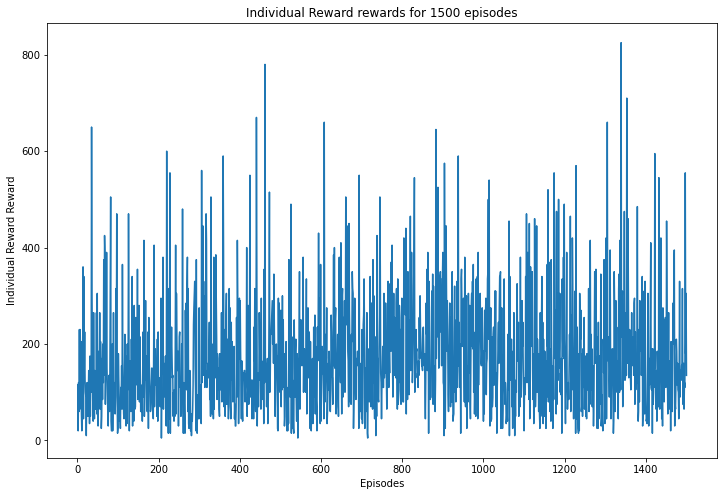

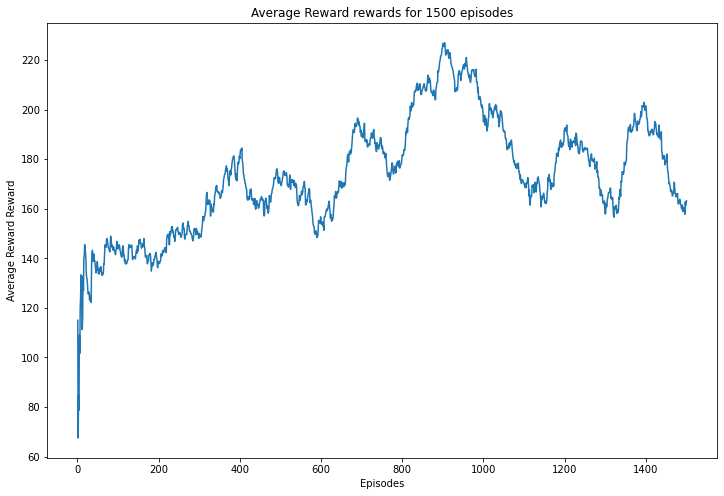

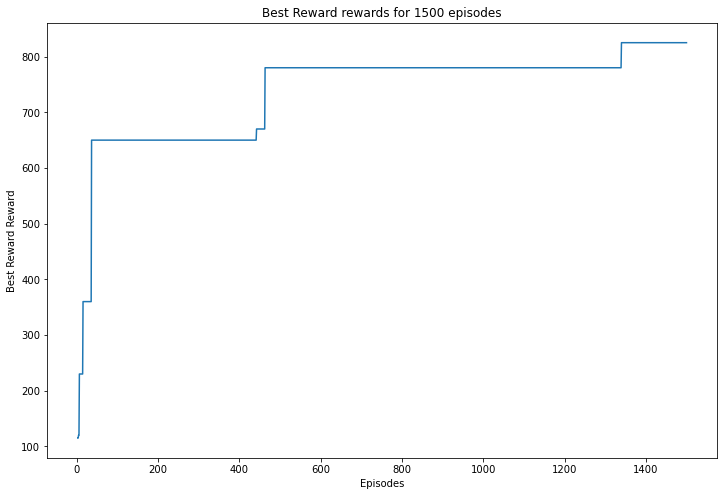

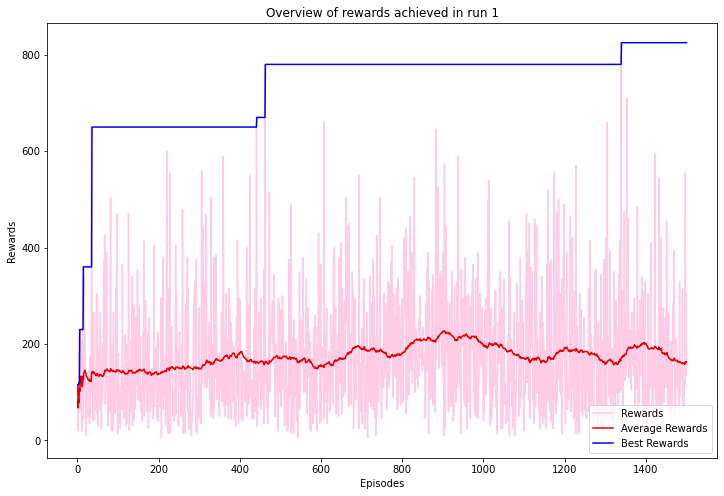

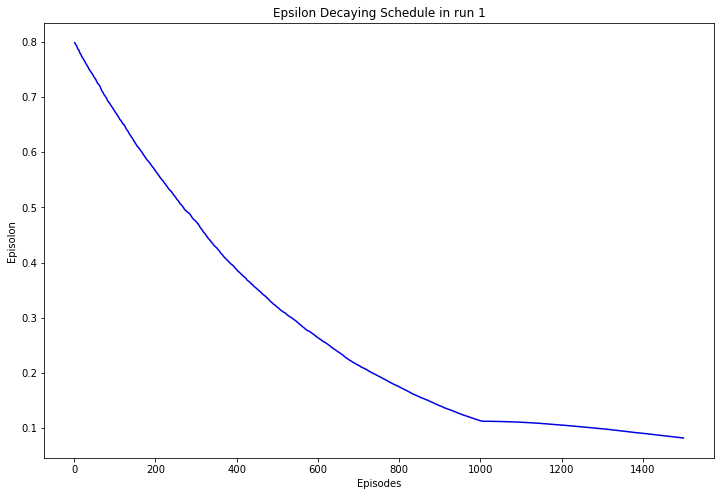

In [65]:
plot_rewards(re,ep+1,"Individual Reward",1)
plot_rewards(ave_re,ep+1,"Average Reward",1)
plot_rewards(best_re,ep+1,"Best Reward",1)
pretty_plot(re,ave_re,best_re,1)
plot_eps(epss,1)

# Run 2

In [24]:
N_EPDS = 2000  # total number of episodes to train the agent for


EPS_START = 0.1
EPS_FINL = 0.005

EPS_DECAY = 200 * 300 # epd equals EPS_DECAY approximately 300 episodes, assuming 200 frames per episode, slowing start are 600 episodes
DECAY_TH = 2 # start slowing decay at rate = 2, eps = 0.018.

DIFF = 0
DIFF_P = 0.3
BREAK_TH = 500

EP_TH1 = 800 # threshold for updating learning rate
EP_TH2 = 1600
EP_TH3 = 5000
LR1 = 1e-5 # changed from 1e-5
LR2 = 5e-6 # changed from 6e-6
LR3 = 2e-6 # changed from 2e-6, 1e-6
LR4 = 1e-5 # changed from 1e-6

TGT_UPD_FRQ1 = 2000 # update approximately 10 episodes
TGT_UPD_FRQ2 = 4000 # change to maybe 18 episodes after 800 episodes
TGT_UPD_TH = 800
buffer = ReplayBuffer(MEM_CAP)

In [25]:
ave_re, re, best_re,ep, epss = train(env,main_model,target_model,buffer,device)
env.close()

  0%|          | 0/2000 [00:00<?, ?it/s]


highest running_average_reward of 85.0 achieved!

EP 0, curr_reward: 85.0, best_reward: 85.0, running_avg_reward: 85.0, curr_epsilon: 0.0997

This episode takes 167 iterations


highest running_average_reward of 92.5 achieved!

EP 1, curr_reward: 100.0, best_reward: 100.0, running_avg_reward: 92.5, curr_epsilon: 0.0994

highest running_average_reward of 163.333 achieved!

EP 2, curr_reward: 305.0, best_reward: 305.0, running_avg_reward: 163.333, curr_epsilon: 0.099

highest running_average_reward of 207.5 achieved!

EP 3, curr_reward: 340.0, best_reward: 340.0, running_avg_reward: 207.5, curr_epsilon: 0.0985

Learning starts!

EP 4, curr_reward: 110.0, best_reward: 340.0, running_avg_reward: 188.0, curr_epsilon: 0.0983
EP 5, curr_reward: 130.0, best_reward: 340.0, running_avg_reward: 178.333, curr_epsilon: 0.0981
EP 6, curr_reward: 115.0, best_reward: 340.0, running_avg_reward: 169.286, curr_epsilon: 0.0977
EP 7, curr_reward: 75.0, best_reward: 340.0, running_avg_reward: 157.5, curr_e

EP 82, curr_reward: 140.0, best_reward: 540.0, running_avg_reward: 183.675, curr_epsilon: 0.0756
EP 83, curr_reward: 145.0, best_reward: 540.0, running_avg_reward: 183.214, curr_epsilon: 0.0753
EP 84, curr_reward: 480.0, best_reward: 540.0, running_avg_reward: 186.706, curr_epsilon: 0.075
EP 85, curr_reward: 205.0, best_reward: 540.0, running_avg_reward: 186.919, curr_epsilon: 0.0747
EP 86, curr_reward: 395.0, best_reward: 540.0, running_avg_reward: 189.31, curr_epsilon: 0.0744
EP 87, curr_reward: 70.0, best_reward: 540.0, running_avg_reward: 187.955, curr_epsilon: 0.0742
EP 88, curr_reward: 130.0, best_reward: 540.0, running_avg_reward: 187.303, curr_epsilon: 0.074
EP 89, curr_reward: 75.0, best_reward: 540.0, running_avg_reward: 186.056, curr_epsilon: 0.0737
EP 90, curr_reward: 90.0, best_reward: 540.0, running_avg_reward: 185.0, curr_epsilon: 0.0735
EP 91, curr_reward: 90.0, best_reward: 540.0, running_avg_reward: 183.967, curr_epsilon: 0.0733
EP 92, curr_reward: 140.0, best_reward:

EP 167, curr_reward: 90.0, best_reward: 540.0, running_avg_reward: 157.15, curr_epsilon: 0.057
EP 168, curr_reward: 55.0, best_reward: 540.0, running_avg_reward: 154.95, curr_epsilon: 0.0569
EP 169, curr_reward: 200.0, best_reward: 540.0, running_avg_reward: 156.9, curr_epsilon: 0.0567
EP 170, curr_reward: 380.0, best_reward: 540.0, running_avg_reward: 156.65, curr_epsilon: 0.0565
EP 171, curr_reward: 515.0, best_reward: 540.0, running_avg_reward: 161.1, curr_epsilon: 0.0562
EP 172, curr_reward: 265.0, best_reward: 540.0, running_avg_reward: 161.85, curr_epsilon: 0.056
EP 173, curr_reward: 130.0, best_reward: 540.0, running_avg_reward: 161.5, curr_epsilon: 0.0558
EP 174, curr_reward: 360.0, best_reward: 540.0, running_avg_reward: 163.95, curr_epsilon: 0.0555
EP 175, curr_reward: 90.0, best_reward: 540.0, running_avg_reward: 162.9, curr_epsilon: 0.0554

This episode takes 166 iterations

EP 176, curr_reward: 290.0, best_reward: 540.0, running_avg_reward: 163.05, curr_epsilon: 0.0552
EP 

EP 251, curr_reward: 185.0, best_reward: 660.0, running_avg_reward: 182.2, curr_epsilon: 0.0438
EP 252, curr_reward: 140.0, best_reward: 660.0, running_avg_reward: 180.45, curr_epsilon: 0.0436
EP 253, curr_reward: 340.0, best_reward: 660.0, running_avg_reward: 181.5, curr_epsilon: 0.0434
EP 254, curr_reward: 100.0, best_reward: 660.0, running_avg_reward: 181.65, curr_epsilon: 0.0433
EP 255, curr_reward: 180.0, best_reward: 660.0, running_avg_reward: 182.9, curr_epsilon: 0.0431
EP 256, curr_reward: 55.0, best_reward: 660.0, running_avg_reward: 181.3, curr_epsilon: 0.0431
EP 257, curr_reward: 130.0, best_reward: 660.0, running_avg_reward: 182.4, curr_epsilon: 0.043
EP 258, curr_reward: 110.0, best_reward: 660.0, running_avg_reward: 181.85, curr_epsilon: 0.0428
EP 259, curr_reward: 220.0, best_reward: 660.0, running_avg_reward: 181.9, curr_epsilon: 0.0427
EP 260, curr_reward: 25.0, best_reward: 660.0, running_avg_reward: 180.9, curr_epsilon: 0.0426
EP 261, curr_reward: 310.0, best_reward:

EP 336, curr_reward: 190.0, best_reward: 705.0, running_avg_reward: 165.85, curr_epsilon: 0.0343
EP 337, curr_reward: 215.0, best_reward: 705.0, running_avg_reward: 165.05, curr_epsilon: 0.0342
EP 338, curr_reward: 90.0, best_reward: 705.0, running_avg_reward: 165.5, curr_epsilon: 0.0341
EP 339, curr_reward: 115.0, best_reward: 705.0, running_avg_reward: 164.15, curr_epsilon: 0.034
EP 340, curr_reward: 55.0, best_reward: 705.0, running_avg_reward: 161.5, curr_epsilon: 0.0339
EP 341, curr_reward: 275.0, best_reward: 705.0, running_avg_reward: 163.3, curr_epsilon: 0.0338
EP 342, curr_reward: 45.0, best_reward: 705.0, running_avg_reward: 163.6, curr_epsilon: 0.0338
EP 343, curr_reward: 305.0, best_reward: 705.0, running_avg_reward: 163.25, curr_epsilon: 0.0336
EP 344, curr_reward: 55.0, best_reward: 705.0, running_avg_reward: 162.7, curr_epsilon: 0.0336
EP 345, curr_reward: 50.0, best_reward: 705.0, running_avg_reward: 160.1, curr_epsilon: 0.0335
EP 346, curr_reward: 180.0, best_reward: 7

EP 421, curr_reward: 235.0, best_reward: 705.0, running_avg_reward: 169.7, curr_epsilon: 0.0268
EP 422, curr_reward: 465.0, best_reward: 705.0, running_avg_reward: 172.8, curr_epsilon: 0.0267
EP 423, curr_reward: 160.0, best_reward: 705.0, running_avg_reward: 172.7, curr_epsilon: 0.0266
EP 424, curr_reward: 30.0, best_reward: 705.0, running_avg_reward: 168.4, curr_epsilon: 0.0266
EP 425, curr_reward: 190.0, best_reward: 705.0, running_avg_reward: 166.85, curr_epsilon: 0.0265

This episode takes 240 iterations

EP 426, curr_reward: 420.0, best_reward: 705.0, running_avg_reward: 168.75, curr_epsilon: 0.0264
EP 427, curr_reward: 380.0, best_reward: 705.0, running_avg_reward: 169.7, curr_epsilon: 0.0263
EP 428, curr_reward: 120.0, best_reward: 705.0, running_avg_reward: 168.1, curr_epsilon: 0.0262
EP 429, curr_reward: 100.0, best_reward: 705.0, running_avg_reward: 168.55, curr_epsilon: 0.0261
EP 430, curr_reward: 495.0, best_reward: 705.0, running_avg_reward: 173.05, curr_epsilon: 0.026
EP

EP 505, curr_reward: 175.0, best_reward: 705.0, running_avg_reward: 189.5, curr_epsilon: 0.0211
EP 506, curr_reward: 150.0, best_reward: 705.0, running_avg_reward: 189.85, curr_epsilon: 0.021
EP 507, curr_reward: 180.0, best_reward: 705.0, running_avg_reward: 188.85, curr_epsilon: 0.021
EP 508, curr_reward: 135.0, best_reward: 705.0, running_avg_reward: 189.35, curr_epsilon: 0.0209
EP 509, curr_reward: 240.0, best_reward: 705.0, running_avg_reward: 187.2, curr_epsilon: 0.0208
EP 510, curr_reward: 295.0, best_reward: 705.0, running_avg_reward: 185.4, curr_epsilon: 0.0208
EP 511, curr_reward: 205.0, best_reward: 705.0, running_avg_reward: 185.4, curr_epsilon: 0.0207
EP 512, curr_reward: 170.0, best_reward: 705.0, running_avg_reward: 185.25, curr_epsilon: 0.0206
EP 513, curr_reward: 35.0, best_reward: 705.0, running_avg_reward: 184.0, curr_epsilon: 0.0206
EP 514, curr_reward: 195.0, best_reward: 705.0, running_avg_reward: 183.6, curr_epsilon: 0.0206
EP 515, curr_reward: 135.0, best_reward

EP 589, curr_reward: 75.0, best_reward: 710.0, running_avg_reward: 190.2, curr_epsilon: 0.0178
EP 590, curr_reward: 655.0, best_reward: 710.0, running_avg_reward: 196.35, curr_epsilon: 0.0178
EP 591, curr_reward: 20.0, best_reward: 710.0, running_avg_reward: 194.4, curr_epsilon: 0.0178
EP 592, curr_reward: 140.0, best_reward: 710.0, running_avg_reward: 194.65, curr_epsilon: 0.0178
EP 593, curr_reward: 155.0, best_reward: 710.0, running_avg_reward: 193.15, curr_epsilon: 0.0178
EP 594, curr_reward: 35.0, best_reward: 710.0, running_avg_reward: 189.35, curr_epsilon: 0.0178
EP 595, curr_reward: 160.0, best_reward: 710.0, running_avg_reward: 189.7, curr_epsilon: 0.0178
EP 596, curr_reward: 390.0, best_reward: 710.0, running_avg_reward: 192.1, curr_epsilon: 0.0178
EP 597, curr_reward: 55.0, best_reward: 710.0, running_avg_reward: 191.45, curr_epsilon: 0.0178
EP 598, curr_reward: 120.0, best_reward: 710.0, running_avg_reward: 192.35, curr_epsilon: 0.0178
EP 599, curr_reward: 55.0, best_reward

EP 674, curr_reward: 145.0, best_reward: 710.0, running_avg_reward: 160.1, curr_epsilon: 0.0172
EP 675, curr_reward: 35.0, best_reward: 710.0, running_avg_reward: 159.2, curr_epsilon: 0.0172

This episode takes 124 iterations

EP 676, curr_reward: 15.0, best_reward: 710.0, running_avg_reward: 158.0, curr_epsilon: 0.0172
EP 677, curr_reward: 75.0, best_reward: 710.0, running_avg_reward: 153.85, curr_epsilon: 0.0172
EP 678, curr_reward: 115.0, best_reward: 710.0, running_avg_reward: 153.7, curr_epsilon: 0.0172
EP 679, curr_reward: 65.0, best_reward: 710.0, running_avg_reward: 150.8, curr_epsilon: 0.0172
EP 680, curr_reward: 165.0, best_reward: 710.0, running_avg_reward: 150.65, curr_epsilon: 0.0171
EP 681, curr_reward: 110.0, best_reward: 710.0, running_avg_reward: 151.4, curr_epsilon: 0.0171
EP 682, curr_reward: 125.0, best_reward: 710.0, running_avg_reward: 150.3, curr_epsilon: 0.0171
EP 683, curr_reward: 260.0, best_reward: 710.0, running_avg_reward: 151.4, curr_epsilon: 0.0171
EP 684

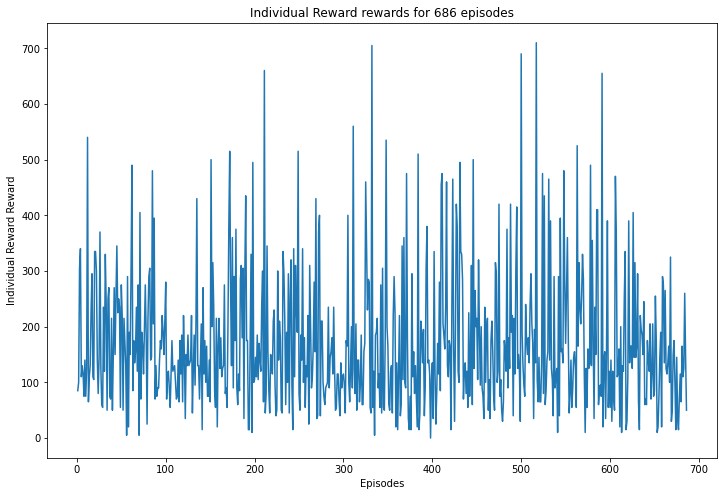

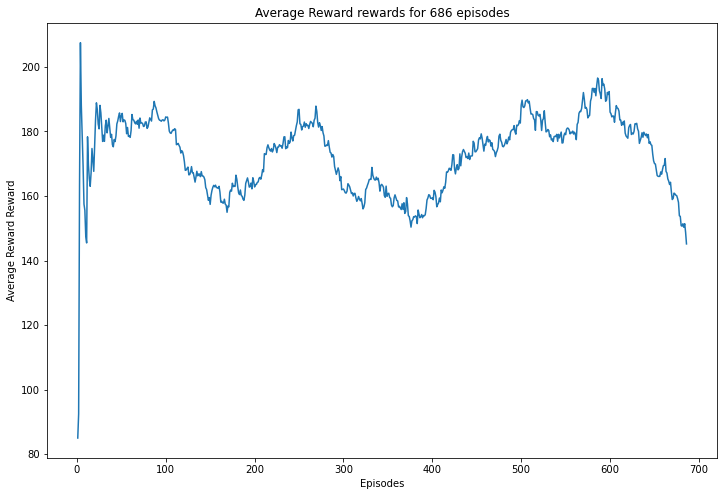

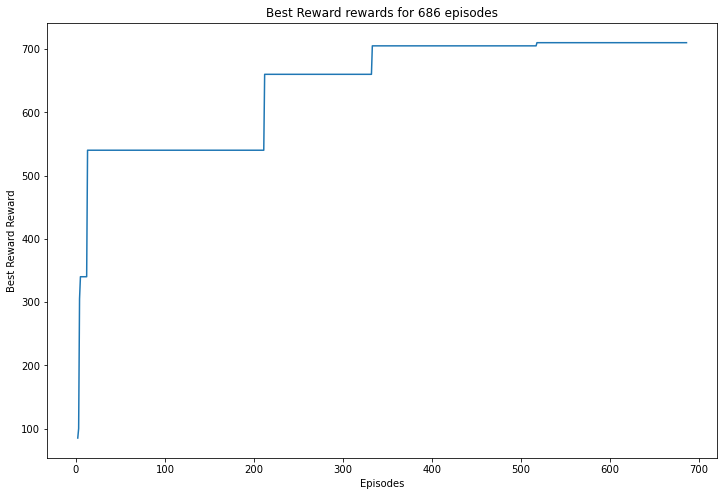

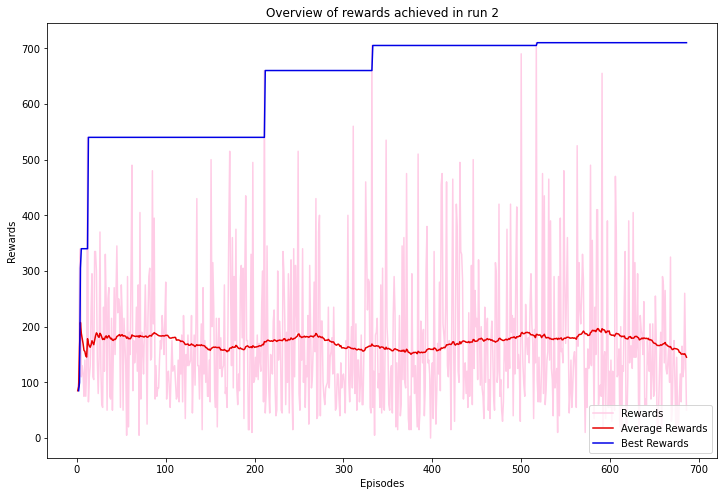

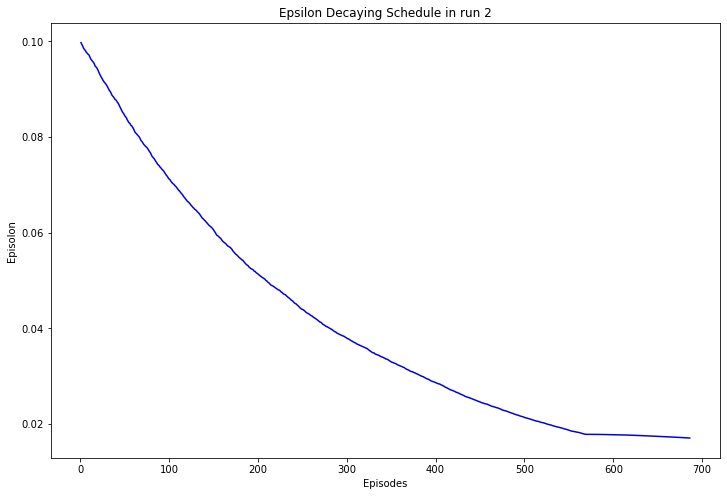

In [26]:
plot_rewards(re,ep+1,"Individual Reward",2)
plot_rewards(ave_re,ep+1,"Average Reward",2)
plot_rewards(best_re,ep+1,"Best Reward",2)
pretty_plot(re,ave_re,best_re,2)
plot_eps(epss,2)

# Run 3

In [30]:

# with batch_size 128
N_EPDS = math.floor(2000/2)  # total number of episodes to train the agent for


EPS_START = 1
EPS_FINL = 0.5

EPS_DECAY = 200 * 300/2 # epd equals EPS_DECAY approximately 300 episodes, assuming 200 frames per episode, slowing start are 600 episodes
DECAY_TH = 2 # start slowing decay at rate = 2, eps = 0.018.

DIFF = 0
DIFF_P = 0.3
BREAK_TH = 500/2

EP_TH1 = 400/2 # threshold for updating learning rate
EP_TH2 = 1000/2
EP_TH3 = 5000/2
LR1 = 5e-6 # changed from 1e-5
LR2 = 1e-6 # changed from 6e-6
LR3 = 2e-7 # changed from 2e-6, 1e-6
LR4 = 1e-7 # changed from 1e-6

TGT_UPD_FRQ1 = 2000 # update approximately 10 episodes
TGT_UPD_FRQ2 = 4000 # change to maybe 18 episodes after 800 episodes
TGT_UPD_TH = 800/2
buffer = ReplayBuffer(MEM_CAP)

In [31]:
ave_re, re, best_re,ep, epss = train(env,main_model,target_model,buffer,device)
env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]


highest running_average_reward of 45.0 achieved!

EP 0, curr_reward: 45.0, best_reward: 45.0, running_avg_reward: 45.0, curr_epsilon: 0.9983

This episode takes 100 iterations


highest running_average_reward of 152.5 achieved!

EP 1, curr_reward: 260.0, best_reward: 260.0, running_avg_reward: 152.5, curr_epsilon: 0.9946
EP 2, curr_reward: 5.0, best_reward: 260.0, running_avg_reward: 103.333, curr_epsilon: 0.9932
EP 3, curr_reward: 65.0, best_reward: 260.0, running_avg_reward: 93.75, curr_epsilon: 0.9912
EP 4, curr_reward: 20.0, best_reward: 260.0, running_avg_reward: 79.0, curr_epsilon: 0.9896
EP 5, curr_reward: 80.0, best_reward: 260.0, running_avg_reward: 79.167, curr_epsilon: 0.9869

Learning starts!

EP 6, curr_reward: 270.0, best_reward: 270.0, running_avg_reward: 106.429, curr_epsilon: 0.9822
EP 7, curr_reward: 105.0, best_reward: 270.0, running_avg_reward: 106.25, curr_epsilon: 0.9792
EP 8, curr_reward: 190.0, best_reward: 270.0, running_avg_reward: 115.556, curr_epsilon: 0.97

KeyboardInterrupt: 

In [32]:
env.close()